In [15]:
%run functions.ipynb

time: 54.3 ms (started: 2023-09-05 11:56:04 +01:00)


# Import libraries

In [2]:
import numpy as np
import pandas as pd
import os
from scipy import io
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mtick
import cylouvain
import networkx as nx
#from scipy.interpolate import make_interp_spline
import matplotlib as mpl
import random
from sklearn.decomposition import PCA
import seaborn as sns
import math
#from sklearn.cross_decomposition import CCA
from scipy import linalg
import copy
import umap
from dPCA import dPCA

#!git clone https://github.com/NeuralAnalysis/PyalData
from PyalData.pyaldata import *


# for LSTM
import xarray as xr
from Neural_Decoding.decoders import LSTMDecoder
from Neural_Decoding.decoders import LSTMClassification
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

# for Bayes Classifier
#from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

#for k-Means clustering
from sklearn.cluster import KMeans

%load_ext autotime

time: 138 µs (started: 2023-09-05 11:53:18 +01:00)


# Load and Preprocessing waveform data

In [ ]:
# load data
data_waveform = load_dataset_from_mat("datasets/Mihili_CO_FF_2014-02-17_waveform.mat")
data_spikes = load_dataset_from_mat("datasets/Chewie_CO_FF_2016-09-15.mat")

# preprocessing of waveform data
waveform_filtered = filter_trial_ID(data_waveform)
waveform_filtered, trials_to_keep_M1, trials_to_keep_PMd = filter_SNR(waveform_filtered, data_spikes, 3)

CUSTOM_PAL_SORT= ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9','#ced4da','#d62424']

In [ ]:
concatenate_avg = concatenate_average_trials(waveform_filtered)
data_normalized = normalize_data(concatenate_avg)

In [ ]:
td = preprocessing_general(data_spikes, combine=True, std=0.05)
td_processed1 = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -19, 3, rates=True)
td_processed2 = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -6, 21, rates=True)


(0.0, 40.0)

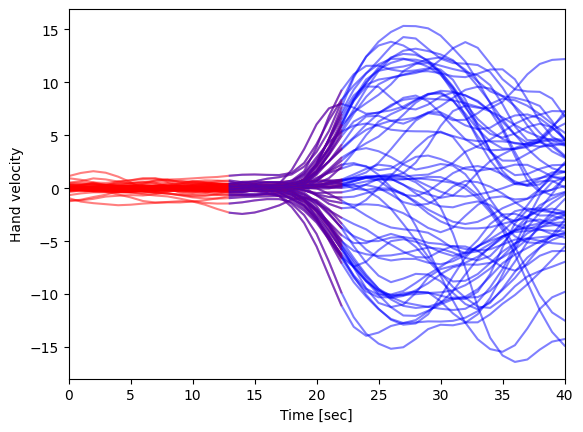

time: 147 ms (started: 2023-09-03 15:11:25 +01:00)


In [26]:
for tr in range(td_processed.shape[0]//10):
    plt.plot(td_processed1.vel[tr][:,0], 'r', alpha=0.5)
    plt.plot(np.arange(13, 41), td_processed2.vel[tr][:,0], 'b', alpha=0.5)

plt.xlabel('Time [sec]')
plt.ylabel('Hand velocity')
plt.xlim([0, 40])

### IF comparing 2 datasets

In [109]:
# to compare two datasets
# load waveform data
data_waveform1 = load_dataset_from_mat("datasets/Chewie_CO_FF_2016-09-15_waveform.mat")
data_spikes1 = load_dataset_from_mat("datasets/Chewie_CO_FF_2016-09-15.mat")

data_waveform2 = load_dataset_from_mat("datasets/Chewie_CO_FF_2016-09-19_waveform.mat")
data_spikes2 = load_dataset_from_mat("datasets/Chewie_CO_FF_2016-09-19.mat")


def process_waveform_data(data_waveform, data_spikes):
    waveform_filtered = filter_trial_ID(data_waveform)
    waveform_filtered, trials_to_keep_M1, trials_to_keep_PMd = filter_SNR(waveform_filtered, data_spikes, 3)
    concatenate_avg = concatenate_average_trials(waveform_filtered)
    data_normalized = normalize_data(concatenate_avg)
    return data_normalized, trials_to_keep_M1, trials_to_keep_PMd

# preprocess waveform data
data_norm1, trials_to_keep_M1_1, trials_to_keep_PMd_1 = process_waveform_data(data_waveform1, data_spikes1)
data_norm2, trials_to_keep_M1_2, trials_to_keep_PMd_2 = process_waveform_data(data_waveform2, data_spikes2)

field rowNum could not be converted to int.
field colNum could not be converted to int.
field rowNum could not be converted to int.
field colNum could not be converted to int.
time: 3min 33s (started: 2023-09-05 12:57:25 +01:00)


# UMAP & Clustering

## UMAP and Louvian Clustering

In [ ]:
RAND_STATE = 42
n_comp = 2 # UMAP dimensions
# change the value of res to change the number of clusters (but keeping it as small as possible)
umap_df, mapper, embedding = umap_on_waveform(data_normalized, 35, RAND_STATE, n_components=n_comp, plot=False)
umap_df, clustering_solution = louvian_clustering(mapper, umap_df, CUSTOM_PAL_SORT, res=1.1, n_components=n_comp, plot=True)
#plt.title('Louvain Clustering')
plt.show()
# import umap.plot
# umap.plot.connectivity(mapper, show_points=True)

In [ ]:
neurons = neurons_in_cluster(clustering_solution)
neurons

/tmp/ipykernel_2701972/2640706964.py:53: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(mapper.graph_) # build graph, every node is a points on UMAP graph
/home/ad2022/.local/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/tmp/ipykernel_2701972/2640706964.py:53: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(mapper.graph_) # build graph, every node is a points on UMAP graph
/home/ad2022/.local/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


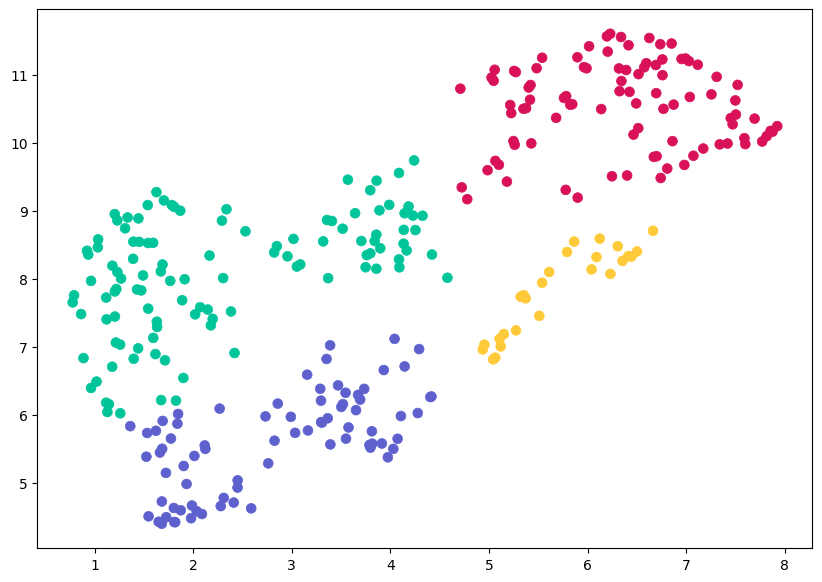

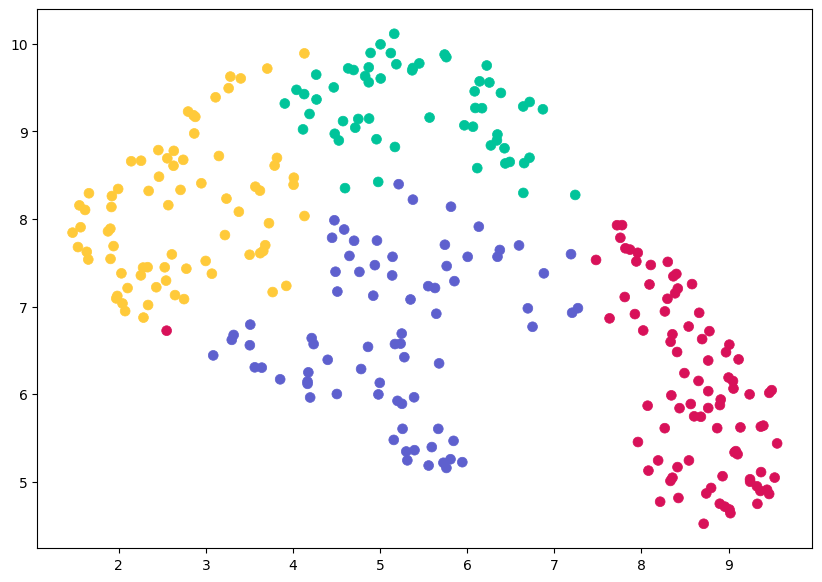

time: 1.57 s (started: 2023-09-05 13:00:58 +01:00)


In [110]:
# compare 2 datasets
RAND_STATE = 42
CUSTOM_PAL_SORT= ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9','#ced4da','#d62424']

def waveMAP(data_normalized, n_neighbours, resolution, n_comp, rnd):
    umap_df, mapper, _ = umap_on_waveform(data_normalized, 35, rnd, n_components=n_comp, plot=False)
    umap_df, clustering_solution = louvian_clustering(mapper, umap_df, CUSTOM_PAL_SORT, res=resolution, n_components=n_comp, plot=True)
    return umap_df, clustering_solution

n_comp = 2
umap_df1, clustering_solution1 = waveMAP(data_norm1, 35, 3, n_comp, RAND_STATE)
umap_df2, clustering_solution2 = waveMAP(data_norm2, 35, 3, n_comp, RAND_STATE)

## UMAP and KMeans Clustering

/home/ad2022/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


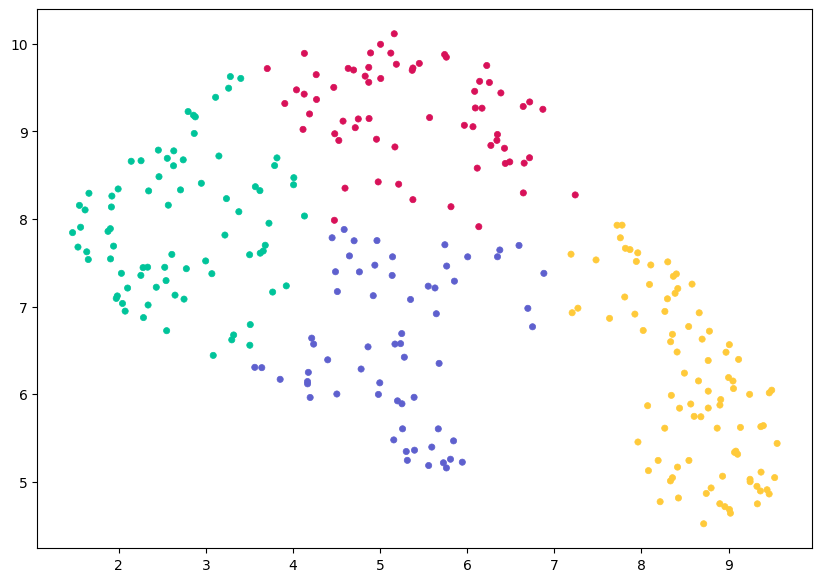

time: 747 ms (started: 2023-08-31 15:26:03 +01:00)


In [57]:
# UMAP
RAND_STATE = 42
n_comp = 2
umap_df, mapper, embedding = umap_on_waveform(data_normalized, 35, RAND_STATE, n_components=n_comp, plot=False)

#K-Means 
kmeans = KMeans(n_clusters=4, random_state=0).fit(embedding)
labels = kmeans.labels_
CUSTOM_PAL_SORT2 = [ , '#5e60ce', '#ffca3a', '#00c49a']
CUSTOM_PAL_SORT2= ['#ffca3a','#5e60ce','#00c49a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9','#ced4da','#d62424']

#plot
cluster_colors = [CUSTOM_PAL_SORT2[i] for i in labels]

if n_comp == 3:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(embedding[:,0], embedding[:,1],embedding[:,2], marker='o', c=cluster_colors, s=20, linewidth=0.5)
    
else:
    plt.figure(figsize=(10, 7))
    plt.scatter(embedding[:,0], embedding[:,1], marker='o', c=cluster_colors, s=20, linewidth=0.5)
#plt.title('K-Means Clustering')
clustering_solution = labels


In [ ]:
neurons = neurons_in_cluster(clustering_solution)
neurons

## Compare methods (dataset 1)

In [ ]:
neurons1 = neurons_in_cluster(clustering_solution1)
neurons2 = neurons_in_cluster(clustering_solution2)
print(neurons1) # [78, 112, 26, 93]
print(neurons2) # [71, 86, 69, 83]

In [ ]:
neuron_types1 = neuron_classes(clustering_solution1)
neuron_types2 = neuron_classes(clustering_solution2)

correlation, maxValue_clustering = match_clusters(umap_df1, umap_df2, neuron_types1, neuron_types2)
maxValue_clustering

In [ ]:
maxValue_clustering = [3, 0, 2, 1]
# maxValue_clustering = [0, 1, 2, 3]
# Louvain
meanFR_Lou = [ 9.08701267, 9.16606035, 12.45212654, 7.19342094]
smeFR_Lou = [0.79259522, 0.62656936, 2.31149547, 0.60992364]
FR_overall_mean = 8.828897037498102
FR_overall_sme = 0.4117036533753934

meanPTT_Lou = [0.18807692307692309, 0.2633035714285714, 0.2526923076923077, 0.5058064516129032]
smePTT_Lou = [0.006829995558296806, 0.009017758479708805, 0.008661239445373075, 0.012515059796774829]
PTT_overall_mean = 0.3164077669902913
PTT_overall_sme = 0.009010090372780237

#KMeans
meanFR_KM = [ 8.95662302, 6.7116695, 10.87093146, 9.21579641]
smeFR_KM = [0.86599933, 0.58601789, 1.03830978, 0.76617395]

meanPTT_KM = [0.24676056338028157, 0.5145348837209301, 0.29826086956521736, 0.18578313253012047]
smePTT_KM = [0.012072936198381956, 0.013047793512392344, 0.008108061706679652, 0.006434503094632526]


# maxValue -> match clusters from KMeans and Louvain
meanFR_KM_ordered = order_array(meanFR_KM, maxValue_clustering, axis='col')
smeFR_KM_ordered = order_array(smeFR_KM, maxValue_clustering, axis='col')

fr_mean_Lou = np.append(meanFR_Lou, FR_overall_mean)
fr_mean_KM = np.append(meanFR_KM_ordered, FR_overall_mean)
fr_sme_Lou =  np.append(smeFR_Lou, FR_overall_sme)
fr_sme_KM =  np.append(smeFR_KM_ordered, FR_overall_sme)


meanPTT_KM_ordered = order_array(meanPTT_KM, maxValue_clustering, axis='col')
smePTT_KM_ordered = order_array(smePTT_KM, maxValue_clustering, axis='col')

ptt_mean_Lou = np.append(meanPTT_Lou, PTT_overall_mean)
ptt_mean_KM = np.append(meanPTT_KM_ordered, PTT_overall_mean)
ptt_sme_Lou =  np.append(smePTT_Lou, PTT_overall_sme)
ptt_sme_KM =  np.append(smePTT_KM_ordered, PTT_overall_sme)


f, ax = plt.subplots(1,2, figsize=(20, 5))

compare_values_plot(ax[0], fr_mean_Lou, fr_mean_KM, fr_sme_Lou, fr_sme_KM, 'FR', plot_sme=False)
ax[0].set_ylabel('Firing rate [Hz]')
ax[0].set_title('Louvain: 1, KMeans: 2')
compare_values_plot(ax[1], ptt_mean_Lou, ptt_mean_KM, ptt_sme_Lou, ptt_sme_KM, 'PTT', plot_sme=False)
ax[1].set_ylabel('Peak to trough [sec]')
ax[1].set_title('Louvain: 1, KMeans: 2')


# Clusters properties

In [6]:
#general preprocessing
td = preprocessing_general(data_spikes, combine=True, std=0.05)

time: 2.04 s (started: 2023-09-01 12:00:49 +01:00)


### Violin plots

In [ ]:
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -6, 21, rates=False);
neuron_types = neuron_classes(clustering_solution)

color = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9']

fr_neurons = get_average_firing_rates(td_processed, "both_spikes",divide_by_bin_size=None) 
ptt_neurons = peak_to_trough_all(data_normalized)
AP_neurons = AP_width_all(data_normalized)

#AP_neurons[264] = np.mean(AP_neurons) # for dataset C19 only


fig, ax = plt.subplots(1,3, figsize=(16,4))
plot_violin(fr_neurons, neuron_types, color, 'Firing rate [Hz]', ax=ax[0])
plot_violin(ptt_neurons, neuron_types, color, 'Peak to trough duration [ms]', ax=ax[1])
plot_violin(AP_neurons, neuron_types, color, 'Action potential width [ms]', ax=ax[2])

/tmp/ipykernel_290826/349108861.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td_processed.M1_spikes[j] = td_processed.M1_spikes[j][:, trials_to_keep_M1] # all rows corresponding to neurons with SNR>3
/tmp/ipykernel_290826/349108861.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td_processed.PMd_spikes[j] = td_processed.PMd_spikes[j][:, trials_to_keep_PMd] # all rows corresponding to neurons with SNR>3
/tmp/ipykernel_290826/349108861.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

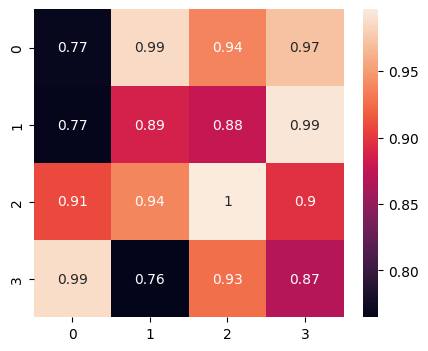

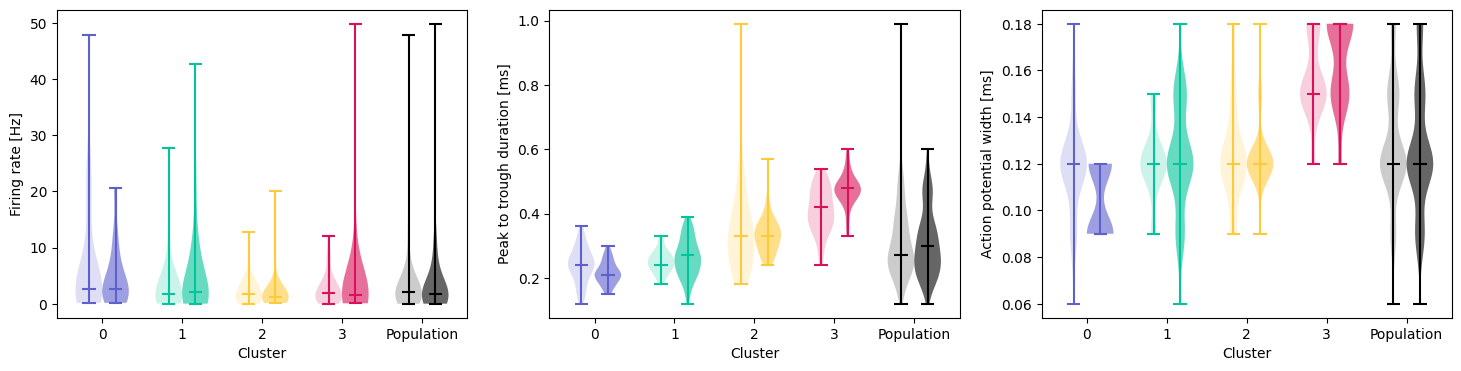

time: 1.5 s (started: 2023-08-28 17:34:25 +01:00)


In [242]:
# compare 2 datasets with violin plots
td1 = preprocessing_general(data_spikes1, combine=False)
td2 = preprocessing_general(data_spikes2, combine=False)

td_processed1 = preprocessing_spikes(td1, trials_to_keep_M1_1, trials_to_keep_PMd_1, "idx_movement_on", -4, 14, rates=False);
td_processed2 = preprocessing_spikes(td2, trials_to_keep_M1_2, trials_to_keep_PMd_2, "idx_movement_on", -4, 14, rates=False);

neuron_types1 = neuron_classes(clustering_solution1)
neuron_types2 = neuron_classes(clustering_solution2)

color = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9']

fr_neurons1 = get_average_firing_rates(td_processed1, "both_spikes",divide_by_bin_size=None) 
ptt_neurons1 = peak_to_trough_all(data_norm1)
AP_neurons1 = AP_width_all(data_norm1)

fr_neurons2 = get_average_firing_rates(td_processed2, "both_spikes",divide_by_bin_size=None) 
ptt_neurons2 = peak_to_trough_all(data_norm2)
AP_neurons2 = AP_width_all(data_norm2)

if data_spikes1.monkey[0][0] == 'C' or data_spikes1.monkey[0][0] == 'C':
    if data_spikes1.date[0][3:5] == '19':
        AP_neurons1[264] = np.mean(AP_neurons1) # for dataset C19 only
    elif data_spikes2.date[0][3:5] == '19':
        AP_neurons2[264] = np.mean(AP_neurons2) # for dataset C19 only
        
        
_, maxValue = match_clusters(umap_df1, umap_df2, neuron_types1, neuron_types2)

neuron_types_ordered = []
for indx in maxValue:
    neuron_types_ordered.append(neuron_types2[indx])

shift = 0.25
fig, ax = plt.subplots(1,3, figsize=(18,4))

# these are lighter
plot_violin(fr_neurons1, neuron_types1, color, 'Firing rate [Hz]', shift=-shift, ax=ax[0])
plot_violin(ptt_neurons1, neuron_types1, color, 'Peak to trough duration [ms]',shift=-shift, ax=ax[1])
plot_violin(AP_neurons1, neuron_types1, color, 'Action potential width [ms]', shift=-shift, ax=ax[2])

# these are darker
plot_violin(fr_neurons2, neuron_types_ordered, color, 'Firing rate [Hz]', shift=shift, ax=ax[0])
plot_violin(ptt_neurons2, neuron_types_ordered, color, 'Peak to trough duration [ms]',shift=shift, ax=ax[1])
plot_violin(AP_neurons2, neuron_types_ordered, color, 'Action potential width [ms]', shift=shift, ax=ax[2])
ax[0].set_xlabel('Cluster')
ax[1].set_xlabel('Cluster')
ax[2].set_xlabel('Cluster');

## PCA and Variance Explained 

In [ ]:
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -6, 21, rates=True)

neuron_types = neuron_classes(clustering_solution)
PCA_variance_explained(td_processed, neuron_types, 20, CUSTOM_PAL_SORT)

In [ ]:
# only to check what PCA returns
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -2, 7, rates=True)
neuron_types = neuron_classes(clustering_solution)
sampled_data = sample_neurons(neuron_types, 25)

cluster = 0
pca_dims = 15
move_td = apply_PCA(td_processed, sampled_data, cluster, pca_dims, return_model=False)

### PCA move vs prep orthogonality

In [ ]:
# generate PCA model (space) for one interval
td = preprocessing_general(data_spikes)
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -19,3, rates=True)

N_samples = 50
cluster = 0
neuron_types = neuron_classes(clustering_solution)
sampled_data = sample_neurons(neuron_types, N_samples)

data_spikes_merged = merge_signals(td_processed, ["M1_rates", "PMd_rates"], "both_rates")
for i in range(data_spikes_merged.shape[0]):
      data_spikes_merged.both_rates[i] = data_spikes_merged.both_rates[i][:, sampled_data[cluster]]

pca_dims = 10 
pca = fit_dim_reduce_model(data_spikes_merged, PCA(pca_dims), "both_rates")


In [ ]:
# project other interval onto PCA space found before
td = preprocessing_general(data_spikes)
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -6, 21, rates=True)

data_spikes_merged = merge_signals(td_processed, ["M1_rates", "PMd_rates"], "both_rates")

for i in range(data_spikes_merged.shape[0]):
      data_spikes_merged.both_rates[i] = data_spikes_merged.both_rates[i][:, sampled_data[cluster]]

# project onto model found before
data_spikes_merged['both_pca'] = [pca.transform(s) for s in data_spikes_merged['both_rates']]
variance_projected_components = np.concatenate(data_spikes_merged.both_pca).var(axis=0)
#print(variance_projected_components)

# compute exaplined variance ratio of projected data
concat_trials = np.concatenate(data_spikes_merged.both_rates)
all_var = np.cov(concat_trials.T)
sum_all_var = np.sum(all_var.diagonal()) 

var_explained_ratio_proj = variance_projected_components / sum_all_var


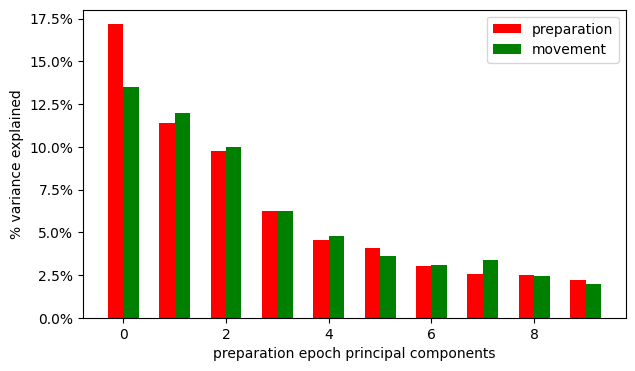

"\n# relative to variance of explained by each component\ntot_var = pca.explained_variance_.sum()\ntot_var_proj = variance_projected_components.sum()\n\nplt.subplots(figsize=(7,4))\nplt.bar(xpos-0.15, pca.explained_variance_/tot_var,width=0.3, align='center', label=f'{orig}')\nplt.bar(xpos+0.15, variance_projected_components/tot_var_proj, width=0.3, align='center', label=f'{proj}')\nplt.legend()\nplt.xlabel(f'{orig} epoch principal components')\nplt.ylabel('% variance explained')\nplt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))\n"

time: 90.3 ms (started: 2023-08-22 13:36:51 +01:00)


In [25]:
xpos = np.arange(len(var_explained_ratio_proj))
orig = 'preparation'
proj = 'movement'

# relative to variance of original data (doesn't sum up to 100%)
plt.subplots(figsize=(7,4))
plt.bar(xpos-0.15, pca.explained_variance_ratio_,width=0.3, align='center', label=f'{orig}', color='r')
plt.bar(xpos+0.15, var_explained_ratio_proj, width=0.3, align='center', label=f'{proj}', color='g')
plt.legend()
plt.xlabel(f'{orig} epoch principal components')
plt.ylabel('% variance explained')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.show()

'''
# relative to variance of explained by each component
tot_var = pca.explained_variance_.sum()
tot_var_proj = variance_projected_components.sum()

plt.subplots(figsize=(7,4))
plt.bar(xpos-0.15, pca.explained_variance_/tot_var,width=0.3, align='center', label=f'{orig}')
plt.bar(xpos+0.15, variance_projected_components/tot_var_proj, width=0.3, align='center', label=f'{proj}')
plt.legend()
plt.xlabel(f'{orig} epoch principal components')
plt.ylabel('% variance explained')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
'''

In [192]:
var_explained_ratio_proj

array([0.08696923, 0.04625646, 0.05159832, 0.04409137, 0.02177621,
       0.02485206, 0.02047416, 0.01131946, 0.01842708, 0.01068709],
      dtype=float32)

time: 2.31 ms (started: 2023-08-10 16:22:32 +01:00)


In [27]:
num = var_explained_ratio_proj.sum()
den = pca.explained_variance_ratio_.sum()
num/den
# prep on mov -> 0.9386537
# mov on prep -> 0.78924537

0.95913476

time: 2.35 ms (started: 2023-08-22 13:36:56 +01:00)


In [65]:
neurons_in_cluster(clustering_solution)

[78, 112, 26, 93]

time: 2.16 ms (started: 2023-08-22 13:56:45 +01:00)


In [ ]:
# prep vs mov for each clusters
td = preprocessing_general(data_spikes)
td_processed_mov = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -6, 21, rates=True)

td = preprocessing_general(data_spikes)
td_processed_prep = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -19, 3, rates=True)

data_orig = td_processed_prep
data_proj = td_processed_mov

N_samples = 25
pca_dims = 10
neuron_types = neuron_classes(clustering_solution)
sampled_data = sample_neurons(neuron_types, N_samples)
orthog_index = np.zeros(len(neuron_types))

for cluster in range(len(neuron_types)):
    sampled_from_cluster = sampled_data[cluster]
    
    # generate PCA model (space) for one interval
    _, pca = apply_PCA(data_orig, sampled_from_cluster, -1, pca_dims, return_model=True)

    # prepare data for other interval
    data_spikes_merged = merge_signals(data_proj, ["M1_rates", "PMd_rates"], "both_rates")

    for i in range(data_spikes_merged.shape[0]):
          data_spikes_merged.both_rates[i] = data_spikes_merged.both_rates[i][:, sampled_from_cluster]

    # project onto model found before
    data_spikes_merged['both_pca'] = [pca.transform(s) for s in data_spikes_merged['both_rates']]
    variance_projected_components = np.concatenate(data_spikes_merged.both_pca).var(axis=0)

    # compute exaplined variance ratio of projected data
    concat_trials = np.concatenate(data_spikes_merged.both_rates)
    all_var = np.cov(concat_trials.T)
    sum_all_var = np.sum(all_var.diagonal()) 

    var_explained_ratio_proj = variance_projected_components / sum_all_var

    num = var_explained_ratio_proj.sum()
    _, pca2 = apply_PCA(data_proj, sampled_from_cluster, -1, pca_dims, return_model=True)
    den = pca2.explained_variance_ratio_.sum()
    #den = pca.explained_variance_ratio_.sum()
    orthog_index[cluster] = num/den

In [69]:
#alignment_index_mov_to_prep = orthog_index

time: 218 µs (started: 2023-08-22 13:57:33 +01:00)


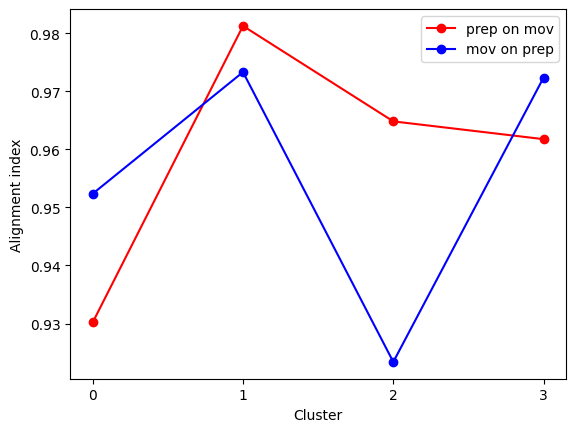

time: 82 ms (started: 2023-08-22 13:59:08 +01:00)


In [72]:
maxValue = [2,1,0,3]
orthog_index_ordered = order_array(orthog_index, maxValue)
alignment_index_mov_to_prep_ordered = order_array(alignment_index_mov_to_prep, maxValue)

xpos = np.arange(4)
#plt.bar(xpos-0.15, orthog_index, label='prep on mov', align='center', width=0.3)
#plt.bar(xpos+0.15, alignment_index_mov_to_prep, label='mov on prep', alpha=0.5, align='center', width=0.3)
plt.plot(orthog_index_ordered, 'r', label='prep on mov', marker='o', markerfacecolor='r')
plt.plot(alignment_index_mov_to_prep_ordered, 'b', label='mov on prep', marker='o', markerfacecolor='b')
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Alignment index')
plt.xlabel('Cluster')
plt.xticks([0,1,2,3], labels = ['0','1','2','3']);


### PCA cluster orthogonality

In [ ]:
# generate PCA model (space) for one cluster
neurons = neurons_in_cluster(clustering_solution)

neur_min = np.min(neurons)

td = preprocessing_general(data_spikes)
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -6, 21, rates=True)
neuron_types = neuron_classes(clustering_solution)

data_spikes_merged = merge_signals(td_processed, ["M1_rates", "PMd_rates"], "both_rates")
clust1 = 2
for i in range(data_spikes_merged.shape[0]):
    data_spikes_merged.both_rates[i] = data_spikes_merged.both_rates[i][:, neuron_types[clust1][:neur_min]]

pca_dims = 10 
pca = fit_dim_reduce_model(data_spikes_merged, PCA(pca_dims), "both_rates")


In [269]:
# project other interval onto PCA space found before
td = preprocessing_general(data_spikes)
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -6, 21, rates=True)

data_spikes_merged = merge_signals(td_processed, ["M1_rates", "PMd_rates"], "both_rates")

clust2 = 3
for i in range(data_spikes_merged.shape[0]):
    data_spikes_merged.both_rates[i] = data_spikes_merged.both_rates[i][:, neuron_types[clust2][:neur_min]]

# project onto model found before
data_spikes_merged['both_pca'] = [pca.transform(s) for s in data_spikes_merged['both_rates']]
variance_projected_components = np.concatenate(data_spikes_merged.both_pca).var(axis=0)
#print(variance_projected_components)

# compute exaplined variance ratio of projected data
concat_trials = np.concatenate(data_spikes_merged.both_rates)
all_var = np.cov(concat_trials.T)
sum_all_var = np.sum(all_var.diagonal()) 

var_explained_ratio_proj = variance_projected_components / sum_all_var


/tmp/ipykernel_3739835/349108861.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td_processed.M1_spikes[j] = td_processed.M1_spikes[j][:, trials_to_keep_M1] # all rows corresponding to neurons with SNR>3
/tmp/ipykernel_3739835/349108861.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td_processed.PMd_spikes[j] = td_processed.PMd_spikes[j][:, trials_to_keep_PMd] # all rows corresponding to neurons with SNR>3
/tmp/ipykernel_3739835/349108861.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

time: 3.21 s (started: 2023-08-02 13:05:36 +01:00)


/home/ad2022/MSc_project/PyalData/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/tmp/ipykernel_3739835/2386187207.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_spikes_merged.both_rates[i] = data_spikes_merged.both_rates[i][:, neuron_types[clust2][:neur_min]]


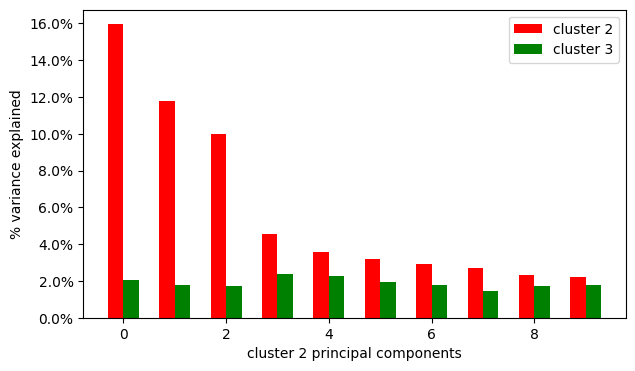

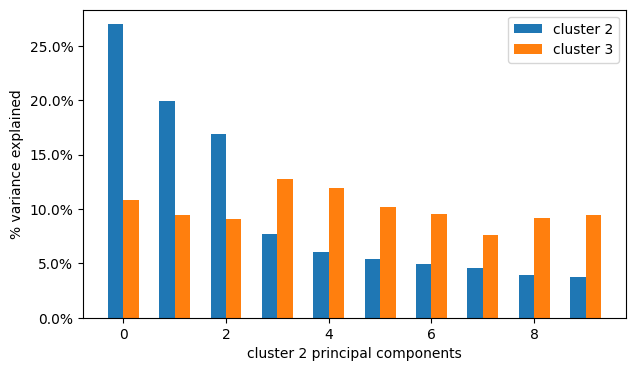

time: 588 ms (started: 2023-08-02 13:05:39 +01:00)


In [270]:
xpos = np.arange(len(var_explained_ratio_proj))
orig = f'{clust1}'
proj = f'{clust2}'

# relative to variance of original data (doesn't sum up to 100%)
plt.subplots(figsize=(7,4))
plt.bar(xpos-0.15, pca.explained_variance_ratio_,width=0.3, align='center', label=f'cluster {orig}', color='r')
plt.bar(xpos+0.15, var_explained_ratio_proj, width=0.3, align='center', label=f'cluster {proj}', color='g')
plt.legend()
plt.xlabel(f'cluster {orig} principal components')
plt.ylabel('% variance explained')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.show()

# relative to variance of explained by each component
tot_var = pca.explained_variance_.sum()
tot_var_proj = variance_projected_components.sum()

plt.subplots(figsize=(7,4))
plt.bar(xpos-0.15, pca.explained_variance_/tot_var,width=0.3, align='center', label=f'cluster {orig}')
plt.bar(xpos+0.15, variance_projected_components/tot_var_proj, width=0.3, align='center', label=f'cluster {proj}')
plt.legend()
plt.xlabel(f'cluster {orig} principal components')
plt.ylabel('% variance explained')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))


## Latent variables

In [ ]:
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -6, 21, rates=True)

target_index = trials_per_target(td_processed)
neuron_types = neuron_classes(clustering_solution)

lat_variables = get_all_latent_variables(td_processed, neuron_types, 10, target_index)

In [ ]:

for cluster in range(len(neuron_types)):
    row = 0
    col = 0
    fig, axs = plt.subplots(2,2, figsize=(8,6))
    fig.suptitle(f'latent variables of cluster {cluster}', x=0.5, y=0.98)
    for l_var in range(4):
        if col == 2:
            row += 1
            col = 0
        plot_latent_variables(lat_variables, target_index, cluster=cluster, l_var=l_var, ax=axs[row,col])
        axs[row,col].set_title(f'latent variable {l_var}')
        col += 1

In [ ]:
# apply PCA on neurons from whole dataset, not divided by cluster
clusters = len(neuron_types)
num_targets = np.shape(target_index)[0]
pca_dims = 10

lat_variables = {} # key is cluster number, values are latent variables for that cluster for all targets
lat_variables[f'{0}'] = [] # wirtten as cluster 0, but includes all neurons (kept format of clusters just to use the same functions)


# sampled_neurons = np.random.choice(list(range(len(clustering_solution))), size=100) # sample from whole dataset
spikes_data = merge_signals(td_processed, ["M1_rates", "PMd_rates"], "both_rates")
'''
for i in range(spikes_data.shape[0]): # for each trial
    spikes_data.both_rates[i] = spikes_data.both_rates[i] #[:, :]
'''
# PCA
spikes_data = dim_reduce(spikes_data, PCA(pca_dims), "both_rates", "both_pca")

for target in range(num_targets):  
    lat_variables[f'{0}'].append(get_lat_variables_per_target(target, spikes_data.both_pca, pca_dims, target_index))


In [ ]:
fig, axs = plt.subplots(5,2, figsize=(10,10))
fig.suptitle('latent variables applying PCA to all neurons', x=0.5, y=0.91)
row = 0
col = 0
for l_var in range(pca_dims):
    if col == 2:
        row += 1
        col = 0
    plot_latent_variables(lat_variables, target_index, cluster=0, l_var=l_var, ax=axs[row,col])
    axs[row,col].set_title('')
    col += 1

## Firing rate

/tmp/ipykernel_3058635/349108861.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td_processed.M1_spikes[j] = td_processed.M1_spikes[j][:, trials_to_keep_M1] # all rows corresponding to neurons with SNR>3
/tmp/ipykernel_3058635/349108861.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td_processed.PMd_spikes[j] = td_processed.PMd_spikes[j][:, trials_to_keep_PMd] # all rows corresponding to neurons with SNR>3
/tmp/ipykernel_3058635/349108861.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

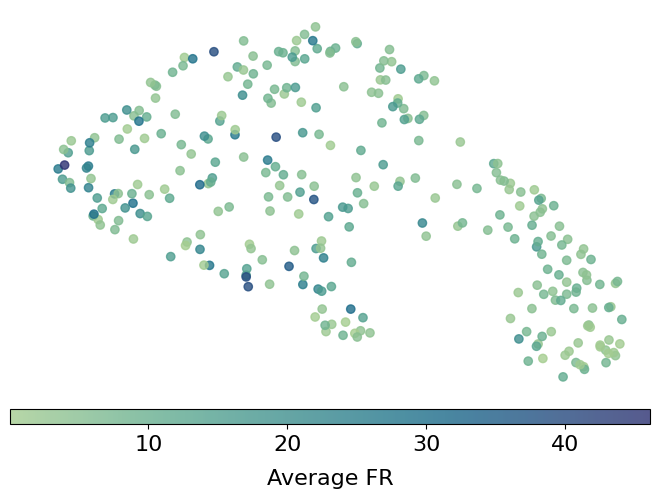

Text(0.5, 0, 'Neuorn class')

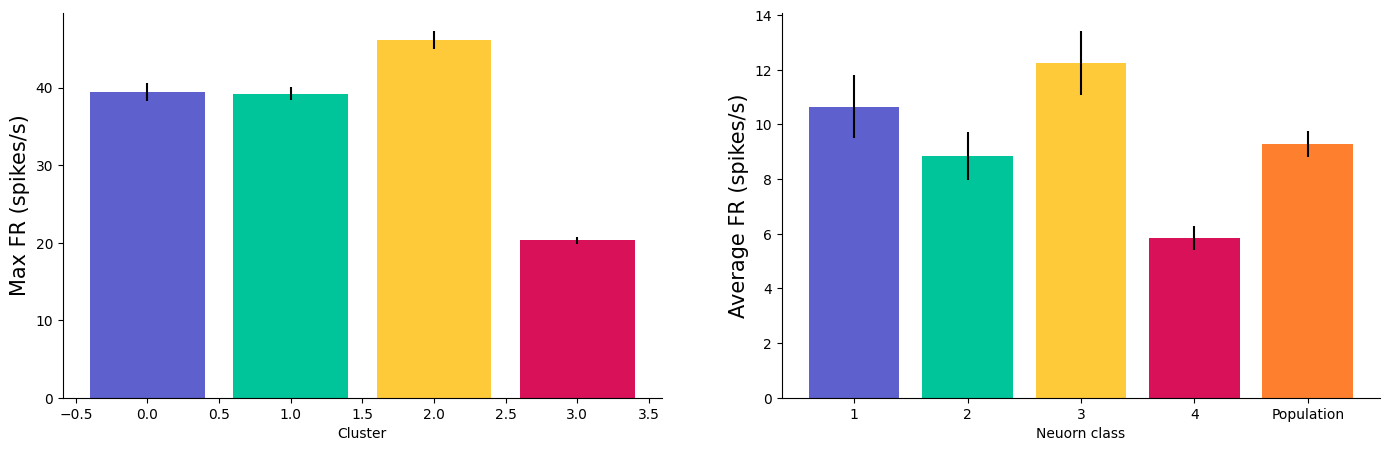

time: 695 ms (started: 2023-09-01 12:00:59 +01:00)


In [7]:
# for velocity decoding - movement period
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -6, 21, rates=False)
# for target classifier - preparation period
#td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -12, 2, rates=False)

overall_FR_mean, overall_FR_sme, avg_FR, sme_FR, max_FR = firing_rate_per_cluster(td_processed, clustering_solution)
plot_FR(umap_df, overall_FR_mean, overall_FR_sme, avg_FR, sme_FR, max_FR, plot_umap=True, plot_fr_cluster=True)
plt.xticks([0,1,2,3,4], labels = ['1','2','3','4','Population'])
plt.xlabel('Neuorn class')

In [40]:
overall_FR_sme

0.5864421446999788

time: 2.27 ms (started: 2023-08-30 10:00:40 +01:00)


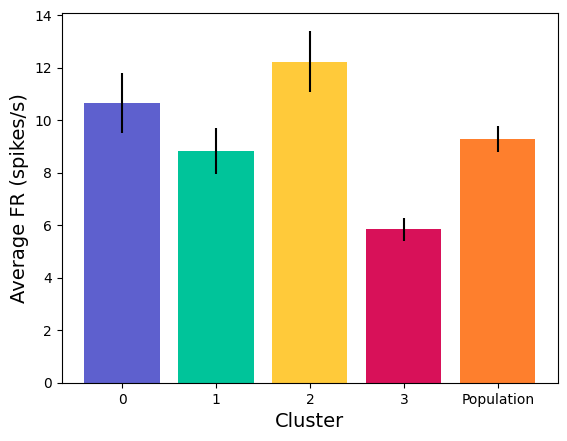

time: 82.1 ms (started: 2023-08-21 14:59:00 +01:00)


In [8]:
avg_fr_tot = np.append(avg_FR[:,0], overall_FR_mean)
sme_fr_tot = np.append(sme_FR[:,0], overall_FR_sme)
x_pos_fr = np.arange(len(avg_FR)+1)
plt.bar(x_pos_fr, avg_fr_tot, color = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9'], yerr=sme_fr_tot)
plt.ylabel('Average FR (spikes/s)',fontsize=14)
plt.xlabel('Cluster', fontsize=14)
plt.xticks([0,1,2,3,4], labels = ['0','1','2','3','Population']);
#plt.ylim([0,7.5])

In [ ]:
# match clusters
# maxValue = [2, 1, 0, 3]
avg_fr_ordered = order_array(avg_fr_tot, maxValue, axis='col')
sme_fr_ordered = order_array(sme_fr_tot, maxValue, axis='col')

avg_fr_ordered[-1] = overall_FR_mean
sme_fr_ordered[-1] = overall_FR_sme

x_pos_fr = np.arange(len(avg_FR)+1)
plt.bar(x_pos_fr, avg_fr_ordered, color = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9'], yerr=sme_fr_ordered)
plt.ylabel('Average FR (spikes/s)',fontsize=14)
plt.xlabel('Cluster', fontsize=14)
plt.xticks([0,1,2,3,4], labels = ['0','1','2','3','Population']);
#plt.title('Firing rate, dataset 2, matching clusters of dataset 1')
plt.ylim([0,16.5])

### properties per neuron

In [ ]:
td = preprocessing_general(data_spikes, combine=True, std=0.05)
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -6, 21, rates=False)

In [12]:
# compute average firing rate of each neuron in each cluster
rates = np.zeros((td_processed.both_rates.shape[0], td_processed.both_rates[0].shape[0], td_processed.both_rates[0].shape[1]))

for trial in range(td_processed.both_rates.shape[0]):
    rates[trial] = td_processed.both_rates[trial]
    
rates_avg = np.mean(rates, axis=0) # average across all trials
med_fr_per_neuron = np.mean(rates_avg, axis=0) # median fr of each neuron

# the lines before are the same as running this next line if I compute mean instead of median
fr_neurons = get_average_firing_rates(td_processed, "both_spikes",divide_by_bin_size=None) 

neuron_types = neuron_classes(clustering_solution)

time: 36.1 ms (started: 2023-08-27 22:35:21 +01:00)


/home/ad2022/MSc_project/PyalData/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


In [13]:
# compute average or median firing rate of each neuron in each cluster

fr_neurons_cluster = []
fr_median_cluster = [] # not used
percent = [] # not used
# select only neurons from specific cluster
for clust in range(len(neuron_types)):
    fr_neurons_cluster.append(fr_neurons[neuron_types[clust]]) # mean
    fr_median_cluster.append(med_fr_per_neuron[neuron_types[clust]]) # median
    percent.append(np.percentile(med_fr_per_neuron[neuron_types[clust]], 99)) # percent

time: 2.59 ms (started: 2023-08-27 22:35:34 +01:00)


/home/ad2022/MSc_project/PyalData/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


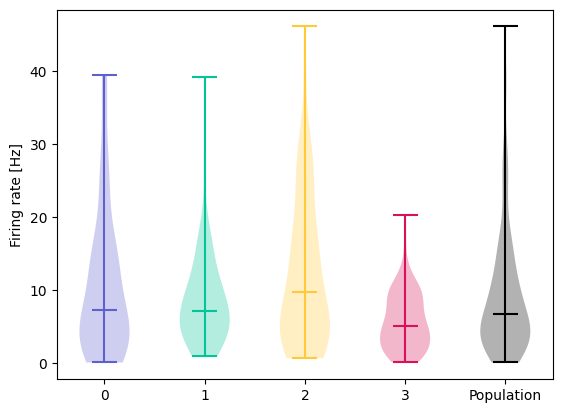

time: 103 ms (started: 2023-08-28 15:42:37 +01:00)


In [15]:
# violin plots
color = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9']
fr_neurons = get_average_firing_rates(td_processed, "both_spikes",divide_by_bin_size=None) 
neuron_types = neuron_classes(clustering_solution)


fig, ax = plt.subplots()
plot_violin(fr_neurons, neuron_types, color, 'Firing rate [Hz]', ax)

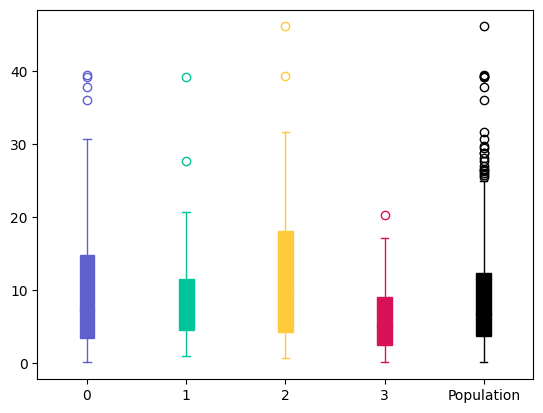

time: 79.2 ms (started: 2023-08-21 15:29:32 +01:00)


In [ ]:
# box plots
color = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9']

std_FR = np.zeros(len(neuron_types))
for clust in range(len(neuron_types)): # for each cluster
    fr_cluster = []
    for neuron in range(len(clustering_solution)): # for each neuron
        if(clustering_solution[neuron] == clust): # if neuron is in cluster 'clust'
            fr_cluster.append(fr_neurons[neuron]) # append firing rate of neuron

    std_FR[clust] = np.std(fr_cluster)

tot_neurons = td_processed.both_rates[0].shape[1]
for clust in range(len(neuron_types)):
    plt.boxplot(fr_neurons_cluster[clust], positions=[clust], patch_artist=True,
            boxprops=dict(facecolor=color[clust], color=color[clust]),
            capprops=dict(color=color[clust]),
            whiskerprops=dict(color=color[clust]),
            flierprops=dict(color=color[clust], markeredgecolor=color[clust]),
            medianprops=dict(color=color[clust]))
    #plt.plot(x_pos, fr_neurons_cluster[clust], 'o', markersize=3, c=color[clust], alpha=0.2)
    #plt.plot(x_pos, fr_median_cluster[clust], 'o', markersize=3, c=color[clust], alpha=0.2)
    #plt.errorbar(x_pos[0]+0.1, avg_FR[clust], yerr=std_FR[clust], marker='.', c=color[clust])
    #plt.hlines(avg_FR[clust], -1, 100, linestyles='solid', colors=color[clust], linewidth=1, label=f'clust={clust}, class mean')

clust += 1
#plt.plot(x_pos, np.concatenate(fr_median_cluster), 'o', markersize=3, c='k', alpha=0.2)
plt.boxplot(np.concatenate(fr_neurons_cluster), positions=[clust], patch_artist=True,
            boxprops=dict(facecolor='k', color='k'),
            capprops=dict(color='k'),
            whiskerprops=dict(color='k'),
            flierprops=dict(color='k', markeredgecolor='k'),
            medianprops=dict(color='k'))
#plt.errorbar(x_pos[0]+0.1, np.mean(avg_FR), yerr=np.std(fr_neurons), marker='.', c='k')
plt.xticks([0,1,2,3,4], labels = ['0','1','2','3','Population']);


#### Check firing rate patterns

In [ ]:
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -6, 21, rates=False)

In [57]:
rates = np.zeros((td_processed.both_rates.shape[0], td_processed.both_rates[0].shape[0], td_processed.both_rates[0].shape[1]))
rates = []
for trial in range(td_processed.both_rates.shape[0]):
    if td_processed.target_id[trial] == 3:
        rates.append(td_processed.both_rates[trial])
    #rates[trial] = td_processed.both_rates[trial]
    
rates_avg = np.mean(rates, axis=0) # average across all trials
print(np.min(rates_avg), np.max(rates_avg), np.mean(rates_avg), np.median(rates_avg))

-17.30841 30.308788 0.4729381 0.018707491
time: 8.51 ms (started: 2023-07-28 14:40:24 +01:00)


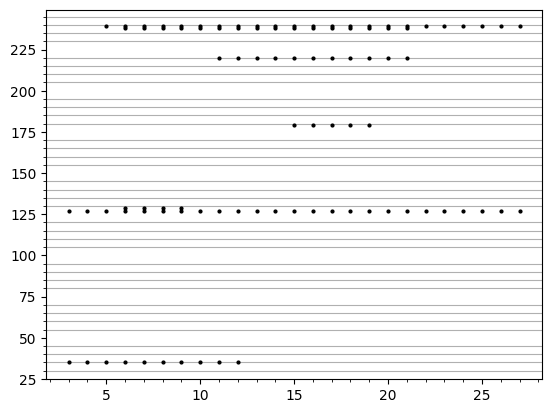

time: 211 ms (started: 2023-07-28 14:40:25 +01:00)


In [58]:
for neuron in range(rates_avg.shape[1]):
    for t in range(rates_avg.shape[0]):
        if rates_avg[t,neuron] >15:
            plt.plot(t, neuron, 'k.', ms=4)
plt.grid(axis='y', which='minor')
plt.minorticks_on()
plt.yticks(minor=True);

/home/ad2022/MSc_project/PyalData/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


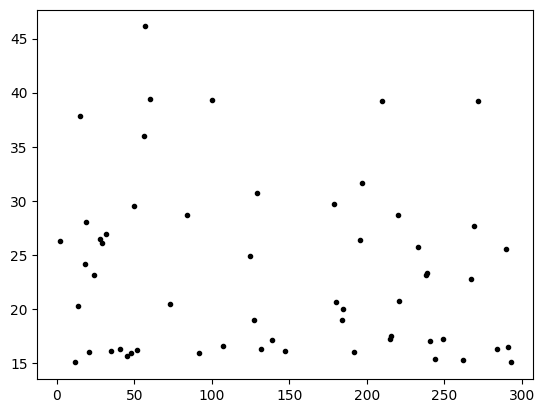

time: 116 ms (started: 2023-07-28 15:14:19 +01:00)


In [98]:
fr_neurons = get_average_firing_rates(td_processed, "both_spikes",divide_by_bin_size=None) 

for neuron in range(len(fr_neurons)):
    if fr_neurons[neuron] > 15:
        plt.plot(neuron, fr_neurons[neuron], 'k.')

In [60]:
td_processed.both_rates[0].shape # time x neurons
time = td_processed.both_rates[0].shape[0]
neurons = td_processed.both_rates[0].shape[1]

fr_sum = np.zeros((time, neurons))
for trial in range(td_processed.shape[0]):
    fr_sum += td_processed.both_rates[trial]

fr_avg = fr_sum/neurons

time: 10.8 ms (started: 2023-07-28 14:40:45 +01:00)


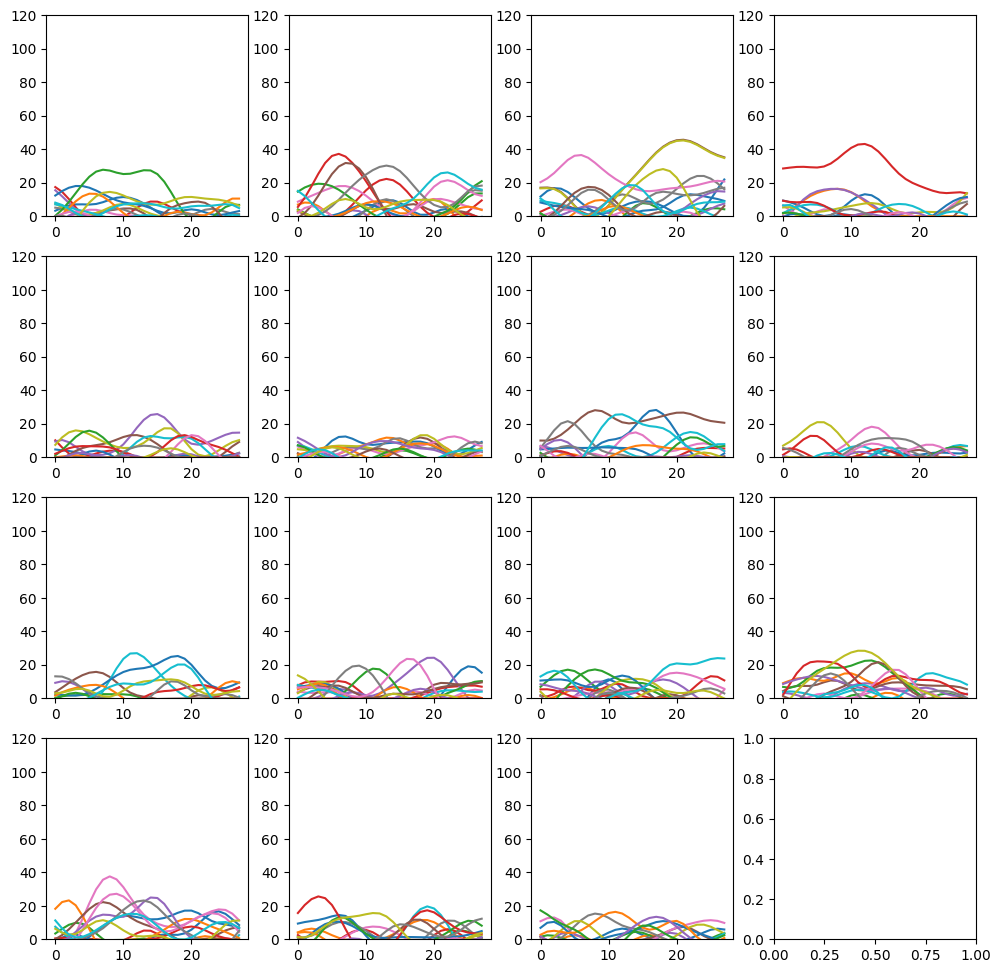

time: 971 ms (started: 2023-07-28 14:40:46 +01:00)


In [61]:
fr = td_processed.both_rates[1]
f,ax = plt.subplots(4,4, figsize=(12,12))
r = 0
c = 0
for i in range(15):
    if c == 4:
        c = 0
        r += 1
    ax[r,c].plot(fr[:,20*i:20*(i+1)]);
    ax[r,c].set_ylim([0,120])
    c += 1


## Peak to trough

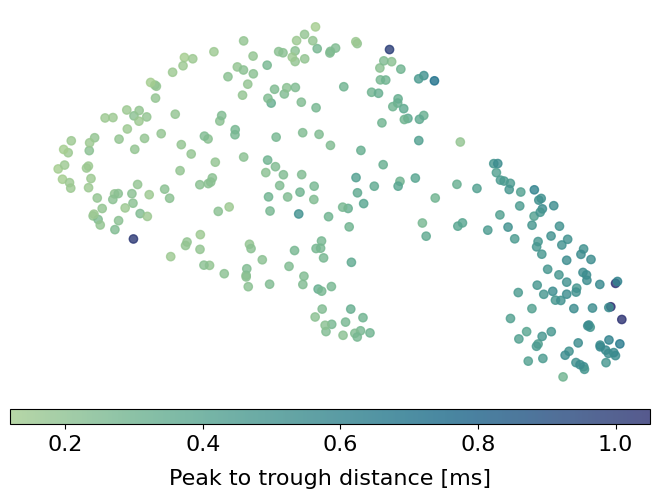

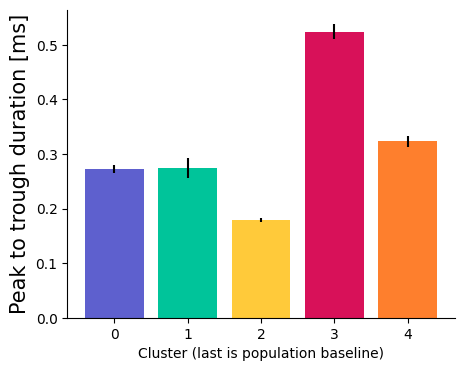

time: 152 ms (started: 2023-09-01 12:01:08 +01:00)


In [8]:
neuron_types = neuron_classes(clustering_solution)

mean_ptt, std_ptt, sme_ptt = peak_to_trough_per_cluster(umap_df, neuron_types)
ptt_overall = peak_to_trough_all(data_normalized)

plot_ptt(umap_df, ptt_overall, mean_ptt, sme_ptt, plot_umap=True, plot_ptt_cluster=True)


In [24]:
np.std(ptt_overall)/math.sqrt(len(ptt_overall))
#np.mean(ptt_overall)
mean_ptt

[0.24074999999999996,
 0.24967741935483873,
 0.3457142857142857,
 0.4105714285714286]

time: 2.33 ms (started: 2023-08-30 09:56:28 +01:00)


### ptt distribution per cluster

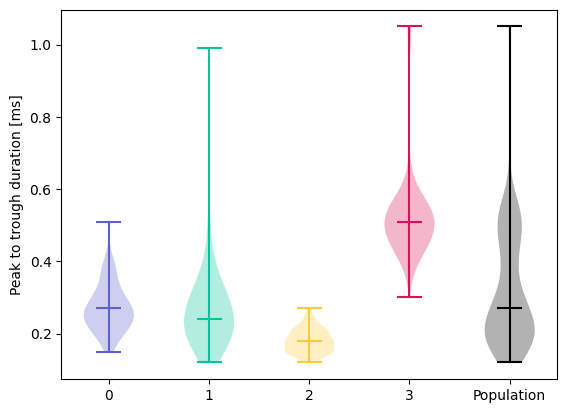

time: 92.9 ms (started: 2023-08-28 15:39:33 +01:00)


In [10]:
color = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9']
ptt_neurons = peak_to_trough_all(data_normalized)
neuron_types = neuron_classes(clustering_solution)


fig, ax = plt.subplots()
plot_violin(ptt_neurons, neuron_types, color, 'Peak to trough duration [ms]', ax)

## AP width

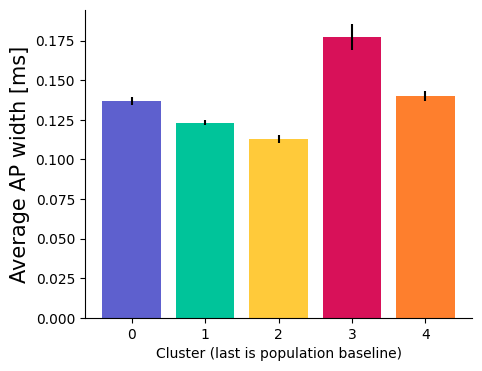

time: 94.9 ms (started: 2023-09-01 12:01:11 +01:00)


In [9]:
neuron_types = neuron_classes(clustering_solution)

meanAP, smeAP = AP_width_per_cluster(umap_df, neuron_types)
AP_all = AP_width_all(data_normalized)

plot_AP_width(umap_df, AP_all, meanAP, smeAP, plot_umap=False, plot_AP_cluster=True)


In [ ]:
np.std(AP_all)/math.sqrt(len(AP_all))
np.mean(AP_all)
smeAP

In [ ]:
# only to check it's correct (plot in fucntion)

for i in range(262,265):
    waveform = data_normalized[i]
    get_AP_width(waveform)


# LSTM for velocity decoding

In [50]:
#general preprocessing
td = preprocessing_general(data_spikes, combine=False)

time: 81.5 ms (started: 2023-08-30 10:14:41 +01:00)


In [ ]:
# number of neuorns in each cluster
num_neurons = neurons_in_cluster(clustering_solution)
num_neurons

## LSTM implementation

In [ ]:
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -4, 14, rates=True)



In [ ]:
neuron_types = neuron_classes(clustering_solution) # neuron in each cluster
rep = 10 # repeat 10 times
mean_R2s = np.zeros((rep,len(neuron_types)))
train_on_each_cluster = True
dataset = 'M17'

for cluster in range(len(neuron_types)): # for each cluster
    print(cluster)
    for z in range(rep):
        
        if dataset == 'C15':
            N_samples = 15
            pca_dims = 10
        elif dataset == 'C19':
            N_samples = 15
            pca_dims = 10
        elif dataset == 'M17':
            N_samples = 15
            pca_dims = 10
        elif dataset == 'M18':
            N_samples = 15
            pca_dims = 10
        
        if train_on_each_cluster:
            sampled_data = sample_neurons(neuron_types, N_samples)
            move_td = apply_PCA(td_processed, sampled_data, cluster, pca_dims)
        else:
            sampled_data = np.random.choice(list(range(len(clustering_solution))), size=N_samples) # sample from whole dataset
            move_td = apply_PCA(td_processed, sampled_data, -1, pca_dims)

        # define what time period to use spikes from (with respect to the output)
        bins_before = 6
        bins_current = 1 
        bins_after = 6

        neural_data = concat_trials(move_td, "both_pca")
        
        X = get_spikes_with_history(neural_data, bins_before, bins_after, bins_current)
        
        # only give info about magnitude of movement, but not direction
        #move_td.vel = abs(move_td.vel)
        y = concat_trials(move_td, "vel")

        training_range = [0, 0.7]
        testing_range = [0.7, 0.85]
        valid_range = [0.85,1]

        X_train, X_test, X_valid, y_train, y_test, y_valid = split_data(X, y, training_range, testing_range, valid_range,
                                                                         bins_before, bins_current, bins_after, flat=False, zero_center=True)

        #Declare model
        model_lstm = LSTMDecoder(units=400,dropout=0,num_epochs=5)

        #Fit model
        model_lstm.fit(X_train,y_train)

        #Get predictions
        y_valid_predicted_lstm =  model_lstm.predict(X_valid)

        #Get metric of fit
        R2s_lstm = get_R2(y_valid,y_valid_predicted_lstm)
        mean_R2s[z,cluster] = np.mean(R2s_lstm)
        

In [56]:
mean_R2s

array([[ 0.10414619,  0.35292097,  0.45921684, -0.28487511],
       [ 0.48001257,  0.42906365,  0.44177819,  0.24678111],
       [ 0.55937506,  0.4529264 ,  0.28369994,  0.3248124 ],
       [ 0.63331642,  0.45325204,  0.0650452 ,  0.3287076 ],
       [ 0.25087665,  0.51775143, -0.02442328, -0.11037316],
       [ 0.64943244,  0.47360671,  0.00314953,  0.10235919],
       [ 0.58783573,  0.37221549,  0.23686809,  0.18241225],
       [ 0.69975061,  0.64995401,  0.07451837,  0.18787027],
       [ 0.60746911,  0.59156793,  0.15591757,  0.4934848 ],
       [ 0.39102454,  0.51586562,  0.30509955, -0.0932007 ]])

time: 2.73 ms (started: 2023-08-30 10:26:46 +01:00)


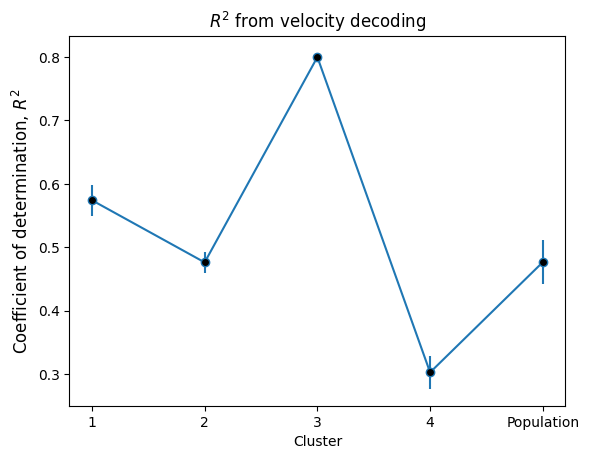

time: 80.1 ms (started: 2023-08-03 12:37:29 +01:00)


In [119]:
# R2 from each cluster
r2 =[]

# R2 sampling neurons randomly from dataset
r2_all = []

plt.plot()
r2_mean, r2_sme = plot_R2(r2, r2_all)
#_, _ = plot_R2(r2_old, r2_all_old)
plt.title(r'$R^2$ from velocity decoding')
plt.xticks([0,1,2,3,4], labels = ['1','2','3','4','Population'])
plt.xlabel('Cluster')
plt.show()

In [ ]:
neuron_types = neuron_classes(clustering_solution)
for clust in range(len(neuron_types)):
  sns.kdeplot(data=np.array(r2)[:,clust], c = CUSTOM_PAL_SORT[clust])

#sns.despine(offset={'left': 10})
plt.xlabel('Coefficient of Determination')
plt.legend(['0','1','2','3','4','5','6'])
plt.show()

In [ ]:
# Example: plot 1000 values of the x velocity (column index 0), both true and predicted
#Note: add back the mean value, so that both true and predicted values are in the original coordinates

plt.figure(figsize=(15,10))
plt.plot(y_valid[1000:2000,0] + np.mean(y_train,axis=0)[0], c = 'k')
plt.plot(y_valid_predicted_lstm[1000:2000,0] + np.mean(y_train,axis=0)[0], c = CUSTOM_PAL_SORT[0])
sns.despine(offset={'left': 10})
plt.xlabel('Time (bins)')
plt.ylabel('Velocity (cm/s)')
plt.legend(['True Value', 'Predicted'])
#Save figure
# fig_x_wf.savefig('x_velocity_decoding.eps')

## Vel R2 vs physiological properties

In [ ]:
fr_mean = np.append(avg_FR, overall_FR_mean)
fr_sme = np.append(sme_FR, overall_FR_sme)
plot_R2_vs_property(r2_mean, r2_sme, fr_mean, fr_sme, CUSTOM_PAL_SORT, 'Average firing rate [spikes/sec]')

ptt_overall_sme = np.std(ptt_overall)/math.sqrt(len(ptt_overall))
ptt_overall_mean = np.mean(ptt_overall)        
ptt_mean = np.append(mean_ptt, ptt_overall_mean)
ptt_sme = np.append(sme_ptt, ptt_overall_sme)
plot_R2_vs_property(r2_mean, r2_sme, ptt_mean, ptt_sme, CUSTOM_PAL_SORT, 'Average peak to trough duration [ms]')

AP_all_sme = np.std(AP_all)/math.sqrt(len(AP_all))
AP_all_mean = np.mean(AP_all)
AP_mean = np.append(meanAP, AP_all_mean)
AP_sme = np.append(smeAP, AP_all_sme)
plot_R2_vs_property(r2_mean, r2_sme, AP_mean, AP_sme, CUSTOM_PAL_SORT, 'Average AP width [ms]')


## Merge clusters to compare results

In [ ]:
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_go_cue", 0, 50, rates=True)

neuron_types = neuron_classes(clustering_solution) # neuron in each cluster
rep = 1 
clusters = len(neuron_types)
merged_clusters_R2 = np.zeros((clusters, clusters)) # each entry is merged classes i and j

for clust1 in range(2,len(neuron_types)-3):
    print('cluster1', clust1)
    for clust2 in range(4, len(neuron_types)):
        for z in range(rep):
            
            N_samples = 20 # number of dimensions
            sampled_data = sample_neurons(neuron_types, N_samples)

            if clust1 == clust2:
                # one cluster only
                merged_sampled = sampled_data[clust1]
            else:
                # merge neurons from two clusters
                merged_sampled = sampled_data[clust1] + sampled_data[clust2]

            pca_dims = 10

            move_td = apply_PCA(td_processed, merged_sampled, -1, pca_dims) # -1 becasue merged_sampled contains exactly neurons to be used

            # define what time period to use spikes from (with respect to the output)
            bins_before = 6
            bins_current = 1 
            bins_after = 6

            neural_data = concat_trials(move_td, "both_pca")
            X = get_spikes_with_history(neural_data, bins_before, bins_after, bins_current)

            y = concat_trials(move_td, "vel")

            training_range = [0, 0.7]
            testing_range = [0.7, 0.85]
            valid_range = [0.85,1]

            X_train, X_test, X_valid, y_train, y_test, y_valid = split_data(X, y, training_range, testing_range, valid_range,
                                                                             bins_before, bins_current, bins_after, flat=False, zero_center=True)

            #Declare model
            model_lstm = LSTMDecoder(units=400,dropout=0,num_epochs=5)

            #Fit model
            model_lstm.fit(X_train,y_train)

            #Get predictions
            y_valid_predicted_lstm =  model_lstm.predict(X_valid)

            #Get metric of fit
            R2s_lstm = get_R2(y_valid,y_valid_predicted_lstm)
            merged_clusters_R2[clust1, clust2] = np.mean(R2s_lstm)


In [ ]:
merged_clusters_R2

In [ ]:
# FOR 7 CLUSTERS
merged_R21 = [[0.31356388, 0.53910819, 0.62185964, 0.53952831, 0.69207032, 0.4284642 , 0.51938458],
             [0.51762842, 0.52426007, 0.67029033, 0.53670199, 0.7651432 , 0.4496275 , 0.63689196],
             [0.66456706, 0.58560515, 0.67171242, 0.69439759, 0.79131112, 0.45166835, 0.58359863],
             [0.5117668 , 0.72072768, 0.54328223, 0.48035235, 0.74051948, 0.54061063, 0.60846111],
             [0.68521771, 0.6995674 , 0.78072578, 0.75929914, 0.72785953, 0.74586523, 0.77890921],
             [0.31137418, 0.45439449, 0.48519976, 0.51405658, 0.75496004, 0.15579142, 0.48179289],
             [0.34607596, 0.63821785, 0.65726468, 0.53673582, 0.76222767, 0.34821236, 0.41261089]]

merged_R22 = [[0.10182948, 0.58031749, 0.41597789, 0.60386816, 0.63928119, 0.11820055, 0.34310259],
               [0.40803692, 0.51892097, 0.53632417, 0.7640033 , 0.79654782, 0.52167557, 0.57429857],
               [0.57751051, 0.7250866 , 0.6486738, 0.47461311, 0.78000864, 0.69857848, 0.5608692 ],
               [0.58835034, 0.67198144, 0.64884425, 0.52379478, 0.72506621, 0.60080508, 0.49299787],
               [0.73951051, 0.78548501, 0.79129108, 0.64470345, 0.76392975, 0.71421078, 0.75303989],
               [0.22199594, 0.40092782, 0.64489051, 0.49759734, 0.73266527, 0.08798056, 0.37106796],
               [0.47826976, 0.52149477, 0.67693727, 0.55445005, 0.78568993, 0.4621806 , 0.41840401]]


merged_R2 = np.mean([merged_R21, merged_R22], axis=0)

# doesn't matter order how they were merged -> merge 1 and 2 == merge 2 and 1
for i in range(merged_R2.shape[0]):
    for j in range(merged_R2.shape[1]):
        if j<i: continue
        merged_R2[i][j] = (merged_R2[i][j] + merged_R2[j][i])/2

for i in range(merged_R2.shape[0]):
    for j in range(merged_R2.shape[1]):
        if j<i: merged_R2[i][j] = 0

        
idx = pd.Index(np.arange(7))
df = pd.DataFrame(merged_R2, index=idx, columns=idx)
vals = np.around(df.values,3)
colours = plt.cm.hot(1-vals)

plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, colWidths=[1/7]*vals.shape[1],
           loc='center', cellColours=colours, bbox=[0,0,1,1], colColours=CUSTOM_PAL_SORT)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
sns.heatmap(merged_R2, annot=True, fmt='.2g')

In [ ]:
# FOR 6 CLUSTERS
merged_R21 = [[0.24678465, 0.72113081, 0.69931199, 0.7656744 , 0.59495533, 0.56717285],
              [0.59429029, 0.45632428, 0.65172791, 0.73582262, 0.48845024, 0.55756412],
              [0.70320591, 0.61514188, 0.67925683, 0.75746298, 0.67334221, 0.41092615],
              [0.76620059, 0.64448804, 0.81593852, 0.77357629, 0.6900217 , 0.74101563],
              [0.53862069, 0.58820508, 0.66550315, 0.74770125, 0.27889321, 0.13872467],
              [0.48113363, 0.5816714 , 0.66787273, 0.68089521, 0.50633155, 0.26608831]]

merged_R22 = [[ 0.52745906,  0.59890986,  0.71538072,  0.79882773,  0.52637662, 0.48175944],
              [ 0.68377196,  0.44608737,  0.62673714,  0.68275535,  0.63245307, 0.51098512],
              [ 0.60329737,  0.64913147,  0.47236046,  0.84646782,  0.56176423, 0.54666219],
              [ 0.7965014 ,  0.7030533 ,  0.75064539,  0.72915266,  0.78576719, 0.7072867 ],
              [ 0.28542138,  0.52972954,  0.46238081,  0.72326211,  0.33478652, 0.40259581],
              [ 0.462211  ,  0.52572299,  0.50770113,  0.67507588,  0.2969167 , -0.06860268]]

merged_R2 = np.mean([merged_R21, merged_R22], axis=0)

# doesn't matter order how they were merged -> merge 1 and 2 == merge 2 and 1
for i in range(merged_R2.shape[0]):
    for j in range(merged_R2.shape[1]):
        if j<i: continue
        merged_R2[i][j] = (merged_R2[i][j] + merged_R2[j][i])/2

for i in range(merged_R2.shape[0]):
    for j in range(merged_R2.shape[1]):
        if j<i: merged_R2[i][j] = 0

        
idx = pd.Index(np.arange(len(neuron_types)))
df = pd.DataFrame(merged_R2, index=idx, columns=idx)
vals = np.around(df.values,3)
colours = plt.cm.hot(1-vals)

plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, colWidths=[1/7]*vals.shape[1],
           loc='center', cellColours=colours, bbox=[0,0,1,1], colColours=CUSTOM_PAL_SORT)
plt.xticks([])
plt.yticks([])
plt.show()

# Target Classifier

In [ ]:
# correct interval
td = preprocessing_general(data_spikes, combine=False)
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -12, 2, rates=True)


In [ ]:
neurons = neurons_in_cluster(clustering_solution)
neurons

## LSTM for target classifier

In [ ]:
# DON'T USE THIS
neuron_types = neuron_classes(clustering_solution) # neuron in each cluster
rep = 10 # repeat 10 times
accuracies = np.zeros((rep,len(neuron_types)))
train_on_each_cluster = True
#min_pca_dims = [59, 51, 55]
dataset = 'C19'

for cluster in range(len(neuron_types)): # for each cluster
    print('cluster', cluster)
    for z in range(rep):
        
        if dataset == 'C15':
            N_samples = 15
            pca_dims = 10
        elif dataset == 'C19':
            N_samples = 15
            pca_dims = 10
        elif dataset == 'M17':
            N_samples = 15
            pca_dims = 10
        elif dataset == 'M18':
            N_samples = 20
            pca_dims = 11
        
        if train_on_each_cluster:
            sampled_data = sample_neurons(neuron_types, N_samples)
            move_td = apply_PCA(td_processed, sampled_data, cluster, pca_dims)
        else:
            sampled_data = np.random.choice(list(range(len(clustering_solution))), size=N_samples) # sample from whole dataset
            move_td = apply_PCA(td_processed, sampled_data, -1, pca_dims)
        
        # define what time period to use spikes from (with respect to the output)
        bins_before = 6
        bins_current = 1 
        bins_after = 6

        y = []
        neural_spikes = []
        for i in range(move_td.shape[0]):
            y.append(move_td.target_id[i])
            neural_spikes.append(move_td.both_pca[i])

        y = np.array(y)
        X = np.array(neural_spikes)

        training_range = [0, 0.7]
        testing_range = [0.7, 0.85]
        valid_range = [0.85,1]

        X_train, X_test, X_valid, y_train, y_test, y_valid = split_data(X, y, training_range, testing_range, valid_range,
                                                                         bins_before, bins_current, bins_after, flat=False, zero_center=False)

        #Declare model
        LSTM_classifier = LSTMClassification(units=100, dropout=0, num_epochs=10)

        #Fit model
        LSTM_classifier.fit(X_train, y_train)

        #Get predictions
        y_predicitons =  LSTM_classifier.predict(X_valid)

        #Get metric of fit
        accuracy = np.sum(y_predicitons == y_valid) / float(len(y_predicitons))
        accuracies[z,cluster] = accuracy


In [ ]:
accuracies

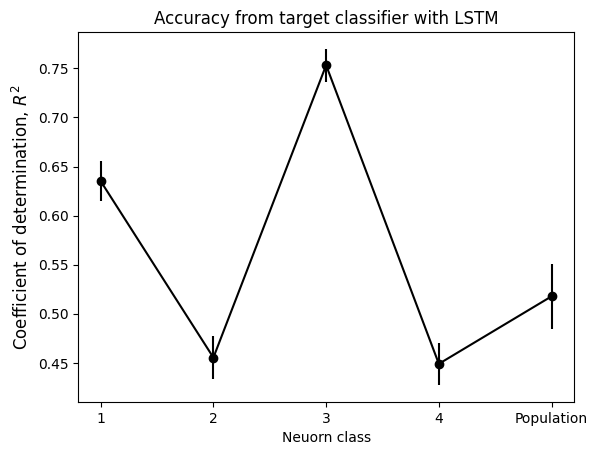

time: 79 ms (started: 2023-08-30 12:46:21 +01:00)


In [ ]:
# R2 from each cluster
acc = []
# acc sampling neurons randomly from dataset
acc_all = []

acc_meanLSTM, acc_smeLSTM = plot_R2(acc, acc_all)
#_, _ = plot_R2(acc_old, acc_all_old)
plt.title('Accuracy from target classifier with LSTM')
plt.xticks([0,1,2,3,4], labels = ['1','2','3','4','Population'])
plt.xlabel('Neuorn class')
#plt.legend(['New interval', 'Old interval'])
plt.show()

### Target CLassifier with LSTM on mean PCA value

In [ ]:
neuron_types = neuron_classes(clustering_solution) # neuron in each cluster
rep = 3 # repeat 10 times
accuracies = np.zeros((rep,len(neuron_types)))
train_on_each_cluster = False

# dataset = 'C19'
N_samples = 15
pca_dims = 10

for cluster in range(len(neuron_types)): # for each cluster
    print('cluster', cluster)
    for z in range(rep):
        
        '''
        if dataset == 'C15':
            N_samples = 15
            pca_dims = 10
        elif dataset == 'C19':
            N_samples = 15
            pca_dims = 10
        elif dataset == 'M17':
            N_samples = 15
            pca_dims = 10
        elif dataset == 'M18':
            N_samples = 15
            pca_dims = 10
        '''
        
        if train_on_each_cluster:
            sampled_data = sample_neurons(neuron_types, N_samples)
            move_td = apply_PCA(td_processed, sampled_data, cluster, pca_dims)
        else:
            sampled_data = np.random.choice(list(range(len(clustering_solution))), size=N_samples) # sample from whole dataset
            move_td = apply_PCA(td_processed, sampled_data, -1, pca_dims)
        
        # define what time period to use spikes from (with respect to the output)
        bins_before = 6
        bins_current = 1 
        bins_after = 6

        y = []
        neural_spikes = []
        for i in range(move_td.shape[0]):
            y.append(move_td.target_id[i])
            #neural_spikes.append(move_td.both_pca[i])
            neural_spikes.append(np.mean(move_td.both_pca[i], axis=0))

        y = np.array(y)
        X = np.array(neural_spikes)

        training_range = [0, 0.7]
        testing_range = [0.7, 0.85]
        valid_range = [0.85,1]

        X_train, X_test, X_valid, y_train, y_test, y_valid = split_data(X, y, training_range, testing_range, valid_range,
                                                                         bins_before, bins_current, bins_after, flat=False, zero_center=False)

        X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
        #X_test = X_test.reshape(1, X_test.shape[0], X_test.shape[1])
        X_valid = X_valid.reshape(X_valid.shape[0], 1, X_valid.shape[1])
        
        #y_train = y_train.reshape(y_train.shape[0])
        #y_test = y_test.reshape(1, y_test.shape[0])
        #y_valid = y_valid.reshape(y_valid.shape[0])
        
        #Declare model
        LSTM_classifier = LSTMClassification(units=100, dropout=0, num_epochs=10)

        #Fit model
        LSTM_classifier.fit(X_train, y_train)

        #Get predictions
        y_predicitons =  LSTM_classifier.predict(X_valid)
        
        #Get metric of fit
        accuracy = np.sum(y_predicitons == y_valid) / float(len(y_predicitons))
        accuracies[z,cluster] = accuracy


In [72]:
accuracies

array([[0.59090909, 0.54545455, 0.45454545, 0.40909091],
       [0.5       , 0.5       , 0.59090909, 0.45454545],
       [0.36363636, 0.40909091, 0.5       , 0.5       ]])

time: 2.41 ms (started: 2023-08-30 10:41:45 +01:00)


In [ ]:
# R2 from each cluster


acc = [[0.54545455, 0.86363636, 0.59090909, 0.81818182],
       [0.40909091, 0.77272727, 0.54545455, 0.77272727],
       [0.54545455, 0.5       , 0.40909091, 0.5       ],
       [0.45454545, 0.5       , 0.36363636, 0.54545455],
       [0.5       , 0.59090909, 0.54545455, 0.77272727],
       [0.63636364, 0.40909091, 0.54545455, 0.59090909],
       [0.59090909, 0.63636364, 0.36363636, 0.59090909],
       [0.54545455, 0.59090909, 0.45454545, 0.54545455],
       [0.68181818, 0.31818182, 0.27272727, 0.59090909],
       [0.45454545, 0.68181818, 0.40909091, 0.81818182]]

# acc sampling neurons randomly from dataset

acc_all = [0.54545455, 0.45454545, 0.54545455, 0.59090909, 0.5,
           0.5, 0.77272727, 0.59090909, 0.40909091, 0.68181818,
           0.72727273, 0.68181818]

acc_meanLSTM, acc_smeLSTM = plot_R2(acc, acc_all)
#acc_meanLSTM, acc_smeLSTM = plot_R2(acc_avg, acc_all_avg)
plt.title('Accuracy from target classifier with LSTM')
plt.xticks([0,1,2,3,4], labels = ['1','2','3','4','Population'])
plt.xlabel('Neuorn class')
#plt.legend(['normal pca', 'avg pca'])
plt.show()

### Target accuracy and physiological properties

In [ ]:
fr_mean = np.append(avg_FR, overall_FR_mean)
fr_sme = np.append(sme_FR, overall_FR_sme)
plot_R2_vs_property(acc_meanLSTM, acc_smeLSTM, fr_mean, fr_sme, CUSTOM_PAL_SORT, 'Average firing rate [spikes/sec]')

ptt_overall_sme = np.std(ptt_overall)/math.sqrt(len(ptt_overall))
ptt_overall_mean = np.mean(ptt_overall)
ptt_mean = np.append(mean_ptt, ptt_overall_mean)
ptt_sme = np.append(sme_ptt, ptt_overall_sme)
plot_R2_vs_property(acc_meanLSTM, acc_smeLSTM, ptt_mean, ptt_sme, CUSTOM_PAL_SORT, 'Average peak to trough duration [ms]')

AP_all_sme = np.std(AP_all)/math.sqrt(len(AP_all))
AP_all_mean = np.mean(AP_all)
AP_mean = np.append(meanAP, AP_all_mean)
AP_sme = np.append(smeAP, AP_all_sme)
plot_R2_vs_property(acc_meanLSTM, acc_smeLSTM, AP_mean, AP_sme, CUSTOM_PAL_SORT, 'Average AP width [ms]')


## Optimal parameters

In [ ]:
neuron_types = neuron_classes(clustering_solution) # neuron in each cluster
rep = 2 # repeat 10 times
accuracies = np.zeros((rep,len(neuron_types)))
train_on_each_cluster = False

dataset = 'C19'
N_samples = 15
pca_dims = 10
avg_acc = []
std_acc = []
parameters = np.arange(5, 51, 5)

for param in parameters:
    print('param', param)
    for cluster in range(len(neuron_types)): # for each cluster
        print('cluster', cluster)
        for z in range(rep):
            #print('cluster', cluster, z)

            if train_on_each_cluster:
                sampled_data = sample_neurons(neuron_types, N_samples)
                move_td = apply_PCA(td_processed, sampled_data, cluster, pca_dims)
            else:
                sampled_data = np.random.choice(list(range(len(clustering_solution))), size=N_samples) # sample from whole dataset
                move_td = apply_PCA(td_processed, sampled_data, -1, pca_dims)

            # define what time period to use spikes from (with respect to the output)
            bins_before = 6
            bins_current = 1 
            bins_after = 6

            y = []
            neural_spikes = []
            for i in range(move_td.shape[0]):
                y.append(move_td.target_id[i])
                #neural_spikes.append(move_td.both_pca[i])
                neural_spikes.append(np.mean(move_td.both_pca[i], axis=0))

            y = np.array(y)
            X = np.array(neural_spikes)

            training_range = [0, 0.7]
            testing_range = [0.7, 0.85]
            valid_range = [0.85,1]

            X_train, X_test, X_valid, y_train, y_test, y_valid = split_data(X, y, training_range, testing_range, valid_range,
                                                                             bins_before, bins_current, bins_after, flat=False, zero_center=False)

            X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
            #X_test = X_test.reshape(1, X_test.shape[0], X_test.shape[1])
            X_valid = X_valid.reshape(X_valid.shape[0], 1, X_valid.shape[1])

            #y_train = y_train.reshape(y_train.shape[0])
            #y_test = y_test.reshape(1, y_test.shape[0])
            #y_valid = y_valid.reshape(y_valid.shape[0])

            #Declare model
            #LSTM_classifier = LSTMClassification(units=100, dropout=0, num_epochs=10)
            LSTM_classifier = LSTMClassification(units=100, dropout=0, num_epochs=param)

            #Fit model
            LSTM_classifier.fit(X_train, y_train)

            #Get predictions
            y_predicitons =  LSTM_classifier.predict(X_valid)

            #Get metric of fit
            accuracy = np.sum(y_predicitons == y_valid) / float(len(y_predicitons))
            accuracies[z,cluster] = accuracy
    avg_acc.append(np.mean(accuracies))
    std_acc.append(np.std(accuracies))


In [ ]:
# split by cluster
avg_acc = [0.410625, 0.41187499999999994, 0.4125, 0.44749999999999995, 0.445,
 0.46187500000000004, 0.49000000000000005, 0.4618749999999999, 0.46875, 0.46374999999999994,
 0.47250000000000003, 0.440625, 0.4531250000000001, 0.46375, 0.46437499999999987, 0.46749999999999997]

std_acc = [0.10126350218612824, 0.09466016519634857, 0.09714679613862723, 0.11487765230888032,
 0.1005764634494572, 0.11808861873610005, 0.1115655636834234, 0.09854210711670418,
 0.11106726565464732, 0.09608752520488806, 0.11842719282327013, 0.09761811755509323,
 0.10996270674642382, 0.09419892515310353, 0.10072200293381778, 0.07195918982312127]

# not split by cluster
avg_acc = [0.4296875, 0.4390625, 0.4203125,0.459375, 0.47500000000000003, 0.453125,
 0.49687499999999996, 0.4921875, 0.49843750000000003, 0.47343750000000007, 0.528125,
 0.503125, 0.4953125, 0.4828125, 0.4625, 0.484375]

std_acc = [0.0548212649776526, 0.09258389354390967, 0.05691876750027182, 0.07545435292281022,
 0.08838834764831846, 0.10546585644178878, 0.07849910429425294, 0.06582929510294032,
 0.08737435175009885, 0.07640289486498532, 0.07467376965842826, 0.08518133231524382,
 0.15115925738686997, 0.06279228530440661, 0.07342087577794207, 0.07119241093684074]

In [ ]:
std_acc

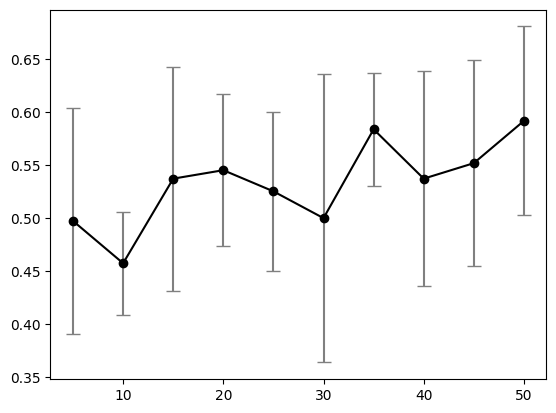

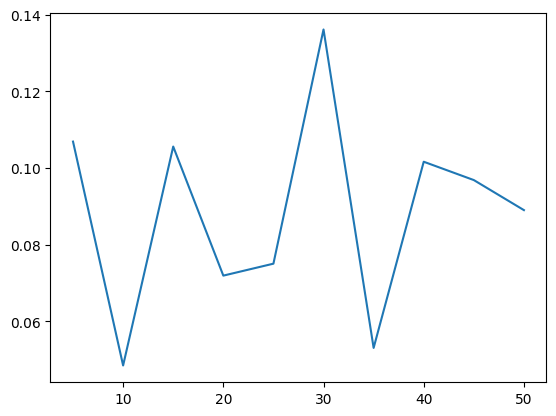

time: 143 ms (started: 2023-08-23 16:17:34 +01:00)


In [36]:
plt.errorbar(parameters, avg_acc, yerr=std_acc, c='k', marker='o', ecolor='gray', capsize=5)
plt.show()
plt.plot(parameters, std_acc)

## Naive Bayes for target classifier

In [ ]:
neuron_types = neuron_classes(clustering_solution) # neuron in each cluster
rep = 10 # repeat 10 times
accuraciesGNB = np.zeros((rep,len(neuron_types)))
train_on_each_cluster = True
dataset = 2

for cluster in range(len(neuron_types)): # for each cluster
    print('cluster', cluster)
    for z in range(rep):
        
        if dataset == 1:
            N_samples = 20 # 20 for 6,7 clusters, 20 for 4 clusters, 70 for 3 clusters
            pca_dims = 11 # 10 for 6,7 clusters, 11 for 4 clusters, 52 for 3 clusters
            # pca_dims = np.round(0.9*min_pca_dims[cluster])
        elif dataset == 2:
            N_samples = 45 # 20 for 6,7 clusters, 45 for 4 clusters, - for 3 clusters
            pca_dims = 30 # 10 for 6,7 clusters, 30 for 4 clusters, - for 3 clusters
        
        if train_on_each_cluster:
            sampled_data = sample_neurons(neuron_types, N_samples)
            move_td = apply_PCA(td_processed, sampled_data, cluster, pca_dims)
        else:
            sampled_data = np.random.choice(list(range(len(clustering_solution))), size=N_samples) # sample from whole dataset
            move_td = apply_PCA(td_processed, sampled_data, -1, pca_dims)

        
        # define what time period to use spikes from (with respect to the output)
        bins_before = 6
        bins_current = 1 
        bins_after = 6

        y = []
        neural_spikes = []
        for i in range(move_td.shape[0]):
            y.append(move_td.target_id[i]) # without repeating
            neural_spikes.append(move_td.both_pca[i])

        y = np.array(y)
        X = np.array(neural_spikes)

        training_range = [0, 0.7]
        testing_range = [0.7, 0.85]
        valid_range = [0.85,1]

        X_train, X_test, X_valid, y_train, y_test, y_valid = split_data(X, y, training_range, testing_range, valid_range,
                                                                         bins_before, bins_current, bins_after, flat=True, zero_center=False)

        #Declare model
        GNB_classifier = GaussianNB()

        #Fit model
        GNB_classifier.fit(X_train,y_train)

        #Get predictions
        y_predicitons =  GNB_classifier.predict(X_valid)

        #Get metric of fit
        accuracy = np.sum(y_predicitons == y_valid) / float(len(y_predicitons))
        accuraciesGNB[z,cluster] = accuracy


In [ ]:
accuraciesGNB

Text(0.5, 1.0, 'Accuracy from target classifier with Naive Bayes Classifier')

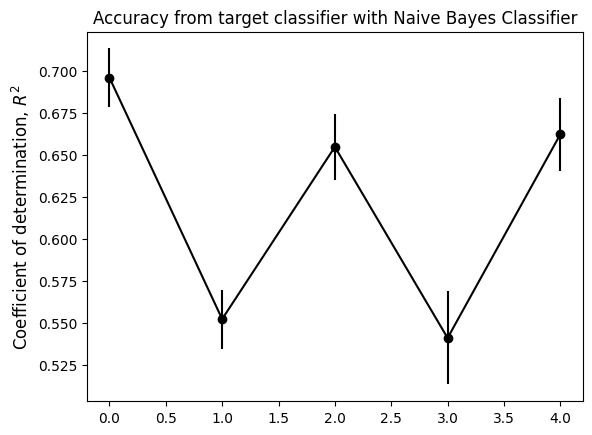

time: 239 ms (started: 2023-09-01 12:01:27 +01:00)


In [10]:
# accuracy from each cluster
accGNB = [[0.6875, 0.5375, 0.725 , 0.575 ],
       [0.7875, 0.575 , 0.7125, 0.5125],
       [0.7   , 0.5   , 0.7   , 0.575 ],
       [0.6375, 0.5125, 0.5375, 0.575 ],
       [0.75  , 0.4625, 0.625 , 0.5375],
       [0.5875, 0.55  , 0.75  , 0.5875],
       [0.675 , 0.675 , 0.6   , 0.675 ],
       [0.7375, 0.5875, 0.6375, 0.475 ],
       [0.725 , 0.5375, 0.6125, 0.575 ],
       [0.675 , 0.5875, 0.65  , 0.325 ]]

# acc sampling neurons randomly from dataset
acc_allGNB = [0.6375, 0.5875, 0.7625, 0.5375, 0.65  ,
              0.7375, 0.7   , 0.7375, 0.6625, 0.6125]

acc_meanGNB, acc_smeGNB = plot_R2(accGNB, acc_allGNB)
plt.title('Accuracy from target classifier with Naive Bayes Classifier')


### Target accuracy and physiological properties

NameError: name 'ptt_overall_mean' is not defined

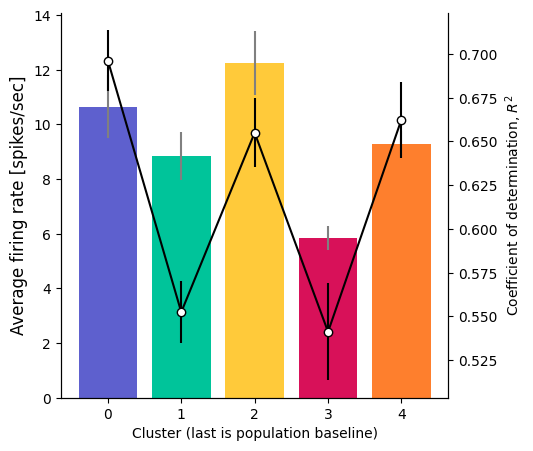

time: 357 ms (started: 2023-09-01 12:01:30 +01:00)


In [11]:
fr_mean = np.append(avg_FR, overall_FR_mean)
fr_sme = np.append(sme_FR, overall_FR_sme)
plot_R2_vs_property(acc_meanGNB, acc_smeGNB, fr_mean, fr_sme, CUSTOM_PAL_SORT, 'Average firing rate [spikes/sec]')

ptt_mean = np.append(mean_ptt, ptt_overall_mean)
ptt_sme = np.append(sme_ptt, ptt_overall_sme)
plot_R2_vs_property(acc_meanGNB, acc_smeGNB, ptt_mean, ptt_sme, CUSTOM_PAL_SORT, 'Average peak to trough duration [ms]')

AP_mean = np.append(meanAP, AP_all_mean)
AP_sme = np.append(smeAP, AP_all_sme)
plot_R2_vs_property(acc_meanGNB, acc_smeGNB, AP_mean, AP_sme, CUSTOM_PAL_SORT, 'Average AP width [ms]')


### Correlation accuracy vs physiological properties

In [ ]:
def normalize_minus1_1(arr):
  arr_norm = []
  arr_min = np.min(arr)
  arr_max = np.max(arr)

  for val in arr:
    #val_norm = 2*(val-arr_min)/(arr_max-arr_min) - 1
    val_norm = (val-arr_min)/(arr_max-arr_min)
    arr_norm.append(val_norm)

  return arr_norm

# normalize physiological properties to compare them all on the same graph
# plt.scatter(normalize_minus1_1(AP_widths_mean[:-1]), acc_avg[:-1],  color='k')
plt.scatter(normalize_minus1_1(mean_ptt), acc_meanGNB[:-1],  c='b')
plt.scatter(normalize_minus1_1(avg_FR), acc_meanGNB[:-1], c='r')
plt.xlabel('Normalized physiological properties')
plt.ylabel(r'Coefficient of determination $R^2$')
#plt.legend(['AP width normlized', 'PTT normalized', 'FR normalized'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(['PTT normalized', 'FR normalized'], bbox_to_anchor=(1.05, 1.0), loc='upper left')

## Compare models for target classification

In [ ]:
clusts = np.arange(len(neuron_types)+1)
plt.errorbar(clusts, acc_meanGNB, yerr=acc_smeGNB, marker='o', fillstyle='full', markerfacecolor='k', color='k', alpha=0.5)
plt.errorbar(clusts, acc_meanLSTM, yerr=acc_smeLSTM, marker='o', fillstyle='full', markerfacecolor='r', color='r', ecolor='#E97451', alpha=0.5)
plt.xlabel('Cluster (last is whole dataset baseline)', fontsize=12)
plt.ylabel(r'Coefficient of determination, $R^2$', fontsize=12)
plt.legend(['GNB', 'LSTM'])

# Correlation

## Compare waveform - match different datasets

Text(0.5, 14.722222222222216, 'Cluster from dataset C19')

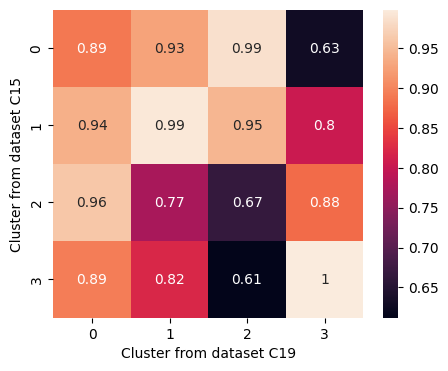

time: 121 ms (started: 2023-09-05 13:01:00 +01:00)


In [111]:
neuron_types1 = neuron_classes(clustering_solution1)
neuron_types2 = neuron_classes(clustering_solution2)

monkey1 = data_spikes1.monkey[0]
monkey2 = data_spikes2.monkey[0]
date1 = data_spikes1.date[0]
date2 = data_spikes2.date[0]
#date2 = data_spikes2.date_time[0] # field name for monkey Mihili
correlation, maxValue = match_clusters(umap_df1, umap_df2, neuron_types1, neuron_types2)
#plt.title(f'Correlation between dataset {monkey1[0]}{date1[:10]} and {monkey2[0]}{date2[:9]}', fontsize=14) # change with new dataset

plt.ylabel(f'Cluster from dataset {monkey1[0]}{date1[3:5]}')
plt.xlabel(f'Cluster from dataset {monkey2[0]}{date2[3:5]}')
#plt.ylabel(f'Cluster from dataset {monkey1[0]}{date1[7:9]}')
#plt.xlabel(f'Cluster from dataset {monkey2[0]}{date2[7:9]}')

In [112]:
maxValue

0    2
1    1
2    0
3    3
dtype: int64

time: 2.61 ms (started: 2023-09-05 13:01:15 +01:00)


In [ ]:
plt.plot(np.mean(umap_df1.iloc[neuron_types1[1]]['waveform'].tolist(), axis=0), label='data1, cluster 1')
plt.plot(np.mean(umap_df2.iloc[neuron_types2[1]]['waveform'].tolist(), axis=0), label='data2, cluster 1')
plt.plot(np.mean(umap_df2.iloc[neuron_types2[2]]['waveform'].tolist(), axis=0), label='data2, cluster 2')
plt.legend()

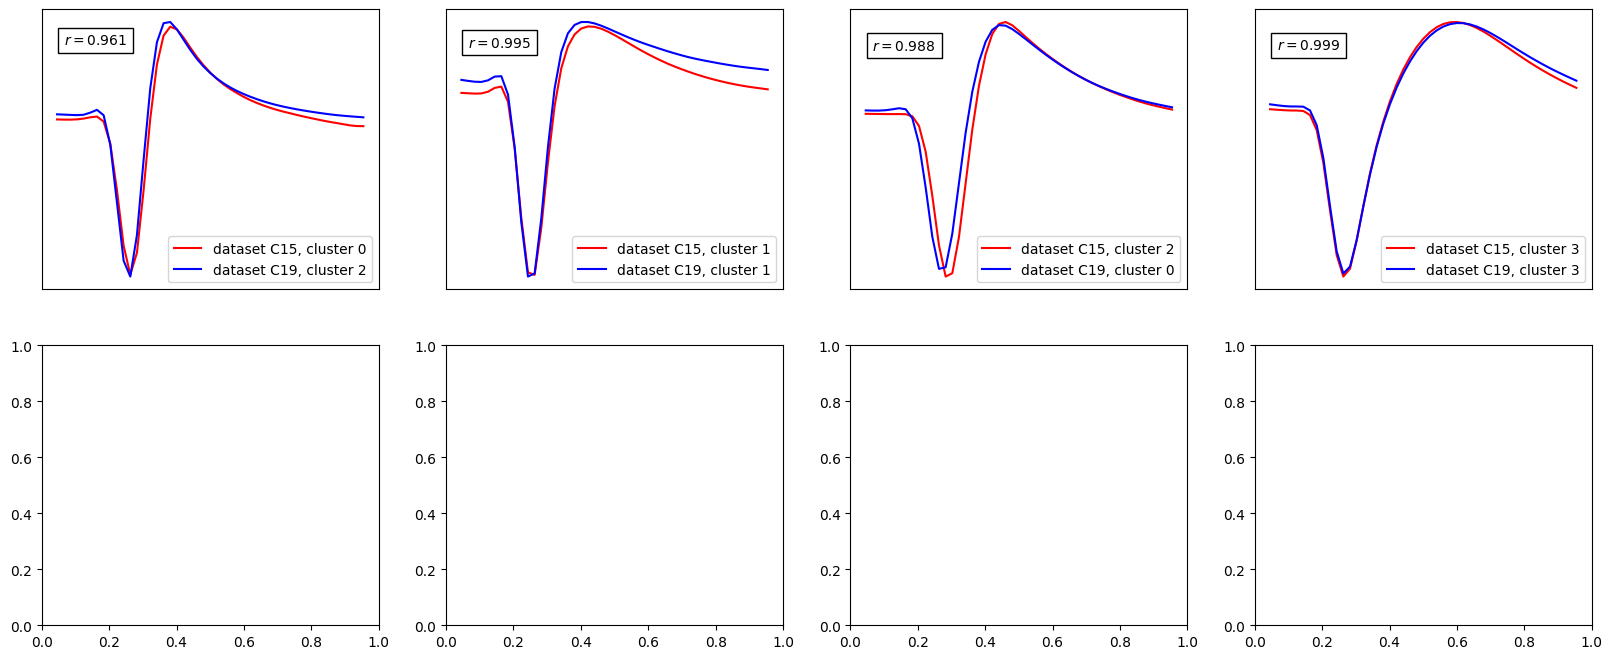

time: 391 ms (started: 2023-09-05 13:01:18 +01:00)


In [113]:
#maxValue = [0,2,3,3]
col_max = 4
row_max = 2
f, ax = plt.subplots(row_max,col_max, figsize=(col_max*5,row_max*4))
row = 0
col = 0
for clust in range(len(neuron_types1)):
    if col == col_max:
        row += 1
        col = 0
    ax[row, col].plot(np.mean(umap_df1.iloc[neuron_types1[clust]]['waveform'].tolist(), axis=0), label=f'dataset {monkey1[0]}{date1[3:5]}, cluster {clust}', color='red')
    ax[row, col].plot(np.mean(umap_df2.iloc[neuron_types2[maxValue[clust]]]['waveform'].tolist(), axis=0), label=f'dataset {monkey2[0]}{date2[3:5]}, cluster {maxValue[clust]}', color='blue')
    ax[row, col].legend(loc='lower right')
    ax[row,col].set_xticks([])
    ax[row,col].set_yticks([])
    ax[row,col].text(1, 0.75, fr'$r={correlation[clust][maxValue[clust]]:.3}$', 
        bbox=dict(facecolor='none', edgecolor='k'))
    col += 1


In [114]:
#maxValue = [2,1,0,3] # depends on datasets

r2_vel_dataset1 = np.array([[0.63994349, 0.46589519, 0.78985291, 0.32735527],
       [0.53224264, 0.59064838, 0.83182818, 0.35468134],
       [0.57242827, 0.43057465, 0.80386477, 0.37617638],
       [0.59577081, 0.49352042, 0.77453301, 0.19667977],
       [0.42277219, 0.49280916, 0.7866612 , 0.22538931],
       [0.720604  , 0.44298391, 0.79065708, 0.28753639],
       [0.58793932, 0.52107392, 0.83152045, 0.21090016],
       [0.49437553, 0.38772157, 0.81361851, 0.23883884],
       [0.59520976, 0.45914476, 0.76801187, 0.4703851 ],
       [0.57928957, 0.47613331, 0.80772653, 0.33780087]])

r2_all_dataset1 = [0.53831322, 0.33053411, 0.50809464, 0.42552568, 0.2248439 ,
           0.44557115, 0.63009945, 0.55443422, 0.64266823, 0.35720269,
           0.54363498, 0.51663147]

r2_all_dataset1_mean = np.mean(r2_all_dataset1)

r2_vel_dataset2 = np.array([[0.69769582, 0.46559943, 0.73024136, 0.56559442],
       [0.7461994 , 0.45198536, 0.74236074, 0.57096739],
       [0.77003291, 0.51529288, 0.72753891, 0.4722226 ],
       [0.73645249, 0.4507195 , 0.67709964, 0.59805566],
       [0.75415431, 0.4744763 , 0.72575772, 0.64098665],
       [0.76026422, 0.52830004, 0.69270418, 0.59200074],
       [0.71210494, 0.51312046, 0.74435956, 0.5874625 ],
       [0.71425813, 0.45833375, 0.72871525, 0.4487798 ],
       [0.70980356, 0.53182681, 0.71437418, 0.44430007],
       [0.75020772, 0.45435731, 0.72856192, 0.57274672]])

r2_all_dataset2 = [0.73004527, 0.64521315, 0.64074874, 0.71642717, 0.66570785,
          0.65330659, 0.57460691, 0.56035182, 0.69240019, 0.59663886,
          0.72397785, 0.63487378]

r2_all_dataset2_mean = np.mean(r2_all_dataset2)

r2_vel_dataset2_ordered = order_array(r2_vel_dataset2, maxValue, axis='col')

time: 1.9 ms (started: 2023-09-05 13:02:27 +01:00)


([<matplotlib.axis.XTick at 0x7f5f47648790>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

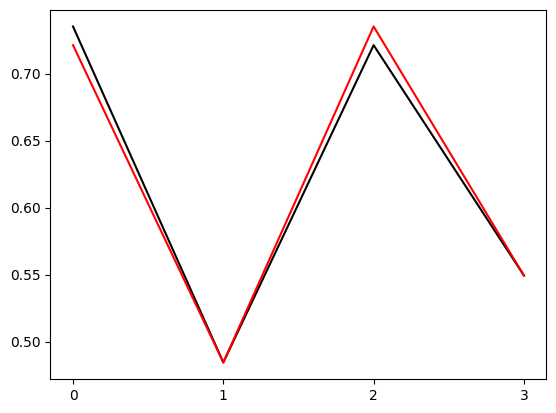

time: 65.9 ms (started: 2023-09-05 13:02:28 +01:00)


In [115]:
r2_vel_dataset2_mean = np.mean(r2_vel_dataset2, axis=0)
r2_vel_dataset2_ordered_mean = np.mean(r2_vel_dataset2_ordered, axis=0)

# this plot is just to check if it was re-ordered correctly
plt.plot(r2_vel_dataset2_mean, color='k')
plt.plot(r2_vel_dataset2_ordered_mean, color='r')
plt.xticks([0,1,2,3])

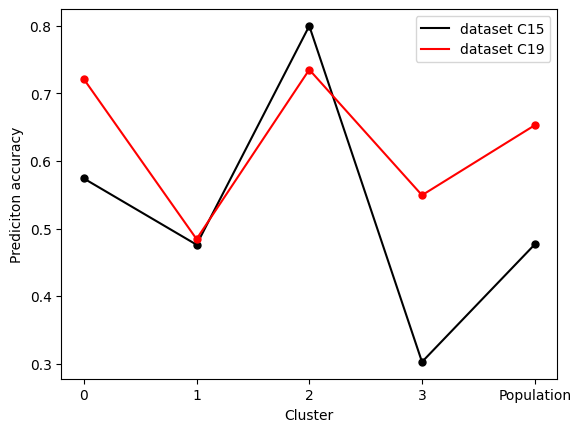

time: 88.1 ms (started: 2023-09-05 13:02:29 +01:00)


In [116]:
r2_vel_dataset1_mean = np.mean(r2_vel_dataset1, axis=0)
r2_vel_dataset2_ordered_mean = np.mean(r2_vel_dataset2_ordered, axis=0)

# compare velocity decoding results after having matched clusters
plt.plot(np.append(r2_vel_dataset1_mean, r2_all_dataset1_mean), color='k', label='dataset C15')
plt.plot(np.append(r2_vel_dataset2_ordered_mean, r2_all_dataset2_mean), color='r', label='dataset C19')
#plt.ylabel(r'Coefficient of determination, $R^2$')
plt.ylabel(r'Prediciton accuracy')
plt.xlabel('Cluster')
plt.xticks([0,1,2, 3, 4], labels = ['0','1','2', '3','Population']);
    
plt.legend()
plt.plot(np.append(r2_vel_dataset1_mean, r2_all_dataset1_mean), '.', color='k', markersize=10)
plt.plot(np.append(r2_vel_dataset2_ordered_mean, r2_all_dataset2_mean), '.', color='r', markersize=10)

## Compare cluster properties of 2 datasets

In [12]:
#maxValue = [2,1,0,3] # depends on datasets

time: 343 µs (started: 2023-09-01 12:02:33 +01:00)


In [117]:
# firing rate 
meanFR1 = [9.94620852, 9.50420066, 12.07152754, 7.29593896]
smeFR1 = [0.98918425, 0.66722433, 2.52295851, 0.65064791]
FR_overall_mean1 = 9.16717403829644
FR_overall_sme1 = 0.45889708427202486

meanFR2 = [10.65481835, 8.83887422, 12.24137832, 5.84664005]
smeFR2 = [1.14930254, 0.87489812, 1.17503089, 0.4301178 ]
FR_overall_mean2 = 9.283142848140548
FR_overall_sme2 = 0.49132703204387457

meanFR2_ordered = order_array(meanFR2, maxValue, axis='col')
smeFR2_ordered = order_array(smeFR2, maxValue, axis='col')

fr_mean1 = np.append(meanFR1, FR_overall_mean1)
fr_mean2 = np.append(meanFR2_ordered, FR_overall_mean2)
fr_sme1 =  np.append(smeFR1, FR_overall_sme1)
fr_sme2 =  np.append(smeFR2_ordered, FR_overall_sme2)

time: 1.36 ms (started: 2023-09-05 13:04:39 +01:00)


In [118]:
# peak to trough 
meanPTT1 = [0.18807692307692309, 0.2633035714285714, 0.2526923076923077, 0.5058064516129032]
smePTT1 = [0.006829995558296806, 0.009017758479708805, 0.008661239445373075, 0.012515059796774829]
PTT_overall_mean1 = 0.3164077669902913
PTT_overall_sme1 = 0.009010090372780237

meanPTT2 = [0.272, 0.2746551724137931, 0.17959999999999998, 0.5237931034482757]
smePTT2 = [0.007742523275177586, 0.017824977327353116, 0.003979681729317894, 0.013556633292633949]
PTT_overall_mean2 = 0.3232881355932203
PTT_overall_sme2 = 0.009746402636897562

meanPTT2_ordered = order_array(meanPTT2, maxValue, axis='col')
smePTT2_ordered = order_array(smePTT2, maxValue, axis='col')

ptt_mean1 = np.append(meanPTT1, PTT_overall_mean1)
ptt_mean2 = np.append(meanPTT2_ordered, PTT_overall_mean2)
ptt_sme1 =  np.append(smePTT1, PTT_overall_sme1)
ptt_sme2 =  np.append(smePTT2_ordered, PTT_overall_sme2)

time: 1.19 ms (started: 2023-09-05 13:04:39 +01:00)


In [119]:
# AP width 
meanAP1 = [0.11615384615384612, 0.12910714285714286, 0.14423076923076922, 0.16677419354838707]
smeAP1 = [0.0026845478478927406, 0.001998698442193816, 0.0028353786115319444, 0.00211345058615138]
AP_overall_mean1 = 0.13844660194174754
AP_overall_sme1 = 0.0016566746348767706

meanAP2 = [0.1368, 0.12310344827586207, 0.11279999999999998, 0.1772413793103448]
smeAP2 = [0.0026677331200852905, 0.0015840858485974684, 0.0023213789005675054, 0.0079778555570076]
AP_overall_mean2 = 0.13993220338983048
AP_overall_sme2 = 0.002943494756185774

meanAP2_ordered = order_array(meanAP2, maxValue, axis='col')
smeAP2_ordered = order_array(smeAP2, maxValue, axis='col')

AP_mean1 = np.append(meanAP1, AP_overall_mean1)
AP_mean2 = np.append(meanAP2_ordered, AP_overall_mean2)
AP_sme1 =  np.append(smeAP1, AP_overall_sme1)
AP_sme2 =  np.append(smeAP2_ordered, AP_overall_sme2)

time: 1.31 ms (started: 2023-09-05 13:04:39 +01:00)


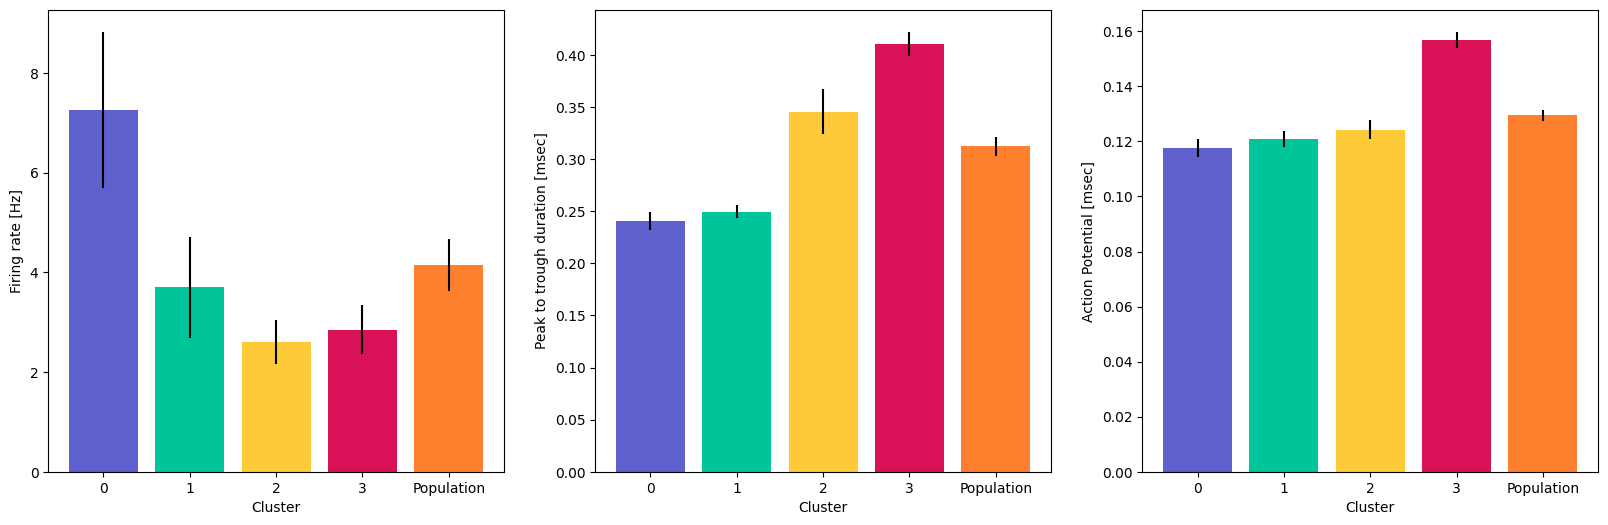

time: 530 ms (started: 2023-09-05 12:48:13 +01:00)


In [106]:
colors = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9']
xpos = np.arange(len(fr_mean1))
f, ax = plt.subplots(1,3, figsize=(20,6))

ax[0].bar(xpos, fr_mean1, color=colors, yerr=fr_sme1)
ax[0].set_ylabel('Firing rate [Hz]')
ax[0].set_xlabel('Cluster')
ax[0].set_xticks([0,1,2,3,4], labels = ['0','1','2','3','Population']);

ax[1].bar(xpos, ptt_mean1, color=colors, yerr=ptt_sme1)
ax[1].set_ylabel('Peak to trough duration [msec]')
ax[1].set_xlabel('Cluster')
ax[1].set_xticks([0,1,2,3,4], labels = ['0','1','2','3','Population']);

ax[2].bar(xpos, AP_mean1, color=colors, yerr=AP_sme1)
ax[2].set_ylabel('Action Potential [msec]')
ax[2].set_xlabel('Cluster')
ax[2].set_xticks([0,1,2,3,4], labels = ['0','1','2','3','Population']);
#plt.ylim([0,7.5])

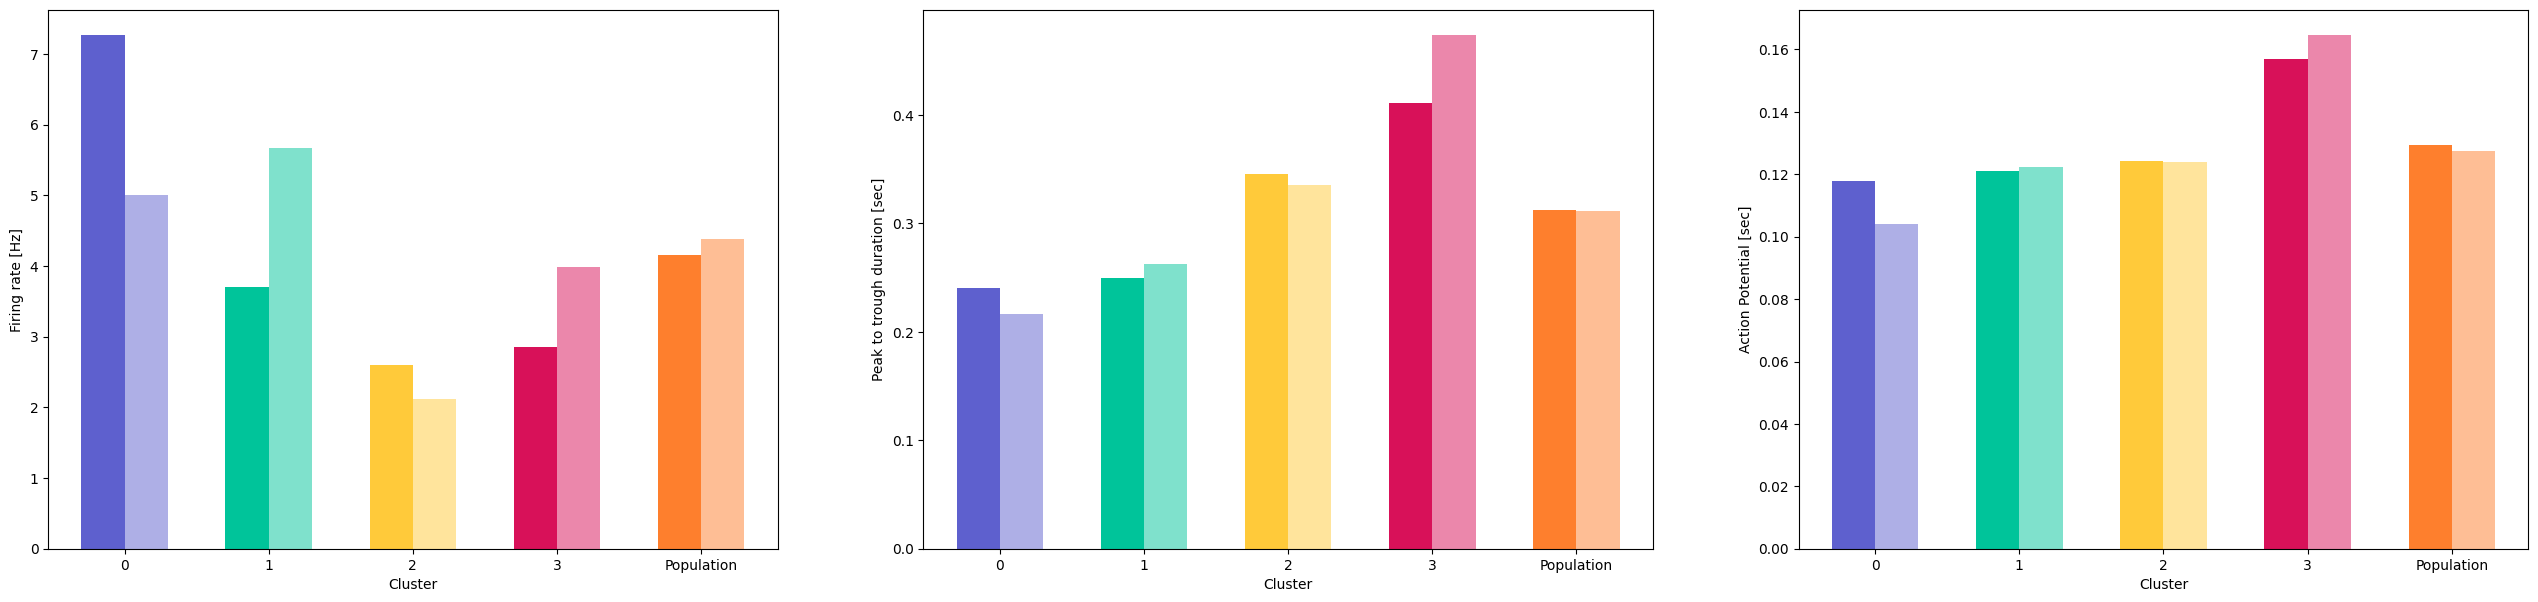

time: 205 ms (started: 2023-09-05 12:48:14 +01:00)


In [107]:
xpos = np.arange(len(fr_mean1))

f, ax = plt.subplots(1,3, figsize=(32,7))

ax[0].bar(xpos-0.15, fr_mean1, width=0.3, align='center', color=colors)
ax[0].bar(xpos+0.15, fr_mean2, width=0.3, align='center', color=colors, alpha=0.5)
#plt.legend()
ax[0].set_xlabel('Cluster')
ax[0].set_xticks([0,1,2,3,4], labels = ['0','1','2','3','Population']);
ax[0].set_ylabel('Firing rate [Hz]')

ax[1].bar(xpos-0.15, ptt_mean1, width=0.3, align='center', color=colors)
ax[1].bar(xpos+0.15, ptt_mean2, width=0.3, align='center', color=colors, alpha=0.5)
#plt.legend()
ax[1].set_xlabel('Cluster')
ax[1].set_xticks([0,1,2,3,4], labels = ['0','1','2','3','Population']);
ax[1].set_ylabel('Peak to trough duration [sec]')

ax[2].bar(xpos-0.15, AP_mean1, width=0.3, align='center', color=colors)
ax[2].bar(xpos+0.15, AP_mean2, width=0.3, align='center', color=colors, alpha=0.5)
#plt.legend()
ax[2].set_xlabel('Cluster')
ax[2].set_xticks([0,1,2,3,4], labels = ['0','1','2','3','Population']);
ax[2].set_ylabel('Action Potential [sec]')

'''
for i in range(len(ax)):
    ax2 = ax[i].twinx()
    ax2.plot(np.append(r2_vel_dataset1_mean, r2_all_dataset1_mean), marker='o', color='k', markersize=5, label=r'$R^2$ dataset 1')
    ax2.plot(np.append(r2_vel_dataset2_ordered_mean, r2_all_dataset2_mean), marker='o', color='r', markersize=5, label=r'$R^2$ dataset 2')
    ax2.set_ylabel(r'Coefficient of determination, $R^2$')
'''
plt.show()


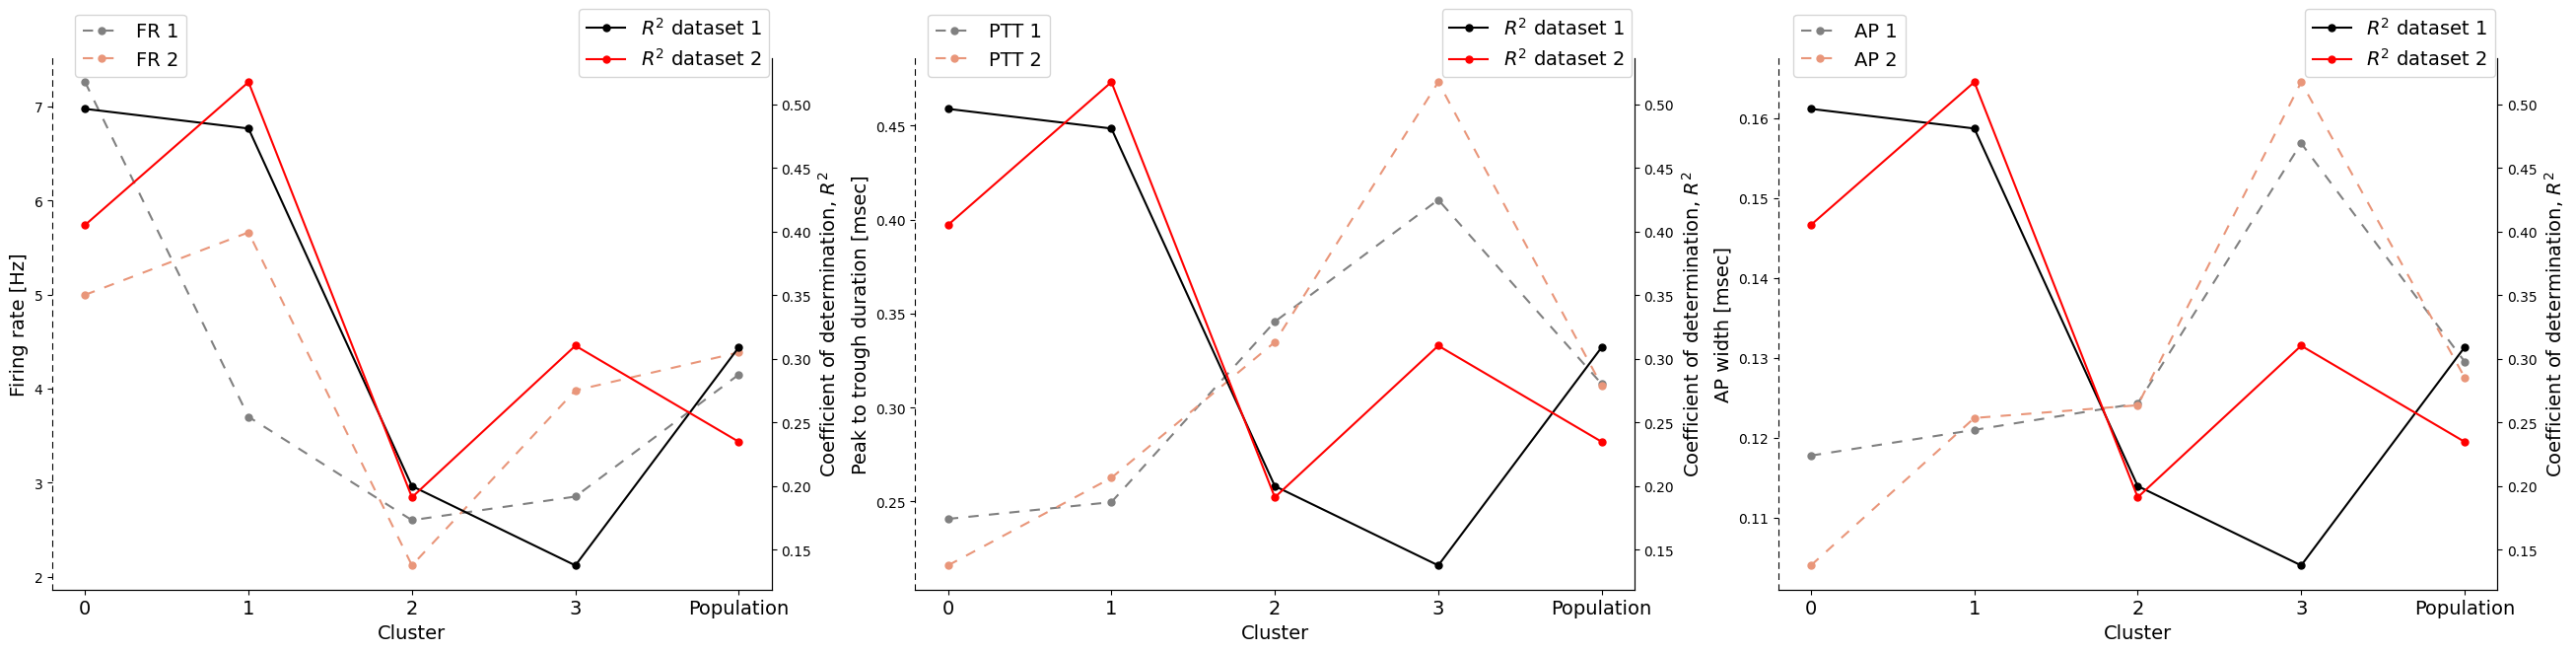

time: 435 ms (started: 2023-09-05 12:48:14 +01:00)


In [108]:
r2_vel_dataset1_mean = np.mean(r2_vel_dataset1, axis=0)
r2_vel_dataset2_ordered_mean = np.mean(r2_vel_dataset2_ordered, axis=0)

f, ax = plt.subplots(1,3, figsize=(32, 7))

compare_values_plot(ax[0], fr_mean1, fr_mean2, fr_sme1, fr_sme2, 'FR', plot_sme=False)
ax[0].set_ylabel('Firing rate [Hz]', fontsize=14)
ax[0].legend(bbox_to_anchor=(0.2, 1.1), fontsize=14)

compare_values_plot(ax[1], ptt_mean1, ptt_mean2, ptt_sme1, ptt_sme2, 'PTT', plot_sme=False)
ax[1].set_ylabel('Peak to trough duration [msec]', fontsize=14)
ax[1].legend(bbox_to_anchor=(0.2, 1.1), fontsize=14)

compare_values_plot(ax[2], AP_mean1, AP_mean2, AP_sme1, AP_sme2, 'AP', plot_sme=False)
ax[2].set_ylabel('AP width [msec]', fontsize=14)
ax[2].legend(bbox_to_anchor=(0.19, 1.1), fontsize=14)

for i in range(len(ax)):
    ax2 = ax[i].twinx()
    ax2.plot(np.append(r2_vel_dataset1_mean, r2_all_dataset1_mean), marker='o', color='k', markersize=5, label=r'$R^2$ dataset 1')
    ax2.plot(np.append(r2_vel_dataset2_ordered_mean, r2_all_dataset2_mean), marker='o', color='r', markersize=5, label=r'$R^2$ dataset 2')
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.set_ylabel(r'Coefficient of determination, $R^2$', fontsize=14)
    #ax2.set_ylabel('Target Classifier Accuracy', fontsize=14)
    ax2.legend(bbox_to_anchor=(1.01, 1.11), fontsize=14)
    ax[i].set_xlabel('Cluster', fontsize=14)
    ax[i].set_xticks([0,1,2,3,4], labels = ['0','1','2','3','Population'], fontsize=14);


## Cluster properties vs decoding

In [31]:
td.date[0]

'09-19-2016'

time: 2.05 ms (started: 2023-09-01 12:12:06 +01:00)


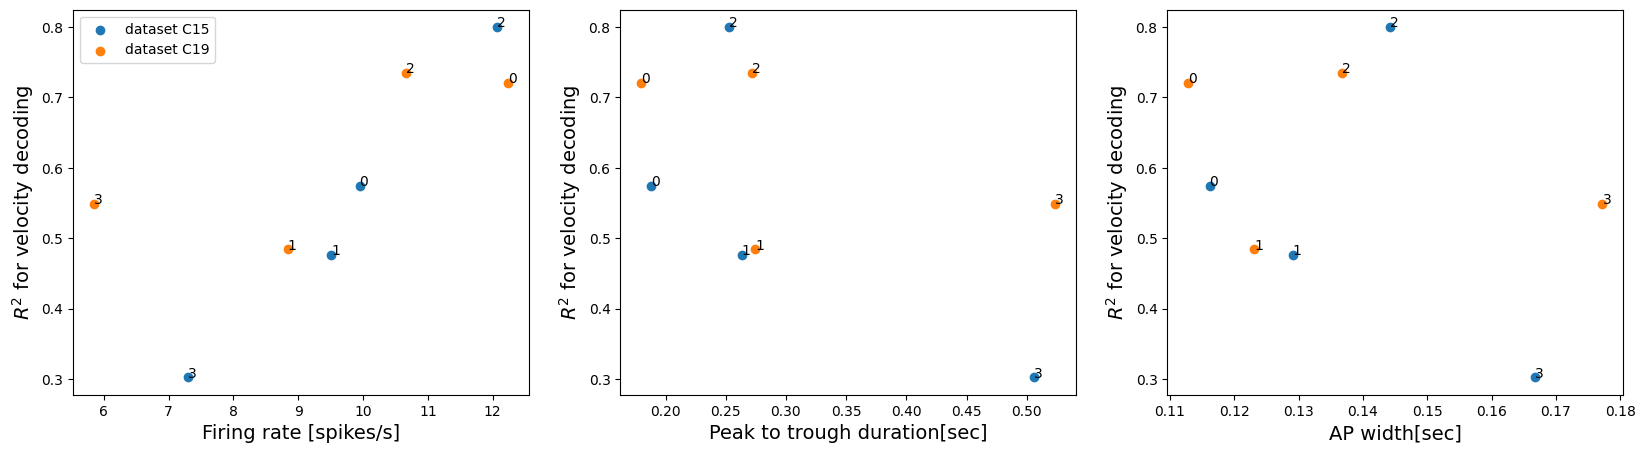

time: 330 ms (started: 2023-09-05 13:04:59 +01:00)


In [120]:
#monkey1 = data_spikes1.monkey[0]
#monkey2 = data_spikes2.monkey[0]
#date1 = data_spikes1.date[0]
#date2 = data_spikes2.date[0]
#date2 = data_spikes2.date_time[0] # field name for monkey Mihili
monkey1 = 'Chewie'
monkey2 = 'Chewie'
date1 = '09-15-2016'
date2 = '09-19-2016'

f, ax = plt.subplots(1,3, figsize=(20, 5))
r2_1 = r2_vel_dataset1_mean
r2_2 = r2_vel_dataset2_ordered_mean

ax[0].scatter(meanFR1, r2_1, label=f'dataset {monkey1[0]}{date1[3:5]}')
ax[0].scatter(meanFR2_ordered, r2_2, label=f'dataset {monkey2[0]}{date2[3:5]}')
ax[0].set_xlabel('Firing rate [spikes/s]', fontsize=14)
ax[0].set_ylabel(r'$R^2$ for velocity decoding', fontsize=14)
#ax[0].legend(bbox_to_anchor=(0.9,1.2))
ax[0].legend()
for i in range(len(meanFR1)):
    ax[0].annotate(i, (meanFR1[i], r2_1[i]))
    ax[0].annotate(i, (meanFR2_ordered[i], r2_2[i]))

ax[1].scatter(meanPTT1, r2_1)
ax[1].scatter(meanPTT2_ordered, r2_2)
ax[1].set_xlabel('Peak to trough duration[sec]', fontsize=14)
ax[1].set_ylabel(r'$R^2$ for velocity decoding', fontsize=14)
for i in range(len(meanPTT1)):
    ax[1].annotate(i, (meanPTT1[i], r2_1[i]))
    ax[1].annotate(i, (meanPTT2_ordered[i], r2_2[i]))

ax[2].scatter(meanAP1, r2_1)
ax[2].scatter(meanAP2_ordered, r2_2)
ax[2].set_xlabel('AP width[sec]', fontsize=14)
ax[2].set_ylabel(r'$R^2$ for velocity decoding', fontsize=14)
#ax[2].set_xlim(0.11, 0.15)
for i in range(len(meanAP1)):
    ax[2].annotate(i, (meanAP1[i], r2_1[i]))
    ax[2].annotate(i, (meanAP2_ordered[i], r2_2[i]))


## Correlation heatmap 

### Waveform correlation

In [142]:
neurons_tot = len(clustering_solution)
correlation_wv = np.zeros((neurons_tot, neurons_tot))

for neuron1 in range(neurons_tot):
    waveform1 = umap_df.iloc[neuron1]['waveform'] # waveform of neuron1

    for neuron2 in range(neurons_tot):
        if neuron2 < neuron1:
            correlation_wv[neuron1, neuron2] = correlation_wv[neuron2, neuron1]
            continue
        waveform2 = umap_df.iloc[neuron2]['waveform'] # waveform of neuron2
        correlation_wv[neuron1, neuron2] = np.corrcoef(waveform1, waveform2)[0, 1]

time: 4.48 s (started: 2023-08-23 18:16:50 +01:00)


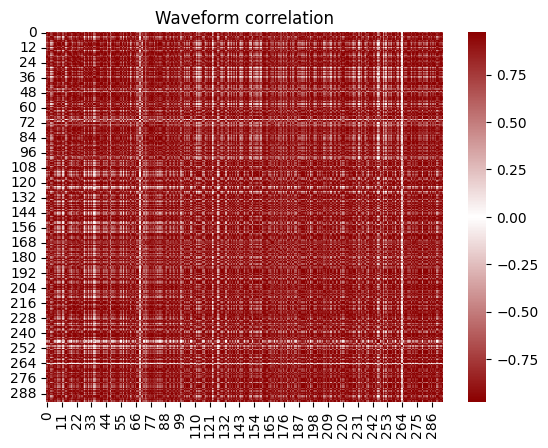

time: 355 ms (started: 2023-08-23 18:16:55 +01:00)


In [143]:
cmap_wv, norm_wv = div_circ_cmap(correlation_wv,'#FF6961', '#8B0000')
sns.heatmap(correlation_wv, cmap=cmap_wv, norm=norm_wv);
plt.title('Waveform correlation');

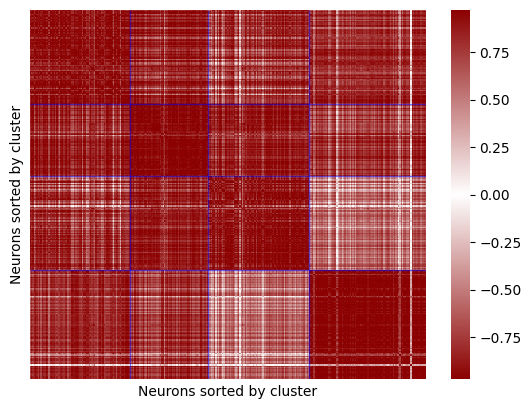

time: 8.72 s (started: 2023-08-23 18:16:55 +01:00)


In [144]:
# Correlation heatmap for neurons sorted by cluster
neurons = neurons_in_cluster(clustering_solution)
neuron_types = neuron_classes(clustering_solution) # neuron in each cluster

neurons_ordered = [] # contain all neuron indices ordered by cluster they belong to
for cluster in range(len(neuron_types)):
    neurons_ordered.extend(neuron_types[cluster])

correlation_ordered = np.zeros((neurons_tot, neurons_tot))

for idx1 in range(neurons_tot):
    neuron1 = neurons_ordered[idx1]
    waveform1 = umap_df.iloc[neuron1]['waveform'] # waveform of neuron1

    for idx2 in range(neurons_tot):
        neuron2 = neurons_ordered[idx2]
        waveform2 = umap_df.iloc[neuron2]['waveform'] # waveform of neuron2
        correlation_ordered[idx1, idx2] = np.corrcoef(waveform1, waveform2)[0, 1]

sns.heatmap(correlation_ordered, xticklabels=False, yticklabels=False, cmap=cmap_wv, norm=norm_wv)
n_tot = 0

for i in range(len(neuron_types)-1):
    plt.hlines(y=n_tot+neurons[i], xmin=0, xmax=neurons_tot, color='b', linewidth=1, alpha=0.5)
    plt.vlines(x=n_tot+neurons[i], ymin=0, ymax=neurons_tot, color='b', linewidth=1, alpha=0.5)
    n_tot = n_tot+neurons[i]

plt.xlabel('Neurons sorted by cluster')
plt.ylabel('Neurons sorted by cluster');
#plt.title('Waveform correlation')

### Firing rate correlation

In [ ]:
# each column is the firing rate of each neuron in trial i

'''
# this is what I was doing before -> WRONG
for neuron in range(neurons_tot):
    for trial in range(num_trials):
        fr_rate = td_processed.both_rates[trial][:,neuron]
        fr_sum += fr_rate
    fr_avg[:,neuron] = fr_sum/num_trials

fr_correlation = np.zeros((neurons_tot, neurons_tot))

for neuron1 in range(neurons_tot):
    fr1 = fr_avg[neuron1,:] # average firing rate of neuron1

    for neuron2 in range(neurons_tot):
        fr2 = fr_avg[neuron2,:] # average firing rate of neuron2
        fr_correlation[neuron1, neuron2] = np.corrcoef(fr1, fr2)[0, 1]
sns.heatmap(fr_correlation)


# Correlation heatmap for neurons sorted by cluster
neurons = neurons_in_cluster(clustering_solution)

neurons_ordered = [] # contain all neuron indices ordered by cluster they belong to
for cluster in range(len(neuron_types)):
    neurons_ordered.extend(neuron_types[cluster])

fr_correlation_ordered = np.zeros((neurons_tot, neurons_tot))

for idx1 in range(neurons_tot):
    neuron1 = neurons_ordered[idx1]
    fr1 = fr_avg[neuron1,:] # average firing rate of neuron1

    for idx2 in range(neurons_tot):
        neuron2 = neurons_ordered[idx2]
        fr2 = fr_avg[neuron2,:] # average firing rate of neuron2
        fr_correlation_ordered[idx1, idx2] = np.corrcoef(fr1, fr2)[0, 1]

sns.heatmap(fr_correlation_ordered, xticklabels=False, yticklabels=False)

n_tot = 0
for i in range(len(neuron_types)-1):
    plt.hlines(y=n_tot+neurons[i], xmin=0, xmax=neurons_tot, color='b', linewidth=1)
    plt.vlines(x=n_tot+neurons[i], ymin=0, ymax=neurons_tot, color='b', linewidth=1)

    n_tot = n_tot+neurons[i]

plt.xlabel('Neurons sorted by cluster')
plt.ylabel('Neurons sorted by cluster');
'''
# fr_avg = np.transpose(fr_avg) # each row is a neuron, column is time interval

################# NEW #############
# correct interval
td = preprocessing_general(data_spikes, combine=False)
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -4, 14, rates=True)

neurons_tot = len(clustering_solution)
fr_sum = np.zeros(len(td_processed.both_rates[0]))
num_trials = len(td_processed)
fr_correlation_all = np.zeros((neurons_tot, neurons_tot, num_trials))
avg_fr_trial = np.zeros((num_trials, neurons_tot)) # -> trials x neurons
# compute the average firing rate of each neuron at each trial
for trial in range(num_trials):
    if trial % 25 == 0: print(trial/num_trials*100, '%')
    for neuron1 in range(neurons_tot):
        fr1 = td_processed.both_rates[trial][:,neuron1]
        
        for neuron2 in range(neurons_tot):
            if neuron2 < neuron1:
                fr_correlation_all[neuron1, neuron2, trial] = fr_correlation_all[neuron2, neuron1, trial]
                continue
            fr2 = td_processed.both_rates[trial][:,neuron2]
            fr_correlation_all[neuron1, neuron2, trial] = np.corrcoef(fr1, fr2)[0, 1]


In [ ]:
# DON'T USE THIS
# shuffle firing rates in each trial - used only to check correlation is not biased
td = preprocessing_general(data_spikes)
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -6, 21, rates=True)

rates = td_processed.both_rates
rates_shuffled = np.zeros((rates.shape[0], rates[0].shape[0], rates[0].shape[1]))
for trial in range(rates.shape[0]):
    rates_shuffled[trial] = np.random.permutation(rates[trial])


In [ ]:
# only to check if shuffling is correct - not used
for trial in range(rates.shape[0]):
    for neuron in range(a[trial].shape[1]):
        if set(rates[trial][:,neuron]) != set(rates_shuffled[trial][:,neuron]):
            print(trial, neuron)
print('Correct')

In [ ]:
# not used
# shuffle firing rates in each trial to check if correlation is biased by general higher fr - not used
td = preprocessing_general(data_spikes)
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -6, 21, rates=True)

neurons_tot = len(clustering_solution)
fr_sum = np.zeros(len(td_processed.both_rates[0]))
num_trials = len(td_processed)


fr_correlation_all = np.zeros((neurons_tot, neurons_tot, num_trials))
avg_fr_trial = np.zeros((num_trials, neurons_tot)) # -> trials x neurons
# compute the average firing rate of each neuron at each trial
for trial in range(num_trials):
    if trial % 50 == 0: print(trial/num_trials*100, '%')
    for neuron1 in range(neurons_tot):
        fr1 = td_processed.both_rates[trial][:,neuron1]
        for neuron2 in range(neurons_tot):
            if neuron2 < neuron1: continue
            fr2 = np.random.permutation(td_processed.both_rates[trial][:,neuron2])
            fr_correlation_all[neuron1, neuron2, trial] = np.corrcoef(fr1, fr2)[0, 1]


In [176]:
fr_correlation_avg = np.mean(fr_correlation_all, axis=2)

time: 2.25 ms (started: 2023-08-23 19:13:16 +01:00)


In [51]:
#np.savetxt('fr_correlation_datasetM18_mov.txt',fr_correlation_avg)
# saved it becasue it took very long to compute
# load saved firing rate
fr_correlation_avg = np.loadtxt('fr_correlation_datasetC15_mov.txt')

time: 32.9 ms (started: 2023-08-29 11:13:31 +01:00)


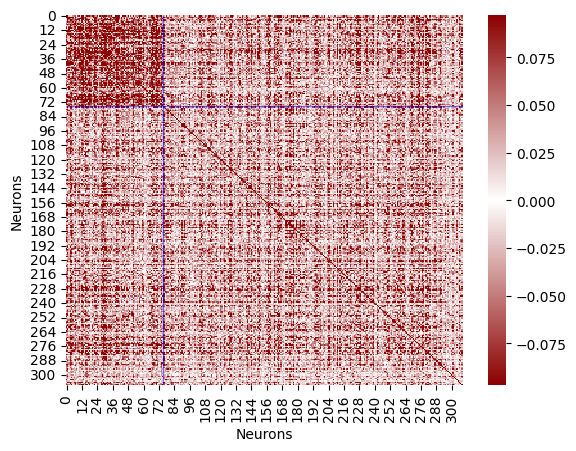

time: 380 ms (started: 2023-08-29 11:13:31 +01:00)


In [52]:
#fr_correlation_avg = np.maximum(fr_correlation_avg, fr_correlation_avg.transpose())
cmap_fr, norm_fr = div_circ_cmap(fr_correlation_avg,'#FF6961', '#8B0000')

sns.heatmap(fr_correlation_avg, cmap=cmap_fr, norm=norm_fr)
plt.xlabel('Neurons')
plt.ylabel('Neurons')
#plt.title('Firing rate correlation (movement)')

neurons_M1 = []
neurons_PMd = []
for neuron in range(waveform_filtered.shape[0]):
    if waveform_filtered.array.iloc[neuron] == 'M1':
        neurons_M1.append(neuron)
    elif waveform_filtered.array.iloc[neuron] == 'PMd':
        neurons_PMd.append(neuron)
neurons_tot = len(clustering_solution)    
plt.hlines(y=len(neurons_M1), xmin=0, xmax=neurons_tot, color='b', linewidth=1, alpha=0.5)
plt.vlines(x=len(neurons_M1), ymin=0, ymax=neurons_tot, color='b', linewidth=1, alpha=0.5)

In [53]:
# Correlation heatmap for neurons sorted by cluster
neuron_types = neuron_classes(clustering_solution)
neurons_tot = len(clustering_solution)
neurons = neurons_in_cluster(clustering_solution)

fr_correlation_ordered = sort_by_cluster(fr_correlation_avg, neuron_types, neurons_tot)


time: 13.1 ms (started: 2023-08-29 11:13:31 +01:00)


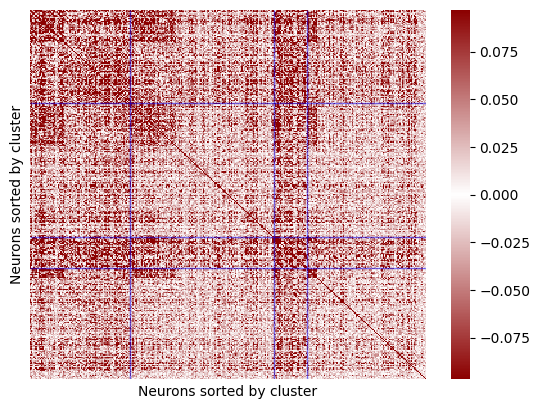

time: 218 ms (started: 2023-08-29 11:13:31 +01:00)


In [54]:
# plot heatmap neurons sorted by cluster

sns.heatmap(fr_correlation_ordered, xticklabels=False, yticklabels=False, cmap=cmap_fr, norm=norm_fr)
#plt.title('Firing rate correlation sorted by cluster (movement)')

n_tot = 0
for i in range(len(neuron_types)-1):
    plt.hlines(y=n_tot+neurons[i], xmin=0, xmax=neurons_tot, color='b', linewidth=1, alpha=0.5)
    plt.vlines(x=n_tot+neurons[i], ymin=0, ymax=neurons_tot, color='b', linewidth=1, alpha=0.5)
    n_tot = n_tot+neurons[i]

plt.xlabel('Neurons sorted by cluster')
plt.ylabel('Neurons sorted by cluster');

In [55]:
# histogram to show fr correlation distribution of each cluster
correlation_distribution_cluster = {clust: [] for clust in range(len(neuron_types))}
 
n = 0
for clust in range(len(neuron_types)):
    for neuron1 in range(n, n+neurons[clust]):
        for neuron2 in range(n, n+neurons[clust]):
            if neuron2 <= neuron1: continue
            correlation_distribution_cluster[clust].append(fr_correlation_ordered[neuron1, neuron2])
    n += neurons[clust]
    
correlation_distribution_all = []
for neuron1 in range(fr_correlation_ordered.shape[0]):
    for neuron2 in range(fr_correlation_ordered.shape[1]):
        if neuron2 <= neuron1: continue
        correlation_distribution_all.append(fr_correlation_ordered[neuron1, neuron2])


time: 11.1 ms (started: 2023-08-29 11:13:31 +01:00)


In [56]:
# statistic test
# two-sample Kolmogorov-Smirnov test 
from scipy.stats import ks_2samp

pval = [0]*len(neuron_types)
stats = [0]*len(neuron_types)
p = []

lenghts = [len(correlation_distribution_cluster[cl]) for cl in range(len(neuron_types))]
#N_samples = int(np.min(lenghts)*0.9)

N_samples = 300
N = np.random.choice(np.arange(len(correlation_distribution_all)), N_samples)
correlation_distribution_all_sampled = [correlation_distribution_all[i] for i in N]

reps = 100
for _ in range(reps):
    for clust in range(len(neuron_types)):
        
        #N_samples = len(correlation_distribution_cluster[clust])
        #N = np.random.choice(np.arange(len(correlation_distribution_all)), N_samples)
        #correlation_distribution_all_sampled = [correlation_distribution_all[i] for i in N]
        
        ##### KstestResult = ks_2samp(np.sort(abs(np.asarray(correlation_distribution_all[N]))), np.sort(abs(np.asarray(correlation_distribution_cluster[clust]))))
        #KstestResult = ks_2samp(correlation_distribution_all, correlation_distribution_cluster[clust])
        #KstestResult = ks_2samp(correlation_distribution_all_sampled, correlation_distribution_cluster[clust])
        
        N = np.random.choice(np.arange(len(correlation_distribution_cluster[clust])), N_samples)
        correlation_distribution_clust_sampled = [correlation_distribution_cluster[clust][i] for i in N]
        #KstestResult = ks_2samp(correlation_distribution_all_sampled, correlation_distribution_clust_sampled)
        KstestResult = ks_2samp(correlation_distribution_all, correlation_distribution_clust_sampled)
        
        #print(KstestResult)
        
        n1 = len(np.asarray(correlation_distribution_all_sampled))
        #n2 = len(np.asarray(correlation_distribution_cluster[clust]))
        n2 = len(np.asarray(correlation_distribution_clust_sampled))
        # if stat > D -> reject null hypothesis -> distributions are different
        #print('D=',1.22*np.sqrt((n1+n2)/(n1*n2)), ', stat=', KstestResult.statistic)
        stats[clust] += KstestResult.statistic
        pval[clust] += KstestResult.pvalue


D = []
for clust in range(len(neuron_types)):
    # if stat > D -> reject null hypothesis -> distributions are different
    # n2 = len(np.asarray(correlation_distribution_cluster[clust]))
    n2 = len(np.asarray(correlation_distribution_clust_sampled))
    D.append(1.22*np.sqrt((n1+n2)/(n1*n2)))
    
#print('D', D)
#print('avg stats', [st/reps for st in stats])
avg_pval = [pv/reps for pv in pval]
print('avg pval', avg_pval)

avg pval [0.0004479871204771845, 0.12847368484513433, 1.7999212565657212e-06, 0.0017341345721950284]
time: 1.87 s (started: 2023-08-29 11:13:31 +01:00)


Text(0.07, 0.5, 'Occurences density')

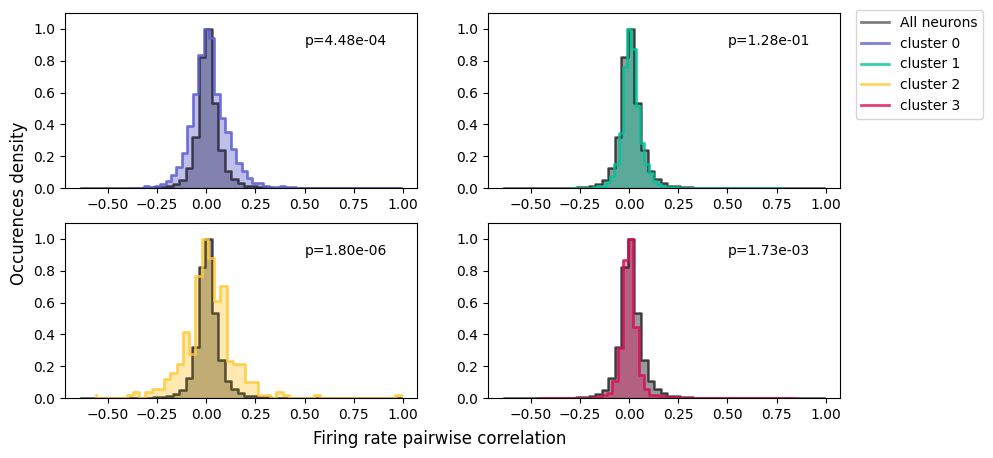

time: 331 ms (started: 2023-08-29 11:13:33 +01:00)


In [57]:
# plot histograms of pairwise correlation per cluster vs all population
colors = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2']

f,ax = plt.subplots(2,2,figsize=(10,5))
r = 0
c = 0
for clust in range(len(neuron_types)):
    if c == 2:
        r += 1
        c = 0

    #hist, bins = np.histogram(abs(np.asarray(correlation_distribution_all)), 50)
    hist, bins = np.histogram(correlation_distribution_all, 50)
    if r == 0 and c == 0:
        #ax[r,c].step(bins, np.pad(hist, (1, 0)) / hist.max(), where='pre', lw=2, color='k', alpha=0.5, label='All neurons')
        ax[r,c].step(bins[1:], hist/hist.max(), where='pre', lw=2, color='k', alpha=0.5, label='All neurons')
        ax[r,c].annotate(f'p={avg_pval[clust]:.2e}', (0.5,0.9))
    else:
        #ax[r,c].step(bins, np.pad(hist, (1, 0)) / hist.max(), where='pre', lw=2, color='k', alpha=0.5)
        ax[r,c].step(bins[1:], hist/hist.max(), where='pre', lw=2, color='k', alpha=0.5)
        ax[r,c].annotate(f'p={avg_pval[clust]:.2e}', (0.5,0.9))
    #ax[r,c].fill_between(bins, np.pad(hist, (1, 0)) / hist.max(), step="pre", color='k', alpha=0.4)
    ax[r,c].fill_between(bins[1:], hist / hist.max(), step="pre", color='k', alpha=0.4)

    #hist, bins = np.histogram(abs(np.asarray(correlation_distribution_cluster[clust])), 50)
    hist, bins = np.histogram(correlation_distribution_cluster[clust], 50)
    #ax[r,c].step(bins, np.pad(hist, (1, 0)) / hist.max(), where='pre', lw=2, color=colors[clust], alpha=0.8, label=f'cluster {clust}')
    ax[r,c].step(bins[1:], hist/hist.max(), where='pre', lw=2, color=colors[clust], alpha=0.8, label=f'cluster {clust}')
    
    #ax[r,c].fill_between(bins, np.pad(hist, (1, 0)) / hist.max(), step="pre", color=colors[clust], alpha=0.4)
    ax[r,c].fill_between(bins[1:], hist / hist.max(), step="pre", color=colors[clust], alpha=0.4)
    
    ax[r,c].set_ylim([0,1.1])
    c += 1
    
    
f.legend(loc='upper right', bbox_to_anchor=(1.05,0.9))
f.supxlabel('Firing rate pairwise correlation')
f.supylabel('Occurences density', x=0.07)

Text(0.07, 0.5, 'Occurences density')

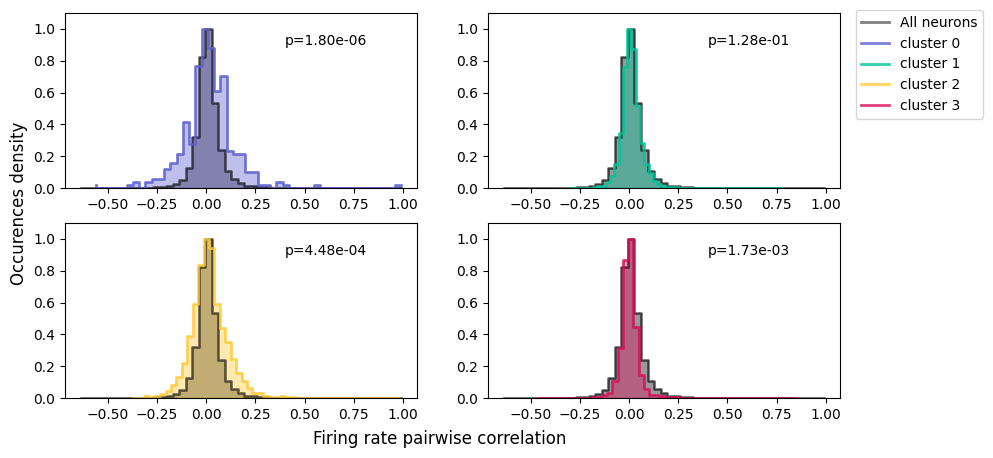

time: 322 ms (started: 2023-08-29 11:13:33 +01:00)


In [58]:
# plot histograms of pairwise correlation per cluster vs all population
# sort clusters to match with the other dataset
#maxValue_M = [1,3,2,0]
maxValue_C = [2,1,0,3]
maxValue = maxValue_C
colors = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2']

f,ax = plt.subplots(2,2,figsize=(10,5))
r = 0
c = 0
for clust in range(len(neuron_types)):
    if c == 2:
        r += 1
        c = 0

    hist, bins = np.histogram(correlation_distribution_all, 50)
    if r == 0 and c == 0:
        ax[r,c].step(bins[1:], hist/hist.max(), where='pre', lw=2, color='k', alpha=0.5, label='All neurons')
    else:
        ax[r,c].step(bins[1:], hist/hist.max(), where='pre', lw=2, color='k', alpha=0.5)
    
    ax[r,c].fill_between(bins[1:], hist / hist.max(), step="pre", color='k', alpha=0.4)

    hist, bins = np.histogram(correlation_distribution_cluster[maxValue[clust]], 50)
    ax[r,c].step(bins[1:], hist/hist.max(), where='pre', lw=2, color=colors[clust], alpha=0.8, label=f'cluster {clust}')
    ax[r,c].fill_between(bins[1:], hist / hist.max(), step="pre", color=colors[clust], alpha=0.4)
    ax[r,c].annotate(f'p={avg_pval[maxValue[clust]]:.2e}', (0.4,0.9))
    ax[r,c].set_ylim([0,1.1])
    c += 1
    
    
f.legend(loc='upper right', bbox_to_anchor=(1.05,0.9))
f.supxlabel('Firing rate pairwise correlation')
f.supylabel('Occurences density', x=0.07)

### compare movement and preparation interval


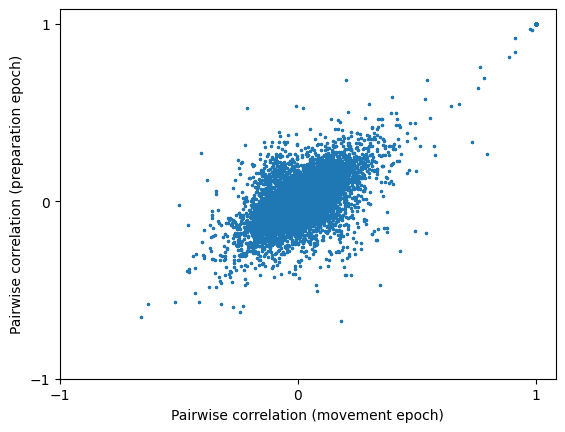

time: 208 ms (started: 2023-08-22 13:15:52 +01:00)


In [7]:
## compare movement and preparation interval
fr_correlation_mov = np.loadtxt('fr_correlation_datasetC19_mov.txt')
fr_correlation_prep = np.loadtxt('fr_correlation_datasetC19_prep.txt')

plt.scatter(fr_correlation_mov, fr_correlation_prep, s=2)
plt.xlabel('Pairwise correlation (movement epoch)')
plt.ylabel('Pairwise correlation (preparation epoch)')
plt.xticks([-1, 0, 1]);
plt.yticks([-1, 0, 1]);

Text(0.5, 0.03, 'Pairwise correlation (preparation epoch)')

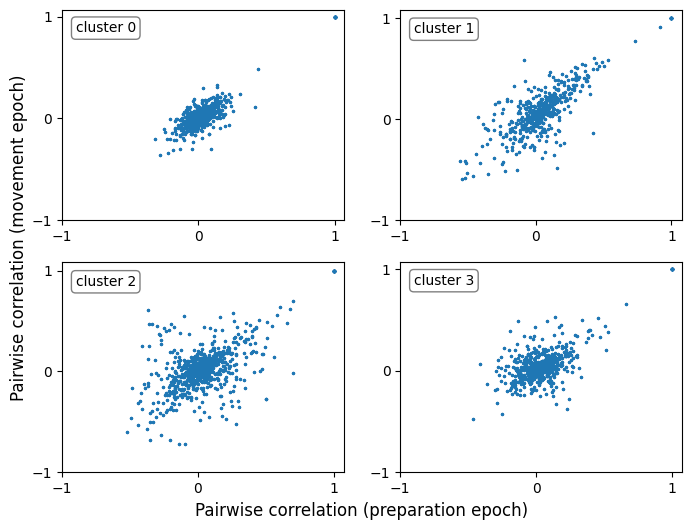

time: 202 ms (started: 2023-08-03 10:13:07 +01:00)


In [31]:
neuron_types = neuron_classes(clustering_solution)
neurons_tot = len(clustering_solution)
neurons = neurons_in_cluster(clustering_solution)

fr_correlation_sorted_prep = sort_by_cluster(fr_correlation_prep, neuron_types, neurons_tot)
fr_correlation_sorted_mov = sort_by_cluster(fr_correlation_mov, neuron_types, neurons_tot)

# check cluster by cluster if same shape is obtained
f,ax = plt.subplots(2,2, figsize=(8,6))
row = 0
col = 0
n_tot = 0

for cluster in range(len(neuron_types)):
    if col == 2:
        row += 1
        col = 0
    start = n_tot
    end = n_tot+neurons[cluster]
    ax[row,col].scatter(fr_correlation_mov[start:end,start:end], fr_correlation_prep[start:end,start:end], s=2, label=f'cluster {cluster}')
    #if row == 1: ax[row,col].set_xlabel('Pairwise correlation (movement epoch)')
    #if col == 0: ax[row,col].set_ylabel('Pairwise correlation (preparation epoch)')
    ax[row,col].set_xticks([-1, 0, 1]);
    ax[row,col].set_yticks([-1, 0, 1]);
    #ax[row,col].legend()
    ax[row,col].annotate(f'cluster {cluster}', (-0.9,0.85), bbox=dict(boxstyle='round', fc='w', ec='gray'))
    n_tot = n_tot+neurons[cluster]
    col += 1
f.supylabel('Pairwise correlation (movement epoch)', x=0.06, y=0.5)
f.supxlabel('Pairwise correlation (preparation epoch)', x=0.5, y=0.03)
 

In [ ]:
n_tot = 0

for cluster in range(len(neuron_types)):
    start = n_tot
    end = n_tot+neurons[cluster]
    plt.scatter(fr_correlation_mov[start:end,start:end], fr_correlation_prep[start:end,start:end], s=2, label=f'cluster {cluster}')
    plt.xlabel('Pairwise correlation (movement epoch)')
    plt.ylabel('Pairwise correlation (preparation epoch)')
    plt.xticks([-1, 0, 1]);
    plt.yticks([-1, 0, 1]);
    plt.legend()
    #plt.show()
    n_tot = n_tot+neurons[cluster]
    col += 1

# Neurons contribution to each PCA dimension

In [ ]:
# general pre-processing
td = preprocessing_general(data_spikes)
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -2, 7, rates=True)
neuron_types = neuron_classes(clustering_solution)

data_spikes_merged = merge_signals(td_processed, ["M1_rates", "PMd_rates"], "both_rates")
# apply pca
pca_dims = 10 # use less dimensions to see better results on graph
pca = fit_dim_reduce_model(data_spikes_merged, PCA(pca_dims), "both_rates")


In [ ]:
print(abs(pca.components_))
pca.components_.shape

In [ ]:
# plot heatmap with neurons contributions
# each row is a neuron
# each column is a dimension

f, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(np.transpose(abs(pca.components_)), ax=ax[0])
ax[0].set_xlabel('Dimension')
ax[0].set_ylabel('Neuron')
ax[0].set_title('abs() of contributions')

sns.heatmap(np.transpose(pca.components_), ax=ax[1])
ax[1].set_xlabel('Dimension')
ax[1].set_ylabel('Neuron')
ax[1].set_title('Contributions')

In [ ]:
# sort neurons by cluster
neuron_types = neuron_classes(clustering_solution) # neurons in each cluster
contributions_ordered = []
for cluster in range(len(neuron_types)):
    for neuron in neuron_types[cluster]:
        contributions_ordered.append(np.transpose(pca.components_)[neuron])

contributions_ordered = np.array(contributions_ordered)
neurons = neurons_in_cluster(clustering_solution)


In [ ]:
# plot sorted contributions
f, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(abs(contributions_ordered), ax=ax[0], yticklabels=False)
ax[0].set_xlabel('Dimension')
ax[0].set_ylabel('Neuron')
ax[0].set_title('abs() of contributions')
n_tot = 0
for i in range(len(neuron_types)-1):
    sns.lineplot(x=[0,pca_dims], y=[n_tot+neurons[i],n_tot+neurons[i]], linewidth=2, color='b', ax=ax[0])
    n_tot = n_tot+neurons[i]
    
sns.heatmap(contributions_ordered, ax=ax[1], yticklabels=False)
ax[1].set_xlabel('Dimension')
ax[1].set_ylabel('Neuron')
ax[1].set_title('Contributions')
n_tot = 0
for i in range(len(neuron_types)-1):
    sns.lineplot(x=[0,pca_dims], y=[n_tot+neurons[i],n_tot+neurons[i]], linewidth=2, color='b', ax=ax[1])
    n_tot = n_tot+neurons[i]
    

In [ ]:
# filter contributions = delete outliers
avg = np.mean(abs(pca.components_))
std = np.std(abs(pca.components_))

contrib = np.asarray(np.transpose(np.copy(pca.components_)))

for row in range(contrib.shape[0]):
    for col in range(contrib.shape[1]):
        if abs(contrib[row,col]) > avg + 3*std:
            contrib[row,col] = 0

f, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(abs(contrib), ax=ax[0])
ax[0].set_xlabel('Dimension')
ax[0].set_ylabel('Neuron')
ax[0].set_title('abs() of contributions')

sns.heatmap(contrib, ax=ax[1])
ax[1].set_xlabel('Dimension')
ax[1].set_ylabel('Neuron')
ax[1].set_title('Contributions')           

In [ ]:
# sort filtered contributions
# sort neurons by cluster
neuron_types = neuron_classes(clustering_solution) # neurons in each cluster
contributions_ordered = []
for cluster in range(len(neuron_types)):
    for neuron in neuron_types[cluster]:
        contributions_ordered.append(contrib[neuron])

contributions_ordered = np.array(contributions_ordered)

# plot sorted filtered contributions
neurons = neurons_in_cluster(clustering_solution)

f, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(abs(contributions_ordered), ax=ax[0], yticklabels=False)
ax[0].set_xlabel('Dimension')
ax[0].set_ylabel('Neuron')
ax[0].set_title('abs() of contributions')
n_tot = 0
for i in range(len(neuron_types)-1):
    sns.lineplot(x=[0,pca_dims], y=[n_tot+neurons[i],n_tot+neurons[i]], linewidth=2, color='b', ax=ax[0])
    n_tot = n_tot+neurons[i]
    
sns.heatmap(contributions_ordered, ax=ax[1], yticklabels=False)
ax[1].set_xlabel('Dimension')
ax[1].set_ylabel('Neuron')
ax[1].set_title('Contributions')
n_tot = 0
for i in range(len(neuron_types)-1):
    sns.lineplot(x=[0,pca_dims], y=[n_tot+neurons[i],n_tot+neurons[i]], linewidth=2, color='b', ax=ax[1])
    n_tot = n_tot+neurons[i]

## Identify dimensions where each cluster is more active

In [ ]:
# average contribution of each cluster in each dimension
clust_contrib_tot = np.zeros((len(neuron_types), pca_dims))
n = 0
for cluster in range(len(neuron_types)):
    clust_contrib = contributions_ordered[n:n+neurons[cluster],:]
    n += neurons[cluster]
    clust_contrib_tot[cluster, :] = np.mean(abs(clust_contrib), axis=0)

clust_contrib_tot.shape

In [ ]:
colors = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9']
for clust in range(len(neuron_types)):
    plt.plot(clust_contrib_tot[clust,:],marker='o', label=f'Cluster {clust}', c=colors[clust])
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Dimension')
plt.xticks(np.arange(pca_dims));
plt.ylabel('Contribution')
plt.title('Average contribution per cluster')

In [ ]:
# this doesn't work to order array, do it again
clust_contrib_matched = order_array(clust_contrib_tot, maxValue, axis='row')
print(clust_contrib_matched.shape)
print(clust_contrib_tot.shape)

In [ ]:
print(clust_contrib_tot[0])
print(clust_contrib_matched[0])

In [ ]:
for clust in range(len(neuron_types)):
    plt.plot(clust_contrib_matched[clust,:],marker='o', label=f'Cluster {clust}', c=colors[clust])
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Dimension')
plt.xticks(np.arange(pca_dims));
plt.ylabel('Contribution')
plt.title('Average contribution per cluster')

In [ ]:
# plot latent variables
target_index = trials_per_target(td_processed)
lat_variables = get_all_latent_variables(td_processed, neuron_types, pca_dims, target_index)

In [ ]:
np.shape(lat_variables['0'])

In [ ]:
# compare 2 latent variables
f, ax = plt.subplots(1,2)
plot_latent_variables(lat_variables,target_index, cluster=2, l_var=1, ax=ax[0])
plot_latent_variables(lat_variables,target_index, cluster=2, l_var=2, ax=ax[1])
ax[1].legend(bbox_to_anchor=(1,1))

In [ ]:
# plot all latent variables for one cluster
f, ax = plt.subplots(5,2, figsize = (12,18))
r, c = 0,0
clust = 0
for dim in range(pca_dims):
    if dim % 2 == 0 and dim != 0:
        r += 1
        c = 0

    plot_latent_variables(lat_variables,target_index, cluster=clust, l_var=dim, ax=ax[r,c])
    # ax.legend(bbox_to_anchor=(0.5,-0.05))
    c += 1
ax[0,1].legend(bbox_to_anchor=(1,1));
plt.subplots_adjust(wspace=0.1, hspace=0.3)
f.suptitle(f'Latent variables of cluster {clust}', y=0.91, fontsize=15)

#f.savefig(f'lat_variables {clust}', bbox_inches='tight')

## Contribution analysis - no heatmap

In [ ]:
cluster_colors = [CUSTOM_PAL_SORT[i] for i in clustering_solution]
for i in range(pca.components_.shape[1]):
    plt.plot(pca.components_[:,i], '.', markersize=5, color=cluster_colors[i])
plt.xlabel('PCA dimension')
plt.ylabel('Contribution (principal axes)')
plt.xticks(range(pca_dims))
plt.show()

In [ ]:
'''
np.argpartition(a, k) function in numpy rearranges indices of input array a around the kth smallest element,
so that all indices of smaller elements end up to the left, and all indices of bigger elements end up to the right.
Not needing to sort all elements saves time: argpartition takes O(n) time, while argsort takes O(n log n) time.
'''
# 1 highest contribution
clusters = [str(i) for i in range(len(neuron_types))]

pca_components_max = np.zeros((pca.components_.shape[1]))
pca_components_idx = np.zeros((pca.components_.shape[1]))
for neuron in range(pca.components_.shape[1]): # for each neuron
    idx_max_2 = np.argpartition(abs(pca.components_[:,neuron]),-1)[-1:] # max 2 values
    max_2 = pca.components_[idx_max_2[0], neuron]
    pca_components_max[neuron] = max_2
    pca_components_idx[neuron] = idx_max_2

for i in range(pca_components_max.shape[0]):
    plt.plot(pca_components_idx[i],abs(pca_components_max[i]), '.', markersize=5, color=cluster_colors[i])
plt.xlabel('PCA dimension')
plt.ylabel('Contribution (principal axes)')
plt.title('Greatest contribution of each neuron')
plt.xticks(range(pca_dims))
plt.show()

In [ ]:
pca_components_max.shape

In [ ]:
# 2 highest contributions
pca_components_max = np.zeros((2, pca.components_.shape[1]))
pca_components_idx = np.zeros((2, pca.components_.shape[1]))
for neuron in range(pca.components_.shape[1]): # for each neuron
    idx_max_2 = np.argpartition(abs(pca.components_[:,neuron]),-2)[-2:] # max 2 values
    max_2 = [pca.components_[idx_max_2[0], neuron], pca.components_[idx_max_2[1], neuron]]
    pca_components_max[:,neuron] = max_2
    pca_components_idx[:,neuron] = idx_max_2

for i in range(pca_components_max.shape[1]):
    plt.plot(pca_components_idx[:,i],abs(pca_components_max[:,i]), '.', markersize=5, color=cluster_colors[i])
plt.xlabel('PCA dimension')
plt.ylabel('Contribution (principal axes)')
plt.title('2 Greatest contributions of each neuron')
plt.xticks(range(pca_dims))
plt.show()

In [ ]:
neur = 4
plt.plot(pca.components_[:,neur], '.', markersize=10, color=cluster_colors[neur])
plt.xticks(range(pca_dims))
plt.title(f'Contribution of neuron {neur} in each dimension')
plt.xlabel('PCA dimension')
plt.ylabel('Principal axes')
plt.grid()

In [ ]:
neur = 4
#plt.plot(pca_components_idx[:,neur],pca_components_max[:,neur], '.', markersize=10, color=cluster_colors[neur])
plt.plot(pca_components_idx[neur],pca_components_max[neur], '.', markersize=10, color=cluster_colors[neur])
plt.xticks(range(pca_dims))
plt.title(f'Contribution of neuron {neur} in 2 top dimensions')
plt.xlabel('PCA dimension')
plt.ylabel('Principal axes')
plt.grid()

In [ ]:
print(np.shape(cluster_colors))
pca.components_.shape

In [ ]:
# select only neurons from cluster 0
# 1 highest contribution
clusters = [str(i) for i in range(len(neuron_types))]

pca_components_max = np.zeros((pca.components_.shape[1]))
pca_components_idx = np.zeros((pca.components_.shape[1]))
for neuron in range(pca.components_.shape[1]): # for each neuron
    idx_max = np.argpartition(abs(pca.components_[:,neuron]),-1)[-1:] # max value
    max_ = pca.components_[idx_max[0], neuron]
    pca_components_max[neuron] = max_
    pca_components_idx[neuron] = idx_max

for cluster in range(len(neuron_types)):
    for i in range(pca_components_max.shape[0]):
        if clustering_solution[i] == cluster:
            plt.plot(pca_components_idx[i],abs(pca_components_max[i]), '.', markersize=5, color=cluster_colors[i])
    plt.xlabel('PCA dimension')
    plt.ylabel('Contribution (principal axes)')
    plt.title('Greatest contribution of each neuron')
    plt.xticks(range(pca_dims))
    plt.show()

# M1 vs PMd

In [196]:
# waveform_filtered = filter_trial_ID(data_waveform)
neurons_M1 = []
neurons_PMd = []
for neuron in range(waveform_filtered.shape[0]):
    if waveform_filtered.array.iloc[neuron] == 'M1':
        neurons_M1.append(neuron)
    elif waveform_filtered.array.iloc[neuron] == 'PMd':
        neurons_PMd.append(neuron)

waveform_M1 = waveform_filtered.iloc[neurons_M1, :]
waveform_PMd = waveform_filtered.iloc[neurons_PMd, :]

time: 7.82 ms (started: 2023-08-30 13:55:21 +01:00)


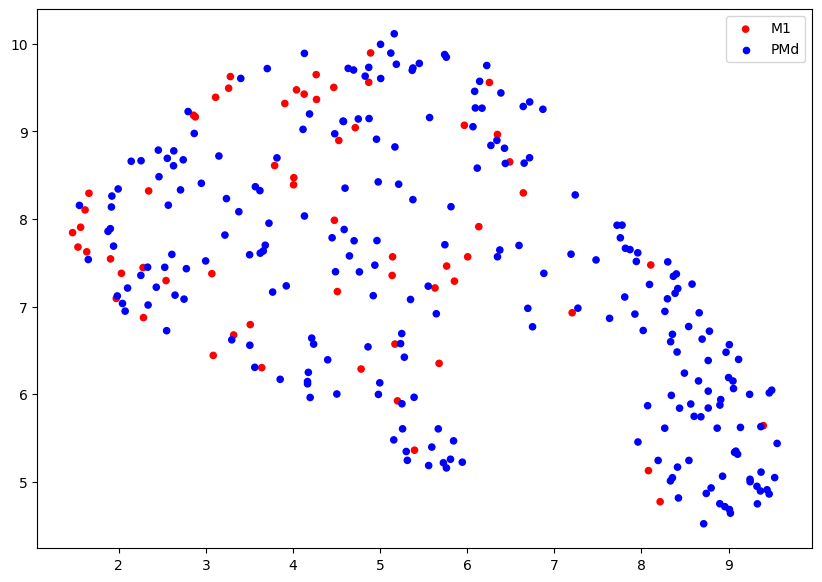

time: 146 ms (started: 2023-08-30 13:55:21 +01:00)


In [197]:
colors = ['red']*len(waveform_M1) + ['blue']*len(waveform_PMd)
plt.figure(figsize=(10, 7))
plt.scatter(umap_df['x'].tolist(), umap_df['y'].tolist(), marker='o', c=colors, s=20)
plt.scatter(umap_df['x'].tolist()[120], umap_df['y'].tolist()[120], marker='o', c=colors[120], s=20)
plt.legend(['M1', 'PMd'])

## Physiological Properties

In [ ]:
td = preprocessing_general(data_spikes)
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -6, 21, rates=False)
M1_neurons = len(waveform_M1)

11.483278536775144 8.721406076574265
1.3347022627659024 0.5076203886666589


/home/ad2022/MSc_project/PyalData/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


Text(1.87, 9.221406076574265, 'mean=8.72')

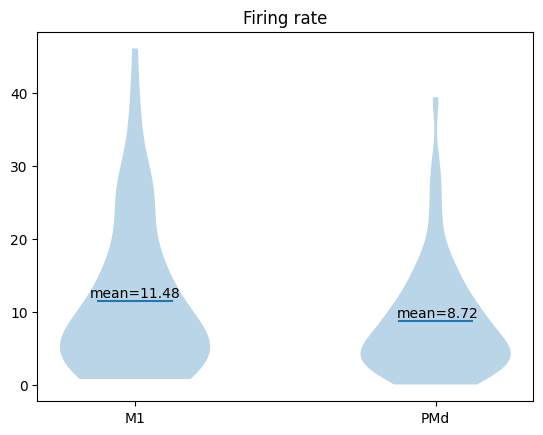

time: 91.1 ms (started: 2023-08-30 13:55:34 +01:00)


In [199]:
fr_neurons = get_average_firing_rates(td_processed, "both_spikes",divide_by_bin_size=None) 

fr_avg_M1 = np.mean(fr_neurons[:M1_neurons])
fr_avg_PMd = np.mean(fr_neurons[M1_neurons:])

fr_sme_M1 = np.std(fr_neurons[:M1_neurons])/math.sqrt(len(fr_neurons[:M1_neurons]))
fr_sme_PMd = np.std(fr_neurons[M1_neurons:])/math.sqrt(len(fr_neurons[M1_neurons:]))
print(fr_avg_M1, fr_avg_PMd)
print(fr_sme_M1, fr_sme_PMd)

fr = {'M1': fr_neurons[:M1_neurons], 'PMd': fr_neurons[M1_neurons:]}
#plt.boxplot(fr.values(), labels=fr.keys(), showmeans=True);
plt.violinplot(fr.values(), showmeans=True, showextrema=False)
plt.title('Firing rate');
plt.xticks([1,2], labels=['M1', 'PMd'])
plt.annotate(f'mean={round(fr_avg_M1, 2)}', (0.85, fr_avg_M1+0.5))
plt.annotate(f'mean={round(fr_avg_PMd, 2)}', (1.87, fr_avg_PMd+0.5))

0.256 0.34046808510638293
0.0174566128826108 0.01111986506283383


Text(1.87, 0.35046808510638294, 'mean=0.34')

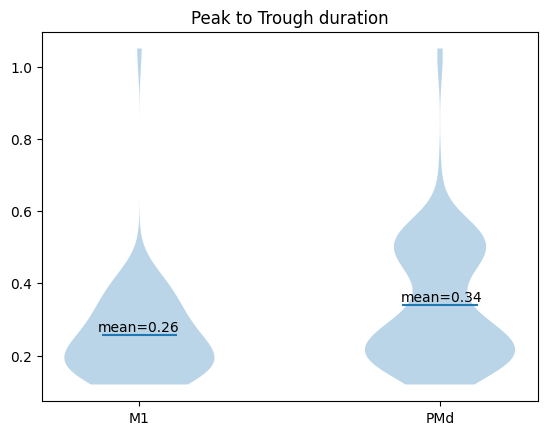

time: 86.3 ms (started: 2023-08-30 13:55:35 +01:00)


In [200]:
ptt_neurons = peak_to_trough_all(data_normalized)

ptt_avg_M1 = np.mean(ptt_neurons[:M1_neurons])
ptt_avg_PMd = np.mean(ptt_neurons[M1_neurons:])

ptt_sme_M1 = np.std(ptt_neurons[:M1_neurons])/math.sqrt(len(ptt_neurons[:M1_neurons]))
ptt_sme_PMd = np.std(ptt_neurons[M1_neurons:])/math.sqrt(len(ptt_neurons[M1_neurons:]))
print(ptt_avg_M1, ptt_avg_PMd)
print(ptt_sme_M1, ptt_sme_PMd)

ptt = {'M1': ptt_neurons[:M1_neurons], 'PMd': ptt_neurons[M1_neurons:]}
#plt.boxplot(ptt.values(), labels=ptt.keys(), showmeans=True);
plt.violinplot(ptt.values(), showmeans=True, showextrema=False)
plt.title('Peak to Trough duration');
plt.xticks([1,2], labels=['M1', 'PMd'])
plt.annotate(f'mean={round(ptt_avg_M1, 2)}', (0.86, ptt_avg_M1+0.01))
plt.annotate(f'mean={round(ptt_avg_PMd, 2)}', (1.87, ptt_avg_PMd+0.01))

0.121 0.14191460512080778
0.002997220935021864 0.002128674490259652


Text(1.87, 0.1519146051208078, 'mean=0.14')

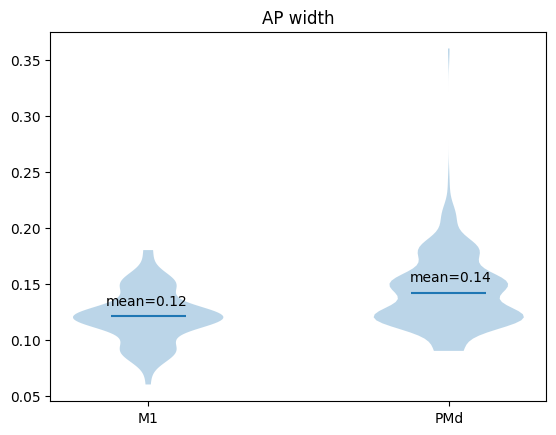

time: 90.8 ms (started: 2023-08-30 13:56:09 +01:00)


In [202]:
AP_neurons = AP_width_all(data_normalized)
AP_neurons[264] = np.mean(AP_neurons) # for C19 only

AP_avg_M1 = np.mean(AP_neurons[:M1_neurons])
AP_avg_PMd = np.mean(AP_neurons[M1_neurons:])

AP_sme_M1 = np.std(AP_neurons[:M1_neurons])/math.sqrt(len(AP_neurons[:M1_neurons]))
AP_sme_PMd = np.std(AP_neurons[M1_neurons:])/math.sqrt(len(AP_neurons[M1_neurons:]))
print(AP_avg_M1, AP_avg_PMd)
print(AP_sme_M1, AP_sme_PMd)

AP = {'M1': AP_neurons[:M1_neurons], 'PMd': AP_neurons[M1_neurons:]}
#plt.boxplot(AP.values(), labels=AP.keys(), showmeans=True);
plt.violinplot(AP.values(), showmeans=True, showextrema=False)
plt.title('AP width');
plt.xticks([1,2], labels=['M1', 'PMd'])
plt.annotate(f'mean={round(AP_avg_M1, 2)}', (0.86, AP_avg_M1+0.01))
plt.annotate(f'mean={round(AP_avg_PMd, 2)}', (1.87, AP_avg_PMd+0.01))

Text(1.82, 0.1519146051208078, 'mean=0.14')

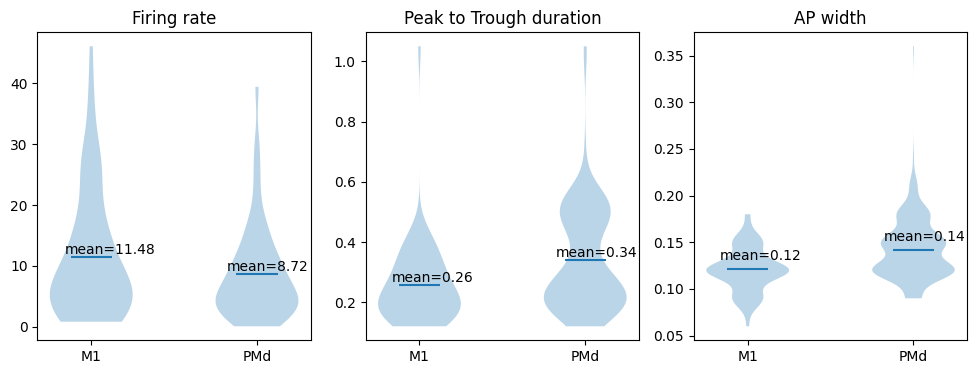

time: 218 ms (started: 2023-08-30 13:56:25 +01:00)


In [203]:
# plot all together
f, ax = plt.subplots(1,3, figsize=(12,4))

ax[0].violinplot(fr.values(), showmeans=True, showextrema=False)
ax[0].set_title('Firing rate');
ax[0].set_xticks([1,2], labels=['M1', 'PMd'])
ax[0].annotate(f'mean={round(fr_avg_M1, 2)}', (0.84, fr_avg_M1+0.5))
ax[0].annotate(f'mean={round(fr_avg_PMd, 2)}', (1.82, fr_avg_PMd+0.5))

ax[1].violinplot(ptt.values(), showmeans=True, showextrema=False)
ax[1].set_title('Peak to Trough duration');
ax[1].set_xticks([1,2], labels=['M1', 'PMd'])
ax[1].annotate(f'mean={round(ptt_avg_M1, 2)}', (0.83, ptt_avg_M1+0.01))
ax[1].annotate(f'mean={round(ptt_avg_PMd, 2)}', (1.82, ptt_avg_PMd+0.01))

ax[2].violinplot(AP.values(), showmeans=True, showextrema=False)
ax[2].set_title('AP width');
ax[2].set_xticks([1,2], labels=['M1', 'PMd'])
ax[2].annotate(f'mean={round(AP_avg_M1, 2)}', (0.83, AP_avg_M1+0.01))
ax[2].annotate(f'mean={round(AP_avg_PMd, 2)}', (1.82, AP_avg_PMd+0.01))

## Velocity Decoding

In [ ]:
len(waveform_M1)

In [ ]:
td = preprocessing_general(data_spikes)
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -6, 21, rates=True)

neuron_types = neuron_classes(clustering_solution) # neuron in each cluster
rep = 10 # repeat 10 times
mean_R2s = np.zeros((rep,2))
M1_neurons = len(waveform_M1)
PMd_neurons = len(waveform_PMd)

for neurons in ['M1', 'PMd']:
    for z in range(rep):
        print(z)
        
        move_td = td_processed.copy()
        
        if neurons == 'M1':
            pos = 0
            pca_dims = 20
            sampled_data = random.sample(list(np.arange(M1_neurons)), 35)
            for i in range(move_td.shape[0]):
                move_td.M1_rates[i] = move_td.M1_rates[i][:, sampled_data]
            move_td = dim_reduce(move_td, PCA(pca_dims), "M1_rates", "M1_pca")
            neural_data = concat_trials(move_td, "M1_pca")
            
        elif neurons == 'PMd':
            pos = 1
            pca_dims = 20
            sampled_data = random.sample(list(np.arange(PMd_neurons)), 35)
            for i in range(move_td.shape[0]):
                move_td.PMd_rates[i] = move_td.PMd_rates[i][:, sampled_data]
            move_td = dim_reduce(move_td, PCA(pca_dims), "PMd_rates", "PMd_pca")
            neural_data = concat_trials(move_td, "PMd_pca")
            
        # define what time period to use spikes from (with respect to the output)
        bins_before = 6
        bins_current = 1 
        bins_after = 6

        X = get_spikes_with_history(neural_data, bins_before, bins_after, bins_current)
        y = concat_trials(move_td, "vel")

        training_range = [0, 0.7]
        testing_range = [0.7, 0.85]
        valid_range = [0.85,1]

        X_train, X_test, X_valid, y_train, y_test, y_valid = split_data(X, y, training_range, testing_range, valid_range,
                                                                         bins_before, bins_current, bins_after, flat=False, zero_center=True)

        #Declare model
        model_lstm = LSTMDecoder(units=400,dropout=0,num_epochs=5)

        #Fit model
        model_lstm.fit(X_train,y_train)

        #Get predictions
        y_valid_predicted_lstm =  model_lstm.predict(X_valid)

        #Get metric of fit
        R2s_lstm = get_R2(y_valid,y_valid_predicted_lstm)
        mean_R2s[z,pos] = np.mean(R2s_lstm)
        

In [ ]:
mean_R2s

In [ ]:
r2 = [[0.69898387, 0.54059661],
       [0.63327955, 0.64491595],
       [0.73445831, 0.60047298],
       [0.69602864, 0.56269474],
       [0.73587208, 0.60424372],
       [0.68004614, 0.55878718],
       [0.65412882, 0.53776177],
       [0.6880832 , 0.3147122 ],
       [0.74227919, 0.59824516],
       [0.66256439, 0.54326111]]

plt.plot()
#_, _ = plot_R2(r2_old, [])
r2_mean, r2_sme = plot_R2(r2, [])
plt.title(r'$R^2$ from velocity decoding')
plt.xlabel(' ')
plt.xticks(ticks=[0,1], labels=['M1', 'PMd'])
plt.legend(['pca_dims=10', 'pca_dims=20'])
plt.show()

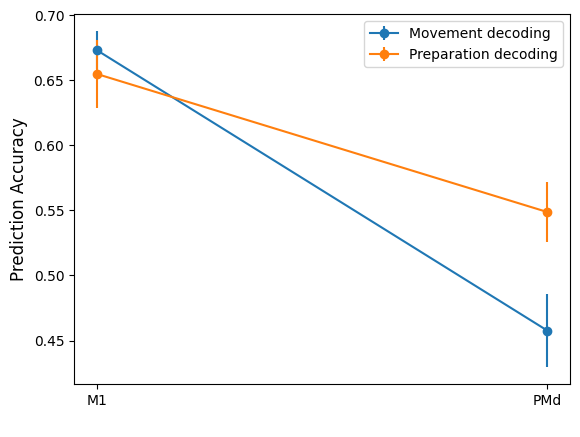

time: 223 ms (started: 2023-08-31 19:52:11 +01:00)


In [8]:
r2 = [[0.59182572, 0.52169531],
       [0.66785174, 0.41820323],
       [0.76799046, 0.38991485],
       [0.63375097, 0.53537696],
       [0.70390195, 0.55099863],
       [0.62808339, 0.58677276],
       [0.7066327 , 0.28007312],
       [0.68495181, 0.437944  ],
       [0.66807022, 0.46040314],
       [0.68047975, 0.39431983]]

acc = [[0.5   , 0.5625],
       [0.625 , 0.675 ],
       [0.75  , 0.5   ],
       [0.7125, 0.5125],
       [0.5875, 0.575 ],
       [0.55  , 0.5875],
       [0.7125, 0.4   ],
       [0.7625, 0.5625],
       [0.65  , 0.625 ],
       [0.7   , 0.4875]]

plt.plot()
_, _ = plot_R2(r2, [], color='#1f77b4')
_, _ = plot_R2(acc, [], color='#ff7f0e')
#plt.title(r'$R^2$ from velocity decoding')
plt.xlabel(' ')
plt.ylabel('Prediction Accuracy')
plt.xticks(ticks=[0,1], labels=['M1', 'PMd'])
plt.legend(['Movement decoding', 'Preparation decoding'])
plt.show()

### Velocity decoding vs pca_dims

In [ ]:
td = preprocessing_general(data_spikes)
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -2, 7, rates=True)

M1_neurons = len(waveform_M1)
PMd_neurons = len(waveform_PMd)

In [ ]:
r2_M1 = []
r2_PMd = []
dims_M1 = np.arange(5,M1_neurons,5)
dims_PMd = np.arange(5,PMd_neurons,5)
reps = 2

neurons = 'M1'
N_samples = 35
for pca_dims in dims_M1:
    if N_samples < pca_dims: N_samples = pca_dims+1
    r2, _, _ = movement_decoding_M1_or_PMd(td_processed, neurons, M1_neurons, PMd_neurons, N_samples=N_samples, pca_dims=pca_dims, repetitions=reps)
    r2_avg = np.mean(r2)
    r2_M1.append(r2_avg)
    
neurons = 'PMd'
N_samples = 35
for pca_dims in dims_PMd:
    if N_samples < pca_dims: N_samples = pca_dims+1
    r2, _, _ = movement_decoding_M1_or_PMd(td_processed, neurons, M1_neurons, PMd_neurons, N_samples=N_samples, pca_dims=pca_dims, repetitions=reps)
    r2_avg = np.mean(r2)
    r2_PMd.append(r2_avg)

r2_M1 = np.array(r2_M1)
r2_PMd = np.array(r2_PMd)

In [ ]:
np.savetxt('r2_PMd_M18.txt',r2_PMd)
np.savetxt('r2_M1_M18.txt',r2_M1)

#r2_PMd = np.loadtxt('r2_PMd_C15.txt')
#r2_M1 = np.loadtxt('r2_M1_C15.txt')

'''
M1_neurons = len(waveform_M1)
PMd_neurons = len(waveform_PMd)
dims_M1 = np.arange(5,M1_neurons,10)
dims_PMd = np.arange(5,PMd_neurons,10)
'''

In [ ]:
plt.plot(dims_PMd, r2_PMd, c='blue', label=f'PMd')
#plt.scatter(dims_PMd, accuracies_PMd, marker='.', facecolors='none', edgecolors='blue', s=20)
plt.plot(dims_M1, r2_M1, c='red', label=f'M1')
#plt.scatter(dims_M1, accuracies_M1, marker='.', facecolors='none', edgecolors='red', s=20)
plt.legend() 
plt.xlabel('PCA dimensions')
plt.ylabel('Velocity decoding accuracy ')

## Target Classifier

In [ ]:
len(waveform_PMd)

In [ ]:
# correct interval
#general preprocessing
td = preprocessing_general(data_spikes)
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -6, 1, rates=True)


In [ ]:
neuron_types = neuron_classes(clustering_solution) # neuron in each cluster
rep = 10 # repeat 10 times
accuracies = np.zeros((rep,2))
M1_neurons = len(waveform_M1)
PMd_neurons = len(waveform_PMd)

for neurons in ['M1', 'PMd']:
    for z in range(rep):
        print(z)
        
        move_td = td_processed.copy()
        y = []
        neural_spikes = []
        
        if neurons == 'M1':
            pos = 0
            pca_dims = 10
            sampled_data = random.sample(list(np.arange(M1_neurons)), 35)
            for i in range(move_td.shape[0]):
                move_td.M1_rates[i] = move_td.M1_rates[i][:, sampled_data]
            move_td = dim_reduce(move_td, PCA(pca_dims), "M1_rates", "M1_pca")
            neural_data = concat_trials(move_td, "M1_pca")
        
            for i in range(move_td.shape[0]):
                y.append(move_td.target_id[i])
                neural_spikes.append(move_td.M1_pca[i])
            
            
        elif neurons == 'PMd':
            pos = 1
            pca_dims = 10
            sampled_data = random.sample(list(np.arange(PMd_neurons)), 35)
            for i in range(move_td.shape[0]):
                move_td.PMd_rates[i] = move_td.PMd_rates[i][:, sampled_data]
            move_td = dim_reduce(move_td, PCA(pca_dims), "PMd_rates", "PMd_pca")
            neural_data = concat_trials(move_td, "PMd_pca")
            
            for i in range(move_td.shape[0]):
                neural_spikes.append(move_td.PMd_pca[i])
                y.append(move_td.target_id[i])
                    
        # define what time period to use spikes from (with respect to the output)
        bins_before = 6
        bins_current = 1 
        bins_after = 6

        y = np.array(y)
        X = np.array(neural_spikes)

        training_range = [0, 0.7]
        testing_range = [0.7, 0.85]
        valid_range = [0.85,1]

        X_train, X_test, X_valid, y_train, y_test, y_valid = split_data(X, y, training_range, testing_range, valid_range,
                                                                         bins_before, bins_current, bins_after, flat=False, zero_center=False)

        #Declare model
        LSTM_classifier = LSTMClassification(units=100, dropout=0, num_epochs=10)

        #Fit model
        LSTM_classifier.fit(X_train, y_train)

        #Get predictions
        y_predicitons =  LSTM_classifier.predict(X_valid)

        #Get metric of fit
        accuracy = np.sum(y_predicitons == y_valid) / float(len(y_predicitons))
        accuracies[z,pos] = accuracy


In [ ]:
accuracies

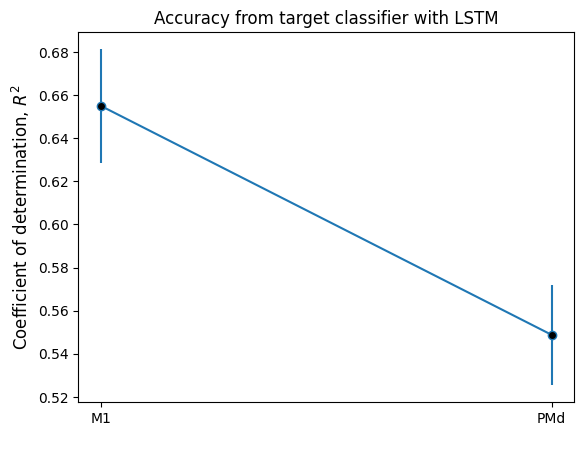

In [3]:
acc_old = []

acc = [[0.5   , 0.5625],
       [0.625 , 0.675 ],
       [0.75  , 0.5   ],
       [0.7125, 0.5125],
       [0.5875, 0.575 ],
       [0.55  , 0.5875],
       [0.7125, 0.4   ],
       [0.7625, 0.5625],
       [0.65  , 0.625 ],
       [0.7   , 0.4875]]

plt.plot()
#_, _ = plot_R2(acc_old, [])
acc_meanLSTM, acc_smeLSTM = plot_R2(acc, [])
plt.title('Accuracy from target classifier with LSTM')
plt.xlabel(' ')
#plt.legend(['pca_dims=10', 'pca_dims=20'])
plt.xticks(ticks=[0,1], labels=['M1', 'PMd'])
plt.show()

In [ ]:
# not used

# PCA
pca_dims_M1 = len(waveform_M1)
pca_dims_PMd = len(waveform_PMd)
pca_M1 = fit_dim_reduce_model(td_processed, PCA(pca_dims_M1), "M1_rates")
pca_PMd = fit_dim_reduce_model(td_processed, PCA(pca_dims_PMd), "PMd_rates")

for i in range(1, len(pca_M1.explained_variance_ratio_ )):
    pca_M1.explained_variance_ratio_[i] = pca_M1.explained_variance_ratio_[i] + pca_M1.explained_variance_ratio_[i-1]

for i in range(1, len(pca_PMd.explained_variance_ratio_ )):
    pca_PMd.explained_variance_ratio_[i] = pca_PMd.explained_variance_ratio_[i] + pca_PMd.explained_variance_ratio_[i-1]

t_M1 = list(range(1,pca_M1.explained_variance_ratio_.shape[0]+1))
t_PMd = list(range(1,pca_PMd.explained_variance_ratio_.shape[0]+1))

plt.plot(t_M1,pca_M1.explained_variance_ratio_, c='red', label='M1')
plt.plot(t_PMd,pca_PMd.explained_variance_ratio_, c='blue', label='PMd')

plt.scatter(t_M1,pca_M1.explained_variance_ratio_,marker='.', facecolors='none', edgecolors='red', s=20)
plt.scatter(t_PMd,pca_PMd.explained_variance_ratio_,marker='.', facecolors='none', edgecolors='blue', s=20)

max_line = max(len(waveform_M1), len(waveform_PMd))
plt.legend(loc='lower right')
plt.xlabel('Number of dimensions')
plt.ylabel('Variance explained')
plt.hlines(0.85, -10, max_line+10, color='k', linewidth=1, linestyle='--')
plt.vlines(25, -1, 2, color='k', linewidth=1, linestyle='--')
plt.vlines(115, -1, 2, color='k', linewidth=1, linestyle='--')
plt.ylim([0, 1.1])
plt.xlim([-10, max_line+10])
plt.xticks([0,25,50,115,150,200])
plt.show()


### Target classifier vs pca_dims

In [ ]:
# general preprocessing
td = preprocessing_general(data_spikes)
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -6, 1, rates=True)

M1_neurons = len(waveform_M1)
PMd_neurons = len(waveform_PMd)

#acc, _, _ = target_classifier_M1_PMd(td_processed, M1_neurons, PMd_neurons, N_samples=35, pca_dims=10, rep=2)

In [ ]:
M1_neurons

In [ ]:
# don't use this - use next one to allow different pca_dims for M1 and PMd
accuracies = []
min_num_neurons = np.min([M1_neurons, PMd_neurons])
dims = np.arange(5,min_num_neurons,2)
N_samples = 35
for pca_dims in dims:
    if N_samples < pca_dims: N_samples = pca_dims+1
    acc, _, _ = target_classifier_M1_PMd(td_processed, M1_neurons, PMd_neurons, N_samples=N_samples, pca_dims=pca_dims, rep=2)
    acc_avg = np.mean(acc, axis=0)
    accuracies.append(acc_avg)

accuracies = np.array(accuracies)

In [ ]:
accuracies_M1 = []
accuracies_PMd = []
dims_M1 = np.arange(5,M1_neurons,2)
dims_PMd = np.arange(5,PMd_neurons,2)
reps = 10

neurons = 'M1'
N_samples = 35
for pca_dims in dims_M1:
    if N_samples < pca_dims: N_samples = pca_dims+1
    acc, _, _ = target_classifier_M1_or_PMd(td_processed, neurons, M1_neurons, PMd_neurons, N_samples=N_samples, pca_dims=pca_dims, rep=reps)
    acc_avg = np.mean(acc)
    accuracies_M1.append(acc_avg)
    
neurons = 'PMd'
N_samples = 35
for pca_dims in dims_PMd:
    if N_samples < pca_dims: N_samples = pca_dims+1
    acc, _, _ = target_classifier_M1_or_PMd(td_processed, neurons, M1_neurons, PMd_neurons, N_samples=N_samples, pca_dims=pca_dims, rep=reps)
    acc_avg = np.mean(acc)
    accuracies_PMd.append(acc_avg)

accuracies_M1 = np.array(accuracies_M1)
accuracies_PMd = np.array(accuracies_PMd)

In [240]:
#np.savetxt('accuracies_PMd_M18.txt',accuracies_PMd)
#np.savetxt('accuracies_M1_M18.txt',accuracies_M1)

accuracies_PMd = np.loadtxt('accuracies_PMd_C19.txt')
accuracies_M1 = np.loadtxt('accuracies_M1_C19.txt')

M1_neurons = len(waveform_M1)
PMd_neurons = len(waveform_PMd)

dims_M1 = np.arange(5,M1_neurons,2)
dims_PMd = np.arange(5,PMd_neurons,2)


time: 1.87 ms (started: 2023-08-08 14:01:07 +01:00)


Text(0, 0.5, 'Target classifier accuracy ')

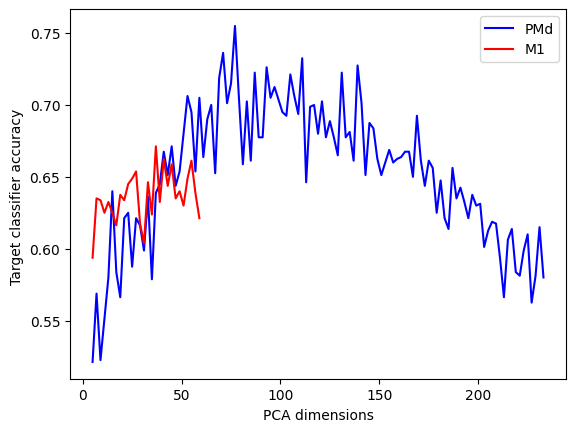

time: 92 ms (started: 2023-08-08 14:01:10 +01:00)


In [241]:
plt.plot(dims_PMd, accuracies_PMd, c='blue', label=f'PMd')
#plt.scatter(dims_PMd, accuracies_PMd, marker='.', facecolors='none', edgecolors='blue', s=20)
plt.plot(dims_M1, accuracies_M1, c='red', label=f'M1')
#plt.scatter(dims_M1, accuracies_M1, marker='.', facecolors='none', edgecolors='red', s=20)
plt.legend() 
plt.xlabel('PCA dimensions')
plt.ylabel('Target classifier accuracy ')

## Clusters: M1 or PMd

In [38]:
# check if some clusters have more neurons from M1 or PMd
neurons_M1 = []
neurons_PMd = []
for neuron in range(waveform_filtered.shape[0]):
    if waveform_filtered.array.iloc[neuron] == 'M1':
        neurons_M1.append(neuron)
    elif waveform_filtered.array.iloc[neuron] == 'PMd':
        neurons_PMd.append(neuron)
        
neuron_types = neuron_classes(clustering_solution)
neurons_ = {'M1': [0]*len(neuron_types), 'PMd': [0]*len(neuron_types)}

for neuron in range(waveform_filtered.shape[0]):
    if waveform_filtered.array.iloc[neuron] == 'M1':
        neurons_['M1'][clustering_solution[neuron]] += 1
    if waveform_filtered.array.iloc[neuron] == 'PMd':
        neurons_['PMd'][clustering_solution[neuron]] += 1


neurons = neurons_in_cluster(clustering_solution)
ratio_M1 = [int(np.round(M/tot*100)) for M,tot in zip(neurons_['M1'], neurons)]
ratio_PMd = [100-M for M in ratio_M1]

time: 13.6 ms (started: 2023-09-01 12:25:29 +01:00)


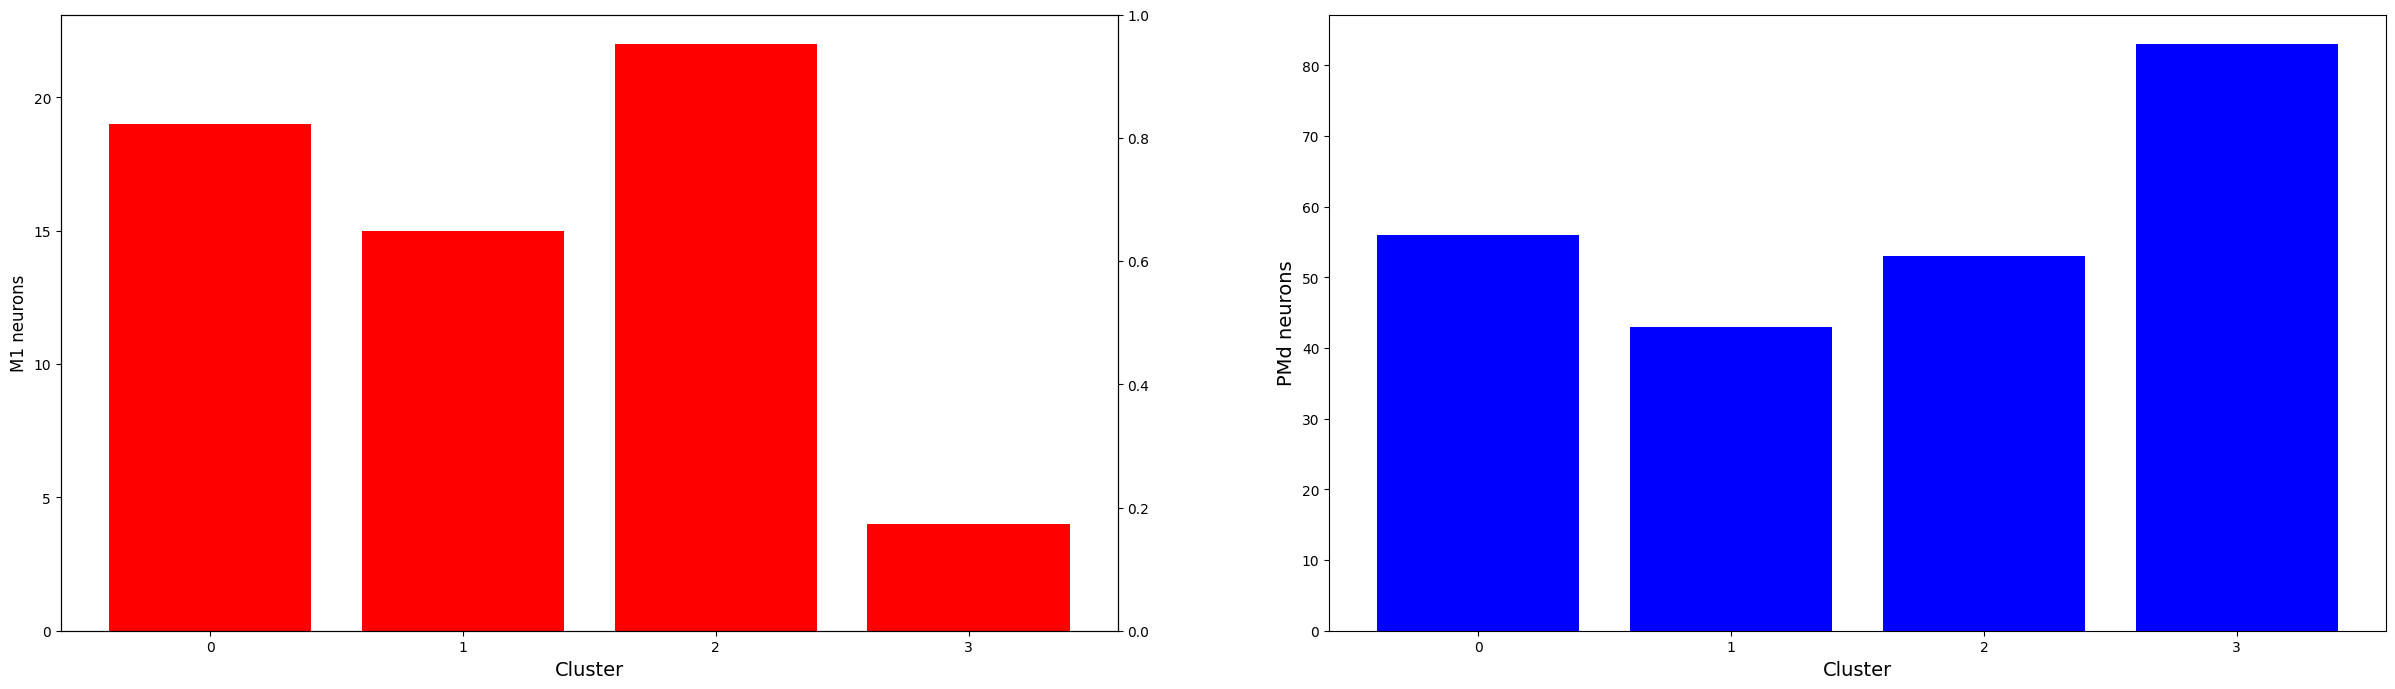

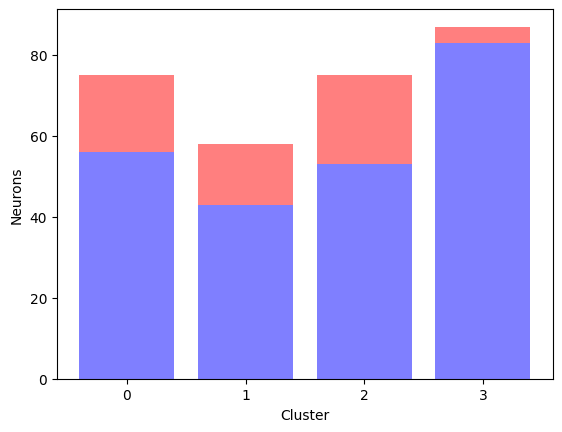

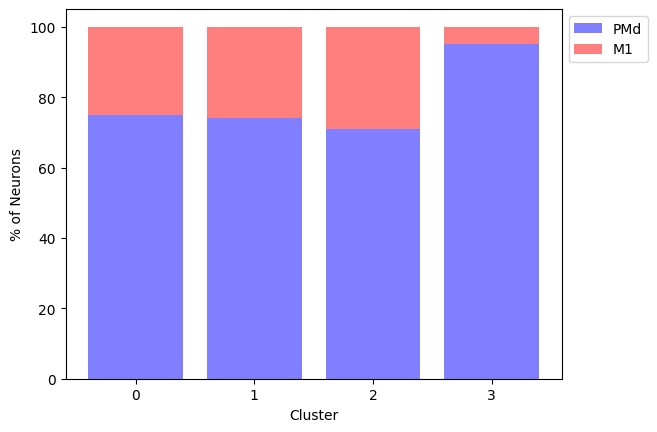

time: 301 ms (started: 2023-09-01 12:26:05 +01:00)


In [40]:
# plot number of neurons from M1 and PMd in each cluster
x = np.arange(len(neuron_types))

f, ax = plt.subplots(1,2, figsize=(30,8))
ax[0].bar(x, neurons_['M1'], color='r')
ax[0].set_xticks([0,1,2,3],labels=[0,1,2,3])
#ax[0].set_title('Neurons from M1 in each class')
ax[0].set_ylabel('M1 neurons', fontsize=12)
ax[0].set_xlabel('Cluster', fontsize=14)
ax2 = ax[0].twinx()

ax[1].bar(x, neurons_['PMd'], color='b')
ax[1].set_xticks([0,1,2,3])
#ax[1].set_title('Neurons from PMd in each class')
ax[1].set_ylabel('PMd neurons', fontsize=14)
ax[1].set_xlabel('Cluster', fontsize=14);
plt.show()


plt.bar(x, neurons_['PMd'], color='b', label='PMd neurons', alpha=0.5)
bot = neurons_['PMd']
plt.bar(x, neurons_['M1'], color='r', label='M1 neurons', bottom=bot, alpha=0.5)
plt.xlabel('Cluster')
plt.ylabel('Neurons')
plt.xticks([0,1,2,3])
#plt.legend(bbox_to_anchor=(1.305,1))
plt.show()

plt.bar(x, ratio_PMd, color='b', label='PMd', alpha=0.5)
bot = ratio_PMd
plt.bar(x, ratio_M1, color='r', label='M1', bottom=bot, alpha=0.5)
plt.xlabel('Cluster')
plt.ylabel('% of Neurons')
plt.xticks([0,1,2,3])
plt.legend(bbox_to_anchor=(1,1))
plt.show()

/home/ad2022/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ad2022/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ad2022/.local/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ad2022/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ad2022/.local/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Velocity decoding accuracy, $R^2$')

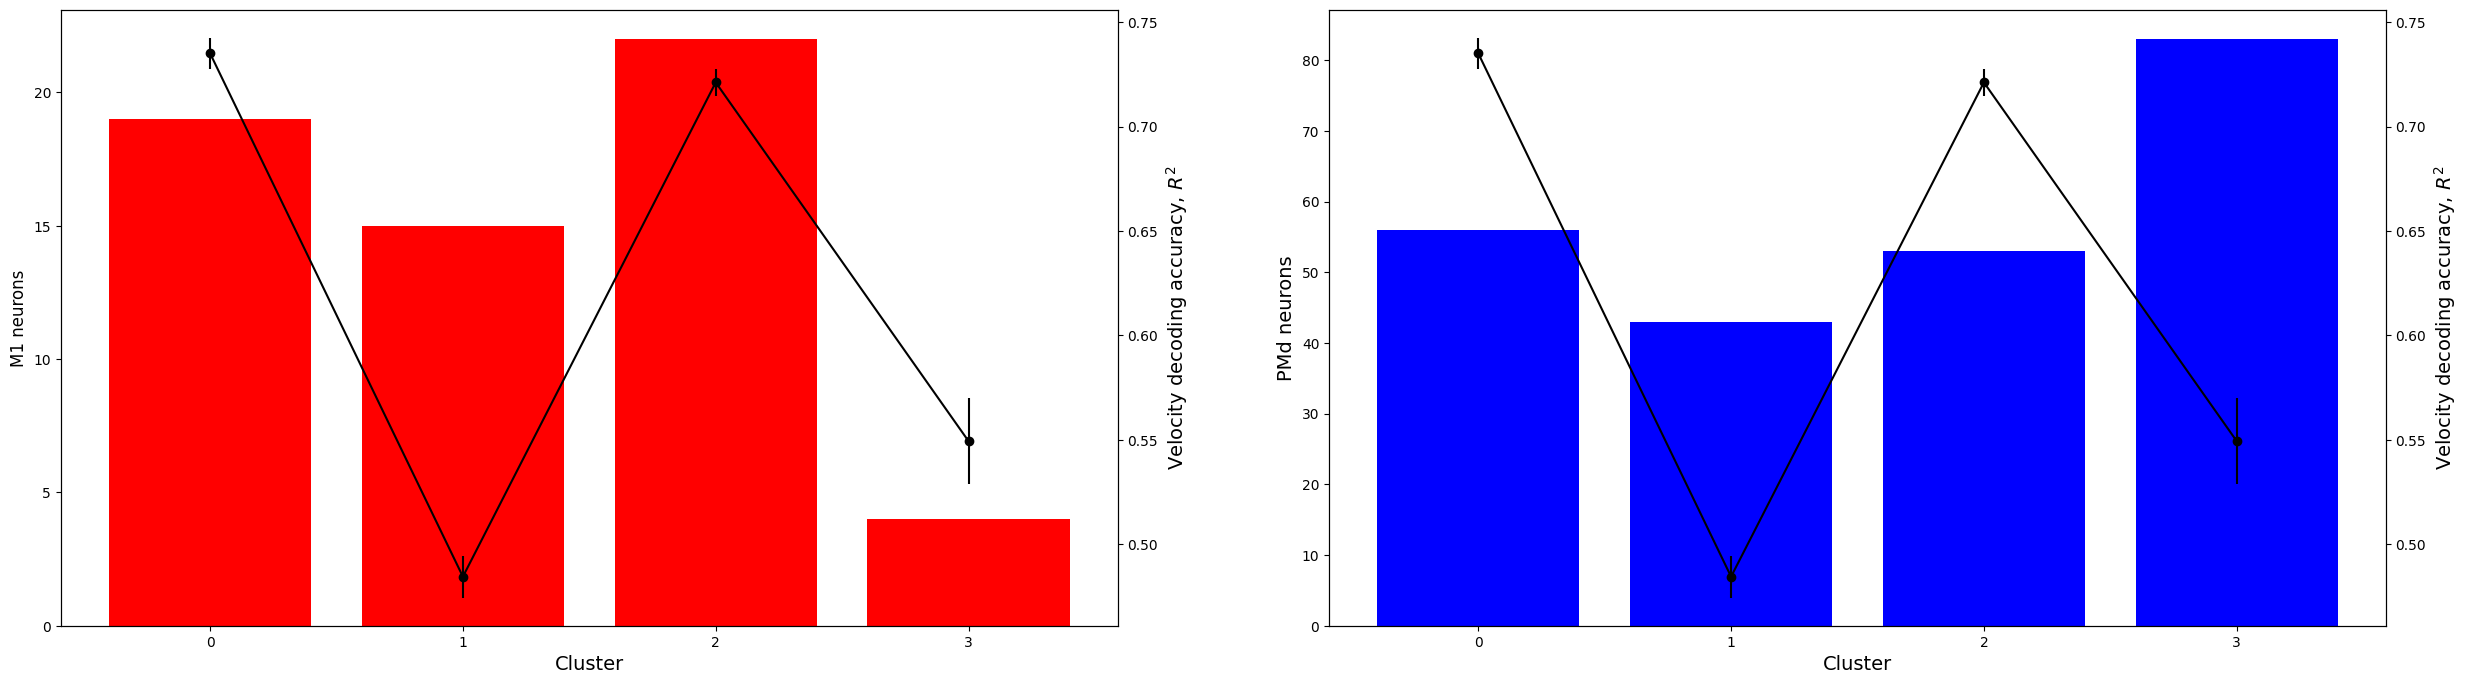

time: 255 ms (started: 2023-08-30 13:43:19 +01:00)


In [194]:
x = np.arange(len(neuron_types))

f, ax = plt.subplots(1,2, figsize=(30,8))
ax[0].bar(x, neurons_['M1'], color='r')
ax[0].set_xticks([0,1,2,3],labels=[0,1,2,3])
#ax[0].set_title('Neurons from M1 in each class')
ax[0].set_ylabel('M1 neurons', fontsize=12)
ax[0].set_xlabel('Cluster', fontsize=14)
ax2 = ax[0].twinx()
_, _ = plot_R2(r2, [])
ax2.set_ylabel(r'Velocity decoding accuracy, $R^2$', fontsize=14)
#ax2.set_ylabel('Target classifier accuracy', fontsize=14)

ax[1].bar(x, neurons_['PMd'], color='b')
ax[1].set_xticks([0,1,2,3],labels=[0,1,2,3])
#ax[1].set_title('Neurons from PMd in each class')
ax[1].set_ylabel('PMd neurons', fontsize=14)
ax[1].set_xlabel('Cluster', fontsize=14);
ax2 = ax[1].twinx()
_, _ = plot_R2(r2, [])
ax2.set_ylabel(r'Velocity decoding accuracy, $R^2$', fontsize=14)
#ax2.set_ylabel('Target classifier accuracy', fontsize=14)


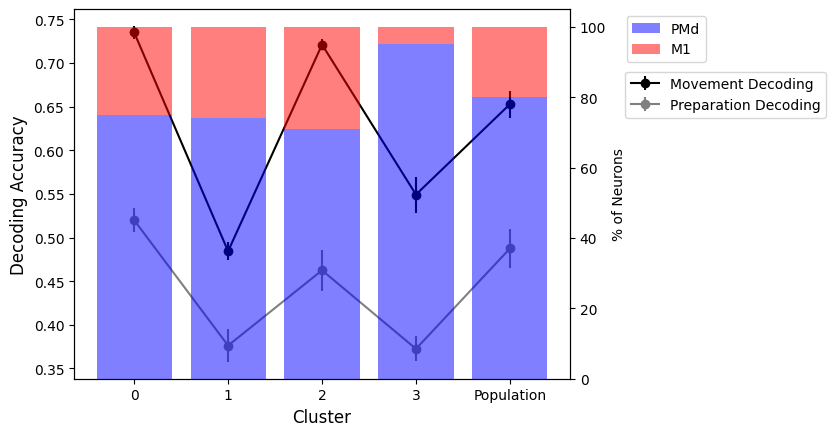

time: 161 ms (started: 2023-08-30 13:43:20 +01:00)


In [195]:
r2 = [[0.69769582, 0.46559943, 0.73024136, 0.56559442],
       [0.7461994 , 0.45198536, 0.74236074, 0.57096739],
       [0.77003291, 0.51529288, 0.72753891, 0.4722226 ],
       [0.73645249, 0.4507195 , 0.67709964, 0.59805566],
       [0.75415431, 0.4744763 , 0.72575772, 0.64098665],
       [0.76026422, 0.52830004, 0.69270418, 0.59200074],
       [0.71210494, 0.51312046, 0.74435956, 0.5874625 ],
       [0.71425813, 0.45833375, 0.72871525, 0.4487798 ],
       [0.70980356, 0.53182681, 0.71437418, 0.44430007],
       [0.75020772, 0.45435731, 0.72856192, 0.57274672]]

# R2 sampling neurons randomly from dataset
r2_all = [0.73004527, 0.64521315, 0.64074874, 0.71642717, 0.66570785,
          0.65330659, 0.57460691, 0.56035182, 0.69240019, 0.59663886,
          0.72397785, 0.63487378]

acc = [[0.525 , 0.375 , 0.475 , 0.4   ],
       [0.55  , 0.4375, 0.45  , 0.4375],
       [0.5625, 0.3875, 0.5875, 0.2875],
       [0.4625, 0.375 , 0.475 , 0.35  ],
       [0.4875, 0.3625, 0.5375, 0.4   ],
       [0.5875, 0.225 , 0.3125, 0.3375],
       [0.5   , 0.4375, 0.4   , 0.4125],
       [0.45  , 0.4   , 0.425 , 0.4   ],
       [0.55  , 0.3375, 0.4375, 0.3125],
       [0.525 , 0.425 , 0.525 , 0.3875]]


acc_all = [0.6   , 0.475 , 0.5125, 0.5125, 0.625 ,
           0.425 , 0.5125, 0.35, 0.375 , 0.5   ,
           0.4875, 0.475 ]

x = np.arange(len(neuron_types))
_, _ = plot_R2(r2, r2_all)
_, _ = plot_R2(acc, acc_all, color='gray')
plt.legend(['Movement Decoding','Preparation Decoding'], 
          bbox_to_anchor=(1.53,0.85))
plt.ylabel('Decoding Accuracy')
plt.xlabel('Cluster', fontsize=12)

ax = plt.gca()
ax2 = plt.twinx()

rPMd = ratio_PMd+[int(np.round(100*len(neurons_PMd)/np.sum(neurons)))]
rM1 = ratio_M1+[int(np.round(100*len(neurons_M1)/np.sum(neurons)))]

ax2.bar(np.append(x, x[-1]+1), rPMd, color='b', label='PMd', alpha=0.5)
bot = rPMd
ax2.bar(np.append(x, x[-1]+1), rM1, color='r', label='M1', bottom=bot, alpha=0.5)
ax2.set_ylabel('% of Neurons')
ax2.set_xticks([0,1,2,3,4], labels=['0','1','2','3','Population'])
#ax2.set_xlabel('Cluster')
ax2.legend(bbox_to_anchor=(1.1,1))

'''
ax2.bar(x, neurons_['PMd'], color='b', label='PMd neurons', alpha=0.5)
bot = neurons_['PMd']
ax2.bar(x, neurons_['M1'], color='r', label='M1 neurons', bottom=bot, alpha=0.5)
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Neurons')
ax2.set_xticks([0,1,2,3],labels=[1,2,3,4])
ax2.legend(bbox_to_anchor=(1.1,1))
''';



### Correlation waveform - not used

In [ ]:
waveform_filtered.head(n=1)

In [ ]:
neurons_tot = len(clustering_solution)

correlation_wv = np.zeros((neurons_tot, neurons_tot))

waveforms_M1 = []
waveforms_PMd = []

for neuron in range(waveform_filtered.shape[0]):
    if waveform_filtered.iloc[neuron]['array'] == 'M1':
        waveforms_M1.append(umap_df.iloc[neuron]['waveform'])
    if waveform_filtered.iloc[neuron]['array'] == 'PMd':
        waveforms_PMd.append(umap_df.iloc[neuron]['waveform'])

In [ ]:
waveforms_M1_avg = np.mean(waveforms_M1, axis=0)
waveforms_PMd_avg = np.mean(waveforms_PMd, axis=0)

In [ ]:
for i in range(0, len(waveforms_PMd), 2):
    plt.plot(waveforms_PMd[i], c='g', alpha=0.3)
    if i < len(waveforms_M1):
        plt.plot(waveforms_M1[i], c='r')    
plt.plot(waveforms_M1_avg, c='b', label='Avg M1')
plt.plot(waveforms_PMd_avg, c='k', label='Avg PMd')
plt.legend(bbox_to_anchor=(1,1))

In [ ]:
f, ax = plt.subplots(2,1, figsize=(7,6))
for i in range(0, len(waveforms_PMd), 2):
    ax[0].plot(waveforms_PMd[i], c='g', alpha=0.3)
    if i < len(waveforms_M1):
        ax[1].plot(waveforms_M1[i], c='r', alpha=0.4)    

ax[0].plot(waveforms_PMd_avg, c='k')
ax[0].set_title(label='PMd')
ax[1].plot(waveforms_M1_avg, c='b')
ax[1].set_title(label='M1')

In [ ]:
corr = np.corrcoef(waveforms_M1)
sns.heatmap(corr); 
# ?? 

# dPCA

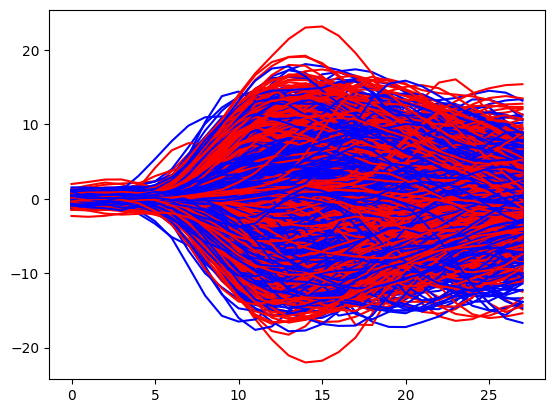

time: 605 ms (started: 2023-08-10 14:06:27 +01:00)


In [79]:
for trial in range(td_processed.shape[0]):
    plt.plot(td_processed.vel[trial][:,0], c='r')
    plt.plot(td_processed.vel[trial][:,1], c='b')

In [ ]:
# preprocessing
td = preprocessing_general(data_spikes, combine=True, std=0.05)
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -6, 21, rates=True)


In [8]:
target_index = trials_per_target(td_processed)
tr_per_target = []
for i in range(len(target_index)):
    tr_per_target.append(len(target_index[i]))

tr_per_target = np.array(tr_per_target)
tr_per_target = tr_per_target[tr_per_target != 0]
#tr_per_target

time: 23.4 ms (started: 2023-08-10 13:46:22 +01:00)


In [ ]:
# dPCA on all neurons from M1
'''
# check original size of data
print(td_processed.shape) # num trials, fields
print(td_processed.both_spikes[0].shape) # time, num neurons
# trial, time, neurons
'''

# we want to reshape data according to the following:
# [num of trials in each target, num of neurons, num of targets, time point]
num_trials = td_processed.shape[0]
#num_neurons = td_processed.both_rates[0].shape[1]
num_neurons = trials_to_keep_M1[-1]+1
num_targets = len(tr_per_target)
min_per_target = np.min(tr_per_target)
num_time = td_processed.both_rates[0].shape[0]


data = np.zeros((min_per_target, num_neurons, num_targets, num_time))
tr_per_target_found = [0]*num_targets

for trial in range(num_trials):
    targetID = td_processed.target_id[trial] # ID of target of this trial
    if tr_per_target_found[targetID] >= min_per_target: continue
    data[tr_per_target_found[targetID], :, targetID, :] = np.transpose(td_processed.both_rates[trial][:,trials_to_keep_M1])
    tr_per_target_found[targetID] += 1 # trials for this target already found
    
avg_trial_per_target = np.mean(data, axis=0)

# apply dPCA 
dpca = dPCA.dPCA(labels='st',regularizer='auto', n_components=10)
dpca.protect = ['t']
Z_all = dpca.fit_transform(avg_trial_per_target, data)
    
'''
only to check shapes are correct
print(data.shape)
print(avg_trial_per_target.shape)
'''

In [ ]:
# dPCA on all neurons - modified -> I think modified is wrong
'''
# check original size of data
print(td_processed.shape) # num trials, fields
print(td_processed.both_spikes[0].shape) # time, num neurons
# trial, time, neurons
'''

# we want to reshape data according to the following:
# [num of trials in each target, num of neurons, num of targets, time point]
num_trials = td_processed.shape[0]
num_neurons = td_processed.both_rates[0].shape[1]

num_targets = len(tr_per_target)
min_per_target = np.min(tr_per_target)
num_time = td_processed.both_rates[0].shape[0]

data = np.zeros((min_per_target, num_neurons, num_time, num_targets))
tr_per_target_found = [0]*num_targets

for trial in range(num_trials):
    targetID = td_processed.target_id[trial] # ID of target of this trial
    if tr_per_target_found[targetID] >= min_per_target: continue
    data[tr_per_target_found[targetID], :, :, targetID] = np.transpose(td_processed.both_rates[trial])
    tr_per_target_found[targetID] += 1 # trials for this target already found
    
avg_trial_per_target = np.mean(data, axis=0)

# apply dPCA 
dpca = dPCA.dPCA(labels='st',regularizer='auto', n_components=10)
dpca.protect = ['t']
Z_all = dpca.fit_transform(avg_trial_per_target, data)
    

'''
only to check shapes are correct
print(data.shape)
print(avg_trial_per_target.shape)
'''

In [123]:
num_targets = len(tr_per_target)
targets = [0]*num_targets

for trial in range(td_processed.shape[0]):
    targetID = td_processed.target_id[trial]
    targets[targetID] = td_processed.target_direction[trial]
    
targets_deg = [ang*180/np.pi for ang in targets]
targets_deg

[-135.0, -90.0, -45.0, 0.0, 45.0, 90.0, 135.0, 180.0]

time: 11 ms (started: 2023-08-10 14:20:07 +01:00)


In [ ]:
# dPCA on all neurons
'''
# check original size of data
print(td_processed.shape) # num trials, fields
print(td_processed.both_spikes[0].shape) # time, num neurons
# trial, time, neurons
'''

# we want to reshape data according to the following:
# [num of trials in each target, num of neurons, num of targets, time point]
num_trials = td_processed.shape[0]
num_neurons = td_processed.both_rates[0].shape[1]
num_targets = len(tr_per_target)
min_per_target = np.min(tr_per_target)
num_time = td_processed.both_rates[0].shape[0]

num_targets = 5
data = np.zeros((min_per_target, num_neurons, num_targets, num_time))
tr_per_target_found = [0]*num_targets

for trial in range(num_trials):
    targetID = td_processed.target_id[trial] # ID of target of this trial
    '''
    if 1 < targetID < 5: continue 
    if targetID >= 5:
        targetID -= 3
    print(targetID)
    #targetID -= 1
    '''
    '''
    if targetID > 3: continue
    #targetID -= 3
    '''
    if targetID < 1 or targetID > 5: continue
    targetID -= 1
    if tr_per_target_found[targetID] >= min_per_target: continue
    data[tr_per_target_found[targetID], :, targetID, :] = np.transpose(td_processed.both_rates[trial])
    tr_per_target_found[targetID] += 1 # trials for this target already found
    
avg_trial_per_target = np.mean(data, axis=0)

# apply dPCA 
dpca = dPCA.dPCA(labels='st',regularizer='auto', n_components=10)
dpca.protect = ['t']
Z_all = dpca.fit_transform(avg_trial_per_target, data)
    
'''
only to check shapes are correct
print(data.shape)
print(avg_trial_per_target.shape)
'''

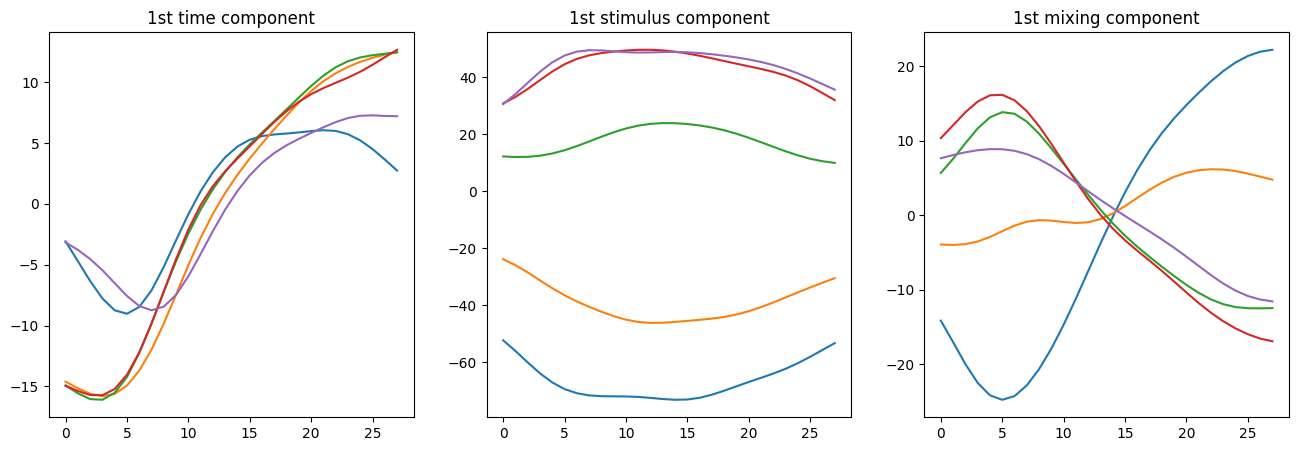

time: 244 ms (started: 2023-08-10 14:42:11 +01:00)


In [180]:
# plot 
time = np.arange(num_time)

plt.figure(figsize=(16,5))
plt.subplot(131)
for s in range(num_targets):
    plt.plot(time,Z_all['t'][0,s])
plt.title(f'1st time component')

plt.subplot(132)

for s in range(num_targets):
    plt.plot(time,Z_all['s'][0,s])
plt.title(f'1st stimulus component')

plt.subplot(133)

for s in range(num_targets):
    plt.plot(time,Z_all['st'][0,s]) 
plt.title(f'1st mixing component')

plt.show()


In [ ]:
neurons = neurons_in_cluster(clustering_solution)
neurons

In [ ]:
# sample neurons

# we want to reshape data according to the following:
# [num of trials in each target, num of neurons, num of targets, time point]

num_trials = td_processed.shape[0] # number of trials in total
num_neurons = td_processed.both_rates[0].shape[1] # number of neurons
num_targets = len(tr_per_target) # number of targets
min_per_target = np.min(tr_per_target) # min number of trails going to the same target
num_time = td_processed.both_rates[0].shape[0] # time window length

neuron_types = neuron_classes(clustering_solution) # neurons in each cluster
N_samples = 15

Z_all = {}

# to find transofrmation matrix
transf_matrix_t = {}
transf_matrix_s = {}
transf_matrix_st = {}

for clust in range(len(neuron_types)):
        Z_all[f'{clust}'] = []
        transf_matrix_t[f'{clust}'] = []
        transf_matrix_s[f'{clust}'] = []
        transf_matrix_st[f'{clust}'] = []

for cluster in range(len(neuron_types)):

    sampled_data = sample_neurons(neuron_types, N_samples)
    data = np.zeros((min_per_target, N_samples, num_targets, num_time))
    tr_per_target_found = [0]*num_targets

    for trial in range(num_trials):
        targetID = td_processed.target_id[trial] # ID of target of this trial
        if tr_per_target_found[targetID] >= min_per_target: continue # only save min_per_target trials for each target
        data[tr_per_target_found[targetID], :, targetID, :] = np.transpose(td_processed.both_rates[trial][:,sampled_data[cluster]])
        tr_per_target_found[targetID] += 1 # trials for this target already found

    avg_trial_per_target = np.mean(data, axis=0)
    
    # apply dPCA 
    dpca = dPCA.dPCA(labels='st',regularizer='auto', n_components=10)
    dpca.protect = ['t']
    Z_all[f'{cluster}'] = dpca.fit_transform(avg_trial_per_target, data)
    
    # compute inverse of avg data
    data_avg_inv = np.linalg.pinv(avg_trial_per_target)

    # compute transformation matrices for each cluster
    transf_matrix_t[f'{cluster}'] = np.matmul(np.transpose(data_avg_inv,[2,0,1]),np.transpose(Z_all[f'{cluster}']['t'],[1,2,0]))
    transf_matrix_s[f'{cluster}'] = np.matmul(np.transpose(data_avg_inv,[2,0,1]),np.transpose(Z_all[f'{cluster}']['s'],[1,2,0]))
    transf_matrix_st[f'{cluster}'] = np.matmul(np.transpose(data_avg_inv,[2,0,1]),np.transpose(Z_all[f'{cluster}']['st'],[1,2,0]))


In [ ]:
# plot 
time = np.arange(num_time)


for cluster in range(len(neuron_types)):
    plt.figure(figsize=(16,5))
    plt.subplot(131)
    for s in range(num_targets):
        plt.plot(time,Z_all[f'{cluster}']['t'][0,s])
    plt.title(f'1st time component, cluster {cluster}')

    plt.subplot(132)

    for s in range(num_targets):
        plt.plot(time,Z_all[f'{cluster}']['s'][0,s])
    plt.title(f'1st stimulus component, cluster {cluster}')

    plt.subplot(133)

    for s in range(num_targets):
        plt.plot(time,Z_all[f'{cluster}']['st'][0,s]) 
    plt.title(f'1st mixing component, cluster {cluster}')

    plt.show()


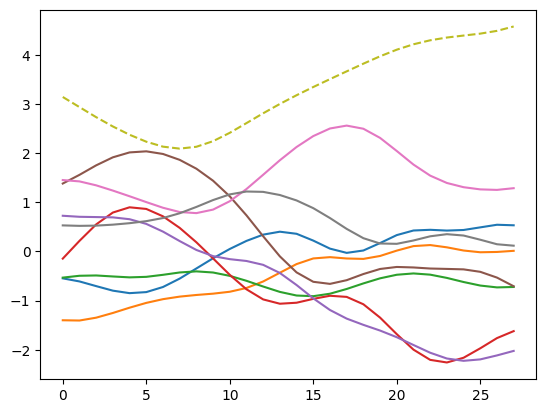

time: 84.7 ms (started: 2023-08-08 11:54:43 +01:00)


In [211]:
# ????????
rates_avg.shape
sampled_3 = [115, 123, 137, 261, 143, 214, 285, 252, 163, 237, 190, 178, 266, 3, 164]

avg_trial_per_target.shape
plt.plot(avg_trial_per_target[0]);

plt.plot(rates_avg[:, sampled_3[0]], '--');
# ?????? 

In [ ]:
# sample neurons - modified

# we want to reshape data according to the following:
# [num of trials in each target, num of neurons, num of targets, time point]

num_trials = td_processed.shape[0] # number of trials in total
num_neurons = td_processed.both_rates[0].shape[1] # number of neurons
num_targets = len(tr_per_target) # number of targets
min_per_target = np.min(tr_per_target) # min number of trails going to the same target
num_time = td_processed.both_rates[0].shape[0] # time window length

neuron_types = neuron_classes(clustering_solution) # neurons in each cluster
N_samples = 40

Z_all = {}

# to find transofrmation matrix
transf_matrix_t = {}
transf_matrix_s = {}
transf_matrix_st = {}

for clust in range(len(neuron_types)):
        Z_all[f'{clust}'] = []
        transf_matrix_t[f'{clust}'] = []
        transf_matrix_s[f'{clust}'] = []
        transf_matrix_st[f'{clust}'] = []

for cluster in range(len(neuron_types)):

    sampled_data = sample_neurons(neuron_types, N_samples)
    data = np.zeros((min_per_target, N_samples, num_time, num_targets))
    tr_per_target_found = [0]*num_targets
    
    for trial in range(num_trials):
        targetID = td_processed.target_id[trial] # ID of target of this trial
        if tr_per_target_found[targetID] >= min_per_target: continue # only save min_per_target trials for each target
        data[tr_per_target_found[targetID], :, :, targetID] = np.transpose(td_processed.both_rates[trial][:,sampled_data[cluster]])
        tr_per_target_found[targetID] += 1 # trials for this target already found

    avg_trial_per_target = np.mean(data, axis=0)
    
    # center data
    #avg_trial_per_target -= np.mean(avg_trial_per_target.reshape((N_samples,-1)),1)[:,None,None]

    # apply dPCA 
    dpca = dPCA.dPCA(labels='st',regularizer='auto', n_components=10)
    dpca.protect = ['t']
    Z_all[f'{cluster}'] = dpca.fit_transform(avg_trial_per_target, data)
    
    # compute inverse of avg data
    data_avg_inv = np.linalg.pinv(avg_trial_per_target)

    # compute transformation matrices for each cluster
    transf_matrix_t[f'{cluster}'] = np.matmul(np.transpose(data_avg_inv,[2,0,1]),np.transpose(Z_all[f'{cluster}']['t'],[1,2,0]))
    transf_matrix_s[f'{cluster}'] = np.matmul(np.transpose(data_avg_inv,[2,0,1]),np.transpose(Z_all[f'{cluster}']['s'],[1,2,0]))
    transf_matrix_st[f'{cluster}'] = np.matmul(np.transpose(data_avg_inv,[2,0,1]),np.transpose(Z_all[f'{cluster}']['st'],[1,2,0]))


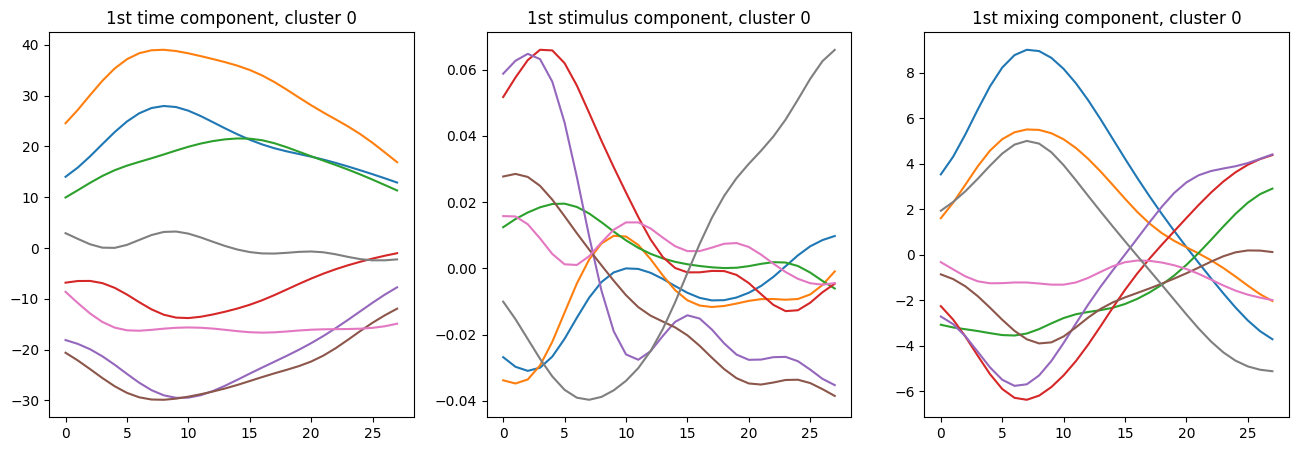

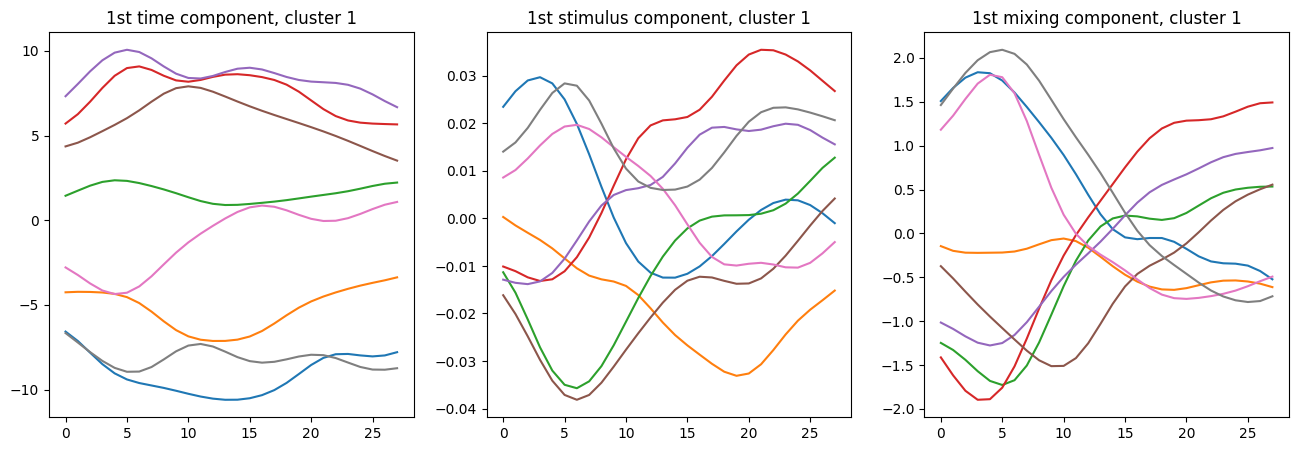

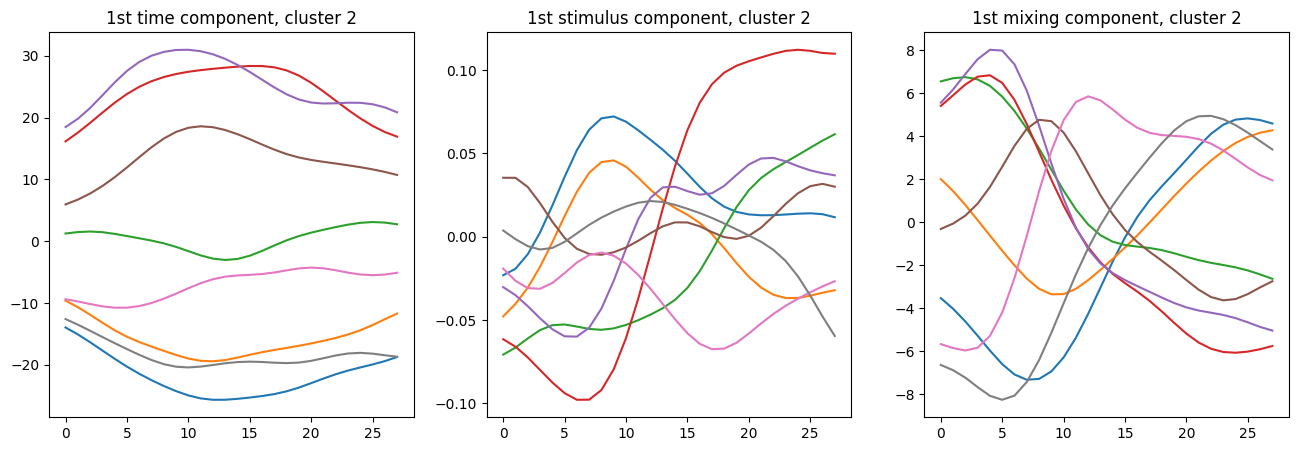

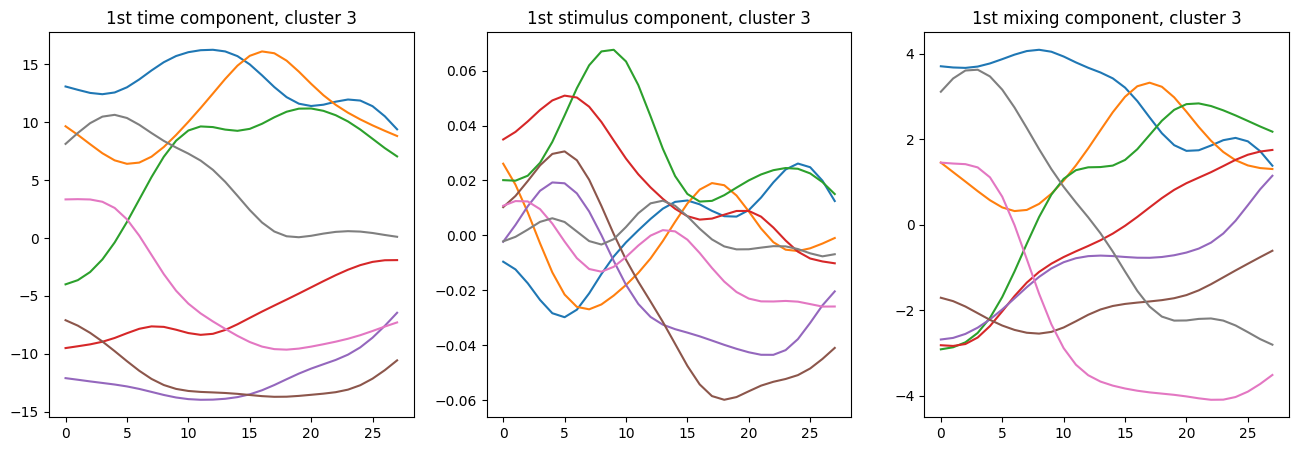

time: 949 ms (started: 2023-08-10 11:59:54 +01:00)


In [91]:
# plot modified 
time = np.arange(num_time)


for cluster in range(len(neuron_types)):
    plt.figure(figsize=(16,5))
    plt.subplot(131)
    for s in range(num_targets):
        #plt.plot(time,Z_all[f'{cluster}']['t'][0,s])
        plt.plot(time,Z_all[f'{cluster}']['t'][0,:,s])
    plt.title(f'1st time component, cluster {cluster}')

    plt.subplot(132)

    for s in range(num_targets):
        #plt.plot(time,Z_all[f'{cluster}']['s'][0,s])
        plt.plot(time,Z_all[f'{cluster}']['s'][0,:,s])
    plt.title(f'1st stimulus component, cluster {cluster}')

    plt.subplot(133)

    for s in range(num_targets):
        #plt.plot(time,Z_all[f'{cluster}']['st'][0,s]) 
        plt.plot(time,Z_all[f'{cluster}']['st'][0,:,s]) 
    plt.title(f'1st mixing component, cluster {cluster}')

    plt.show()


In [ ]:
print(Z['s'].shape) # try using this for velocity decoding
print(Z['t'].shape) # try using only this info for target classifier
print(Z['st'].shape) # try using this for velocity decoding


In [ ]:
# plot all mixing components
for comp in range(10):
    plt.figure(figsize=(3,3))
    for s in range(num_targets):
        #plt.plot(time,Z_all['t'][comp,s])
        plt.plot(time,Z_all['3']['t'][comp,:,s])
        plt.title(f'mixing component {comp}')
        plt.ylim([-30, 30])
    plt.show()


In [ ]:
Z['t'].shape

## Velocity decoding with dPCA

In [ ]:
# preprocessing
td = preprocessing_general(data_spikes)
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -6, 21, rates=True)


In [ ]:
# always using the same transform matrix found before
neuron_types = neuron_classes(clustering_solution) # neuron in each cluster
rep = 10 # repeat 10 times
mean_R2s = np.zeros((rep,len(neuron_types)))
train_on_each_cluster = True
dataset = 'C19'

# number of trials to each target
target_index = trials_per_target(td_processed)
tr_per_target = []
for i in range(len(target_index)):
    tr_per_target.append(len(target_index[i]))

tr_per_target = np.array(tr_per_target)
tr_per_target = tr_per_target[tr_per_target != 0]

num_trials = td_processed.shape[0]
num_neurons = td_processed.both_rates[0].shape[1]
min_per_target = np.min(tr_per_target)
num_time = td_processed.both_rates[0].shape[0]    
    
for cluster in range(len(neuron_types)): # for each cluster
    print(cluster)
    for z in range(rep):
        
        if dataset == 'C15':
            N_samples = 20 # 20 for 6,7 clusters, 20 for 4 clusters, 70 for 3 clusters # 20 for 4 clsuters??
            pca_dims = 11 # 10 for 6,7 clusters, 11 for 4 clusters, 52 for 3 clusters
        elif dataset == 'C19':
            N_samples = 15
            pca_dims = 10
        elif dataset == 'M17':
            N_samples = 15
            pca_dims = 10
        elif dataset == 'M18':
            N_samples = 20
            pca_dims = 11
        
        '''
        if train_on_each_cluster:
            sampled_data = sample_neurons(neuron_types, N_samples)
            move_td = apply_dPCA(td_processed, tr_per_target, sampled_neurons, N_samples=58)
        else:
            sampled_data = np.random.choice(np.arange(len(clustering_solution)), size=N_samples) # sample from whole dataset
            move_td = apply_PCA(td_processed, sampled_data, -1, pca_dims)
        '''
        # define what time period to use rates from (with respect to the output)
        bins_before = 6
        bins_current = 1 
        bins_after = 6
        

        sampled_data = sample_neurons(neuron_types, N_samples)
        #data = np.zeros((N_samples, num_time))
        # tr_per_target_found = [0]*num_targets
        
        neural_data = []
        for trial in range(td_processed.shape[0]):
            trial_data = td_processed.both_rates[trial][:,sampled_data[cluster]]
            target = td_processed.target_id[trial]
            dPCA_rates = np.matmul(trial_data, transf_matrix_s[f'{cluster}'][target])
            neural_data.extend(dPCA_rates)
    
        neural_data = np.array(neural_data)
        
        X = get_spikes_with_history(neural_data, bins_before, bins_after, bins_current)
        
        # only give info about magnitude of movement, but not direction
        #move_td.vel = abs(move_td.vel)
        y = concat_trials(td_processed, "vel")
        
        training_range = [0, 0.7]
        testing_range = [0.7, 0.85]
        valid_range = [0.85,1]

        X_train, X_test, X_valid, y_train, y_test, y_valid = split_data(X, y, training_range, testing_range, valid_range,
                                                                         bins_before, bins_current, bins_after, flat=False, zero_center=True)

        #Declare model
        model_lstm = LSTMDecoder(units=400,dropout=0,num_epochs=5)

        #Fit model
        model_lstm.fit(X_train,y_train)

        #Get predictions
        y_valid_predicted_lstm =  model_lstm.predict(X_valid)

        #Get metric of fit
        R2s_lstm = get_R2(y_valid,y_valid_predicted_lstm)
        mean_R2s[z,cluster] = np.mean(R2s_lstm)
        

In [ ]:
mean_R2s

In [ ]:
r2_st = [[0.68394521, 0.49386331, 0.60264751, 0.57677207],
       [0.58035793, 0.41709021, 0.64240334, 0.53633999],
       [0.59450683, 0.40492992, 0.72976172, 0.58601179],
       [0.75227583, 0.58507501, 0.69437191, 0.55934872],
       [0.7383135 , 0.40138906, 0.5075214 , 0.58059592],
       [0.74851475, 0.43445017, 0.65411637, 0.62772572],
       [0.57528459, 0.50542841, 0.69311159, 0.62756853],
       [0.66852838, 0.48080045, 0.56814375, 0.59389638],
       [0.68286066, 0.32438511, 0.68443948, 0.62119528],
       [0.7357141 , 0.52295557, 0.54943477, 0.55825175]]

r2_t = [[0.6474154 , 0.43870625, 0.49756218, 0.53966017],
       [0.66715742, 0.51139742, 0.71788369, 0.60348073],
       [0.59865735, 0.52882819, 0.58710702, 0.49931862],
       [0.70508447, 0.43078267, 0.67878676, 0.5197584 ],
       [0.64854829, 0.41829679, 0.60784969, 0.67227634],
       [0.63935981, 0.52135545, 0.63875009, 0.59506935],
       [0.59997986, 0.55478782, 0.68606386, 0.71418879],
       [0.65961095, 0.5233292 , 0.66285677, 0.52532911],
       [0.56146769, 0.40896158, 0.55297424, 0.57419539],
       [0.64369613, 0.3948967 , 0.502351  , 0.56864406]]

r2_s = [[0.62335674, 0.36164164, 0.54474606, 0.39614301],
       [0.63184177, 0.34915213, 0.56147733, 0.62712785],
       [0.56970841, 0.49966952, 0.59692664, 0.38633152],
       [0.64837995, 0.3832144 , 0.57143275, 0.53515308],
       [0.54267782, 0.42593563, 0.59478636, 0.54677521],
       [0.53827311, 0.57824889, 0.52394471, 0.57689454],
       [0.65184895, 0.3903    , 0.60071554, 0.64963982],
       [0.62149902, 0.29588582, 0.62797979, 0.5495999 ],
       [0.61458518, 0.47305408, 0.67204572, 0.63677656],
       [0.63759061, 0.40127356, 0.62602775, 0.38645573]]

r2_pca = [[0.69769582, 0.46559943, 0.73024136, 0.56559442],
       [0.7461994 , 0.45198536, 0.74236074, 0.57096739],
       [0.77003291, 0.51529288, 0.72753891, 0.4722226 ],
       [0.73645249, 0.4507195 , 0.67709964, 0.59805566],
       [0.75415431, 0.4744763 , 0.72575772, 0.64098665],
       [0.76026422, 0.52830004, 0.69270418, 0.59200074],
       [0.71210494, 0.51312046, 0.74435956, 0.5874625 ],
       [0.71425813, 0.45833375, 0.72871525, 0.4487798 ],
       [0.70980356, 0.53182681, 0.71437418, 0.44430007],
       [0.75020772, 0.45435731, 0.72856192, 0.57274672]]



plt.plot()
_, _ = plot_R2(r2_s, [])
_, _ = plot_R2(r2_t, [])
_, _ = plot_R2(r2_st, [])
_, _ = plot_R2(r2_pca, [])

plt.title(r'$R^2$ from velocity decoding')
plt.xticks([0,1,2,3], labels = ['1','2','3','4'])
plt.xlabel('Neuorn class')
plt.legend(['target components', 'timing components', 'mixed components', 'from pca'], loc='lower right')
plt.show()

In [ ]:
# genrating new transform matrix for each set of sampled neurons

neuron_types = neuron_classes(clustering_solution) # neuron in each cluster
rep = 10 # repeat 10 times
mean_R2s = np.zeros((rep,len(neuron_types)))
train_on_each_cluster = True
dataset = 'C19'

# number of trials to each target
target_index = trials_per_target(td_processed)
tr_per_target = []
for i in range(len(target_index)):
    tr_per_target.append(len(target_index[i]))

tr_per_target = np.array(tr_per_target)
tr_per_target = tr_per_target[tr_per_target != 0]

num_trials = td_processed.shape[0]
num_neurons = td_processed.both_rates[0].shape[1]
min_per_target = np.min(tr_per_target)
num_time = td_processed.both_rates[0].shape[0]    
    
for cluster in range(len(neuron_types)): # for each cluster
    print(cluster)
    for z in range(rep):
        
        if dataset == 'C15':
            N_samples = 20 # 20 for 6,7 clusters, 20 for 4 clusters, 70 for 3 clusters # 20 for 4 clsuters??
            pca_dims = 11 # 10 for 6,7 clusters, 11 for 4 clusters, 52 for 3 clusters
        elif dataset == 'C19':
            N_samples = 15
            pca_dims = 10
        elif dataset == 'M17':
            N_samples = 15
            pca_dims = 10
        elif dataset == 'M18':
            N_samples = 20
            pca_dims = 11
        
        '''
        if train_on_each_cluster:
            sampled_data = sample_neurons(neuron_types, N_samples)
            move_td = apply_dPCA(td_processed, tr_per_target, sampled_neurons, N_samples=58)
        else:
            sampled_data = np.random.choice(np.arange(len(clustering_solution)), size=N_samples) # sample from whole dataset
            move_td = apply_PCA(td_processed, sampled_data, -1, pca_dims)
        '''
        # define what time period to use rates from (with respect to the output)
        bins_before = 6
        bins_current = 1 
        bins_after = 6
        
        sampled_data = sample_neurons(neuron_types, N_samples)
        #data = np.zeros((N_samples, num_time))
        # tr_per_target_found = [0]*num_targets
        
        transf_matrix_t, transf_matrix_s, transf_matrix_st = dPCA_transformation_matrix(
            td_processed, tr_per_target, sampled_data, N_samples, cluster)
        
        neural_data = []
        for trial in range(td_processed.shape[0]):
            trial_data = td_processed.both_rates[trial][:,sampled_data[cluster]]
            target = td_processed.target_id[trial]
            dPCA_rates = np.matmul(trial_data, transf_matrix_st[target])
            neural_data.extend(dPCA_rates)
    
        neural_data = np.array(neural_data)
        
        X = get_spikes_with_history(neural_data, bins_before, bins_after, bins_current)
        
        # only give info about magnitude of movement, but not direction
        #move_td.vel = abs(move_td.vel)
        y = concat_trials(td_processed, "vel")
        
        training_range = [0, 0.7]
        testing_range = [0.7, 0.85]
        valid_range = [0.85,1]

        X_train, X_test, X_valid, y_train, y_test, y_valid = split_data(X, y, training_range, testing_range, valid_range,
                                                                         bins_before, bins_current, bins_after, flat=False, zero_center=True)

        #Declare model
        model_lstm = LSTMDecoder(units=400,dropout=0,num_epochs=5)

        #Fit model
        model_lstm.fit(X_train,y_train)

        #Get predictions
        y_valid_predicted_lstm =  model_lstm.predict(X_valid)

        #Get metric of fit
        R2s_lstm = get_R2(y_valid,y_valid_predicted_lstm)
        mean_R2s[z,cluster] = np.mean(R2s_lstm)
        

In [ ]:
mean_R2s

In [ ]:
r2_old = [[0.68394521, 0.49386331, 0.60264751, 0.57677207],
       [0.58035793, 0.41709021, 0.64240334, 0.53633999],
       [0.59450683, 0.40492992, 0.72976172, 0.58601179],
       [0.75227583, 0.58507501, 0.69437191, 0.55934872],
       [0.7383135 , 0.40138906, 0.5075214 , 0.58059592],
       [0.74851475, 0.43445017, 0.65411637, 0.62772572],
       [0.57528459, 0.50542841, 0.69311159, 0.62756853],
       [0.66852838, 0.48080045, 0.56814375, 0.59389638],
       [0.68286066, 0.32438511, 0.68443948, 0.62119528],
       [0.7357141 , 0.52295557, 0.54943477, 0.55825175]]



r2_new = [[0.5751877 , 0.36508708, 0.52593937, 0.41333456],
       [0.61527872, 0.37179959, 0.5608289 , 0.41442675],
       [0.64017177, 0.29892706, 0.69300511, 0.38481414],
       [0.68033038, 0.33824281, 0.72130082, 0.52954574],
       [0.65978123, 0.34128669, 0.46299395, 0.43136723],
       [0.56178303, 0.45811696, 0.4439034 , 0.42456374],
       [0.62228696, 0.31726884, 0.6175805 , 0.47098181],
       [0.55637886, 0.3502686 , 0.58474325, 0.42018554],
       [0.65479665, 0.50733136, 0.5364215 , 0.43071579],
       [0.70119112, 0.41008428, 0.51140139, 0.44411189]]

plt.plot()
r2_mean, r2_sme = plot_R2(r2_new, [])
_, _ = plot_R2(r2_old, [])
plt.title(r'$R^2$ from velocity decoding')
plt.xticks([0,1,2,3], labels = ['1','2','3','4'])
plt.xlabel('Neuorn class')
plt.legend(['new', 'old'])
plt.show()

## dPCA explained variance ratio

In [103]:
target_index = trials_per_target(td_processed)
tr_per_target = []
for i in range(len(target_index)):
    tr_per_target.append(len(target_index[i]))

tr_per_target = np.array(tr_per_target)
tr_per_target = tr_per_target[tr_per_target != 0]
#tr_per_target

time: 27.7 ms (started: 2023-08-10 12:05:39 +01:00)


In [ ]:
# all neurons - not split by cluster

# we want to reshape data according to the following:
# [num of trials in each target, num of neurons, num of targets, time point]
num_trials = td_processed.shape[0]
num_neurons = td_processed.both_rates[0].shape[1]
num_targets = len(tr_per_target)
min_per_target = np.min(tr_per_target)
num_time = td_processed.both_rates[0].shape[0]

neuron_types = neuron_classes(clustering_solution) # neuron in each cluster

Z_all = {}
transf_matrix_t = {}
transf_matrix_s = {}
transf_matrix_st = {}
explained_variance_ratio = {}
for clust in range(len(neuron_types)):
        Z_all[f'{clust}'] = []
        transf_matrix_t[f'{clust}'] = []
        transf_matrix_s[f'{clust}'] = []
        transf_matrix_st[f'{clust}'] = []
        explained_variance_ratio[f'{clust}'] = []

data = np.zeros((min_per_target, num_neurons, num_targets, num_time))
tr_per_target_found = [0]*num_targets

for trial in range(num_trials):
    targetID = td_processed.target_id[trial] # ID of target of this trial
    if tr_per_target_found[targetID] >= min_per_target: continue
    data[tr_per_target_found[targetID], :, targetID, :] = np.transpose(td_processed.both_rates[trial])
    tr_per_target_found[targetID] += 1 # trials for this target already found
    
avg_trial_per_target = np.mean(data, axis=0)

# apply dPCA 
dpca = dPCA.dPCA(labels='st',regularizer='auto', n_components=10)
dpca.protect = ['t']
Z_all = dpca.fit_transform(avg_trial_per_target, data)
explained_variance_ratio = dpca.explained_variance_ratio_


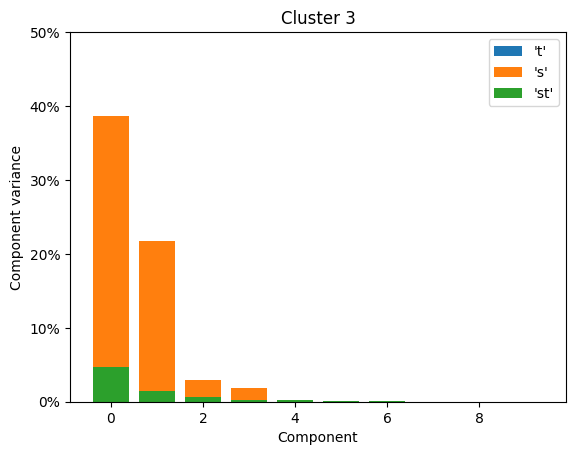

time: 112 ms (started: 2023-08-10 12:18:03 +01:00)


In [127]:
# plot explained variance for dPCA on all neurons
# plot explained variance for each component over all marginalization
tot_explained_s = 0
tot_explained_t = 0
tot_explained_st = 0

explained_var_components = {}

for clust in range(len(neuron_types)):
        explained_var_components = np.zeros(10)


for marg in ['t', 's', 'st']:
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

    # explained_var_components[f'{clust}'] += explained_variance_ratio[f'{cluster}'][marg]
    plt.bar(np.arange(10), explained_variance_ratio[marg], label=f"'{marg}'")
    plt.legend()
    plt.title(f"Cluster {cluster}")
    plt.ylabel('Component variance')
    plt.xlabel('Component')
    plt.ylim([0,0.5])


    #bot += explained_variance_ratio[f'{cluster}'][marg]
c += 1

plt.show()

In [ ]:
# all neurons from each cluster

# we want to reshape data according to the following:
# [num of trials in each target, num of neurons, num of targets, time point]
num_trials = td_processed.shape[0]
num_neurons = td_processed.both_rates[0].shape[1]
num_targets = len(tr_per_target)
min_per_target = np.min(tr_per_target)
num_time = td_processed.both_rates[0].shape[0]

neuron_types = neuron_classes(clustering_solution) # neuron in each cluster

Z_all = {}
transf_matrix_t = {}
transf_matrix_s = {}
transf_matrix_st = {}
explained_variance_ratio = {}
for clust in range(len(neuron_types)):
        Z_all[f'{clust}'] = []
        transf_matrix_t[f'{clust}'] = []
        transf_matrix_s[f'{clust}'] = []
        transf_matrix_st[f'{clust}'] = []
        explained_variance_ratio[f'{clust}'] = []

for cluster in range(len(neuron_types)):
    
    data = np.zeros((min_per_target, len(neuron_types[cluster]), num_targets, num_time))
    tr_per_target_found = [0]*num_targets

    for trial in range(num_trials):
        targetID = td_processed.target_id[trial] # ID of target of this trial
        if tr_per_target_found[targetID] >= min_per_target: continue
        data[tr_per_target_found[targetID], :, targetID, :] = np.transpose(td_processed.both_rates[trial][:,neuron_types[cluster]])
        tr_per_target_found[targetID] += 1 # trials for this target already found

    avg_trial_per_target = np.mean(data, axis=0)
    
    # apply dPCA 
    dpca = dPCA.dPCA(labels='st',regularizer='auto', n_components=10)
    dpca.protect = ['t']
    #dpca.protect = []
    Z_all[f'{cluster}'] = dpca.fit_transform(avg_trial_per_target, data)
    explained_variance_ratio[f'{cluster}'] = dpca.explained_variance_ratio_
    
    # compute inverse of avg data
    data_avg_inv = np.linalg.pinv(avg_trial_per_target)
    
    # compute transformation matrices for each cluster
    transf_matrix_t[f'{cluster}'] = np.matmul(np.transpose(data_avg_inv,[2,0,1]),np.transpose(Z_all[f'{cluster}']['t'],[1,2,0]))
    transf_matrix_s[f'{cluster}'] = np.matmul(np.transpose(data_avg_inv,[2,0,1]),np.transpose(Z_all[f'{cluster}']['s'],[1,2,0]))
    transf_matrix_st[f'{cluster}'] = np.matmul(np.transpose(data_avg_inv,[2,0,1]),np.transpose(Z_all[f'{cluster}']['st'],[1,2,0]))

    

In [ ]:
# all neurons from each cluster - modified

# we want to reshape data according to the following:
# [num of trials in each target, num of neurons, num of targets, time point]
num_trials = td_processed.shape[0]
num_neurons = td_processed.both_rates[0].shape[1]
num_targets = len(tr_per_target)
min_per_target = np.min(tr_per_target)
num_time = td_processed.both_rates[0].shape[0]

neuron_types = neuron_classes(clustering_solution) # neuron in each cluster

Z_all = {}
transf_matrix_t = {}
transf_matrix_s = {}
transf_matrix_st = {}
explained_variance_ratio = {}
for clust in range(len(neuron_types)):
        Z_all[f'{clust}'] = []
        transf_matrix_t[f'{clust}'] = []
        transf_matrix_s[f'{clust}'] = []
        transf_matrix_st[f'{clust}'] = []
        explained_variance_ratio[f'{clust}'] = []

for cluster in range(len(neuron_types)):
    
    data = np.zeros((min_per_target, len(neuron_types[cluster]), num_time, num_targets))
    tr_per_target_found = [0]*num_targets

    for trial in range(num_trials):
        targetID = td_processed.target_id[trial] # ID of target of this trial
        if tr_per_target_found[targetID] >= min_per_target: continue
        data[tr_per_target_found[targetID], :, :, targetID] = np.transpose(td_processed.both_rates[trial][:,neuron_types[cluster]])
        tr_per_target_found[targetID] += 1 # trials for this target already found

    avg_trial_per_target = np.mean(data, axis=0)
    
    # center data
    avg_trial_per_target -= np.mean(avg_trial_per_target.reshape((len(neuron_types[cluster]),-1)),1)[:,None,None]

    
    # apply dPCA 
    dpca = dPCA.dPCA(labels='st',regularizer='auto', n_components=10)
    dpca.protect = ['t']
    #dpca.protect = []
    Z_all[f'{cluster}'] = dpca.fit_transform(avg_trial_per_target, data)
    explained_variance_ratio[f'{cluster}'] = dpca.explained_variance_ratio_
    
    # compute inverse of avg data
    data_avg_inv = np.linalg.pinv(avg_trial_per_target)
    
    # compute transformation matrices for each cluster
    transf_matrix_t[f'{cluster}'] = np.matmul(np.transpose(data_avg_inv,[2,0,1]),np.transpose(Z_all[f'{cluster}']['t'],[1,2,0]))
    transf_matrix_s[f'{cluster}'] = np.matmul(np.transpose(data_avg_inv,[2,0,1]),np.transpose(Z_all[f'{cluster}']['s'],[1,2,0]))
    transf_matrix_st[f'{cluster}'] = np.matmul(np.transpose(data_avg_inv,[2,0,1]),np.transpose(Z_all[f'{cluster}']['st'],[1,2,0]))

    

In [ ]:
# WRONG - plotting like this doesn't make sense

# plot explained variance for each cluster of each marginalization separately
tot_explained_s = 0
tot_explained_t = 0
tot_explained_st = 0
marg = 's' # marginalization

for marg in ['s', 't', 'st']:
    bot = np.zeros(10)
    for cluster in range(len(neuron_types)):

        plt.bar(np.arange(10), explained_variance_ratio[f'{cluster}'][marg], bottom=bot, label=f'cluster {cluster}')
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
        plt.legend()
        plt.title(f"Variance explained for each cluster for marginalization '{marg}'")
        plt.ylabel('Component variance')
        plt.xlabel('Component')

        bot += explained_variance_ratio[f'{cluster}'][marg]

    plt.show()

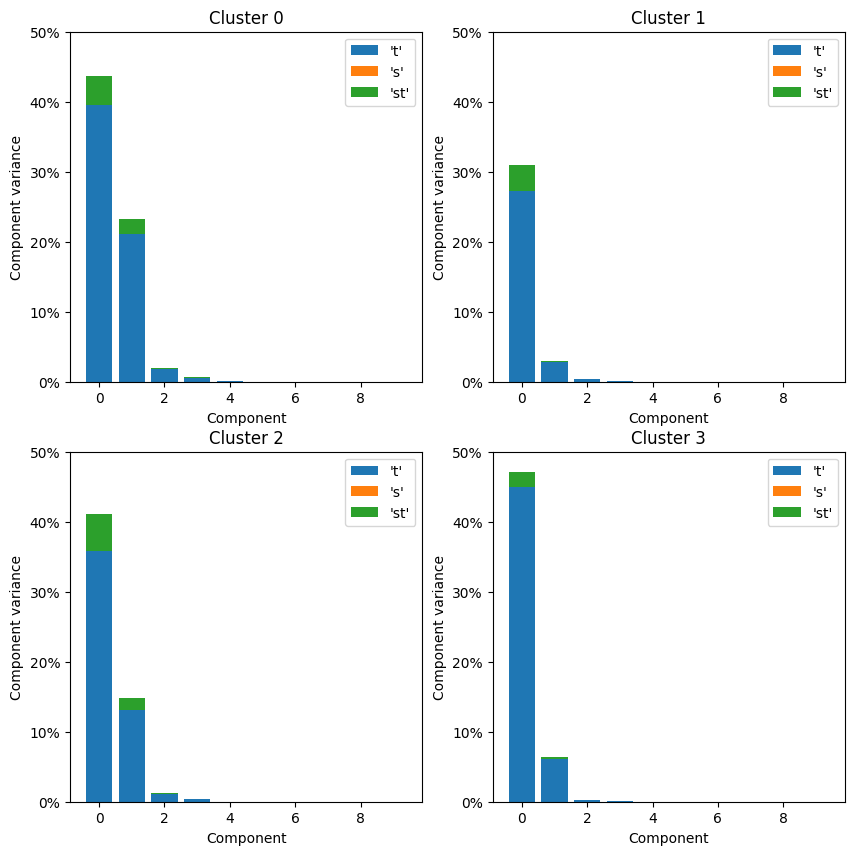

time: 386 ms (started: 2023-08-08 11:34:12 +01:00)


In [171]:
# plot explained variance for each component over all marginalization
tot_explained_s = 0
tot_explained_t = 0
tot_explained_st = 0

explained_var_components = {}

for clust in range(len(neuron_types)):
        explained_var_components[f'{clust}'] = np.zeros(10)

f,ax = plt.subplots(2,2, figsize=(10,10))
r,c = 0,0

for cluster in range(len(neuron_types)):
    bot = np.zeros(10)
    if c == 2:
        r += 1
        c = 0
    for marg in ['t', 's', 'st']:
        ax[r,c].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

        # explained_var_components[f'{clust}'] += explained_variance_ratio[f'{cluster}'][marg]
        ax[r,c].bar(np.arange(10), explained_variance_ratio[f'{cluster}'][marg], bottom=bot, label=f"'{marg}'")
        ax[r,c].legend()
        ax[r,c].set_title(f"Cluster {cluster}")
        ax[r,c].set_ylabel('Component variance')
        ax[r,c].set_xlabel('Component')
        ax[r,c].set_ylim([0,0.5])
    
        
        bot += explained_variance_ratio[f'{cluster}'][marg]
    c += 1

plt.show()

## explained variance vs n_components

In [ ]:
# when n_components is greater than the number of neurons in cluster
# obtain n_components = num_neurons in cluster
n_components = np.max([len(neuron_types[cluster]) for cluster in range(len(neuron_types))])
explained_variance_ratio = dpca_explained_variance(td_processed, tr_per_target, neuron_types, n_components)


In [ ]:
# WRONG !
# all explained variance for each cluster, not split by marginalization
explained_var_all_marg = {}
for clust in range(len(neuron_types)):
    explained_var_all_marg[f'{clust}'] = np.zeros(len(explained_variance_ratio[f'{clust}']['s']))
    
    for marg in ['s', 't', 'st']:
        explained_var_all_marg[f'{clust}'] += explained_variance_ratio[f'{clust}'][marg]


tot_explained_var = {}
for clust in range(len(neuron_types)):
    
    tot_explained_var[f'{clust}'] = np.zeros(len(explained_var_all_marg[f'{clust}']+1))
    tot_explained_var[f'{clust}'][1] = explained_var_all_marg[f'{clust}'][0]
    
    for comp in range(2, len(explained_var_all_marg[f'{clust}'])):
        tot_explained_var[f'{clust}'][comp] = tot_explained_var[f'{clust}'][comp-1] +  explained_var_all_marg[f'{clust}'][comp]
        

# plot cumulative explained variance for each cluster
for clust in range(len(neuron_types)):
    x = np.arange(len(neuron_types[clust]))
    
    plt.plot(tot_explained_var[f'{clust}'], c=CUSTOM_PAL_SORT[clust])
    plt.scatter(x,tot_explained_var[f'{clust}'], marker='.', s=20, c=CUSTOM_PAL_SORT[clust])
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
    #plt.legend()
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
plt.xlim(-1, n_components+1)

PCA_variance_explained(td_processed, neuron_types, -10, CUSTOM_PAL_SORT)


In [ ]:
# compute total explained variance for each marginalization over all clusters

tot_explained_s = 0
tot_explained_t = 0
tot_explained_st = 0

for cluster in range(len(neuron_types)):
    tot_explained_s += np.sum(explained_variance_ratio[f'{cluster}']['s'])
    tot_explained_t += np.sum(explained_variance_ratio[f'{cluster}']['t'])
    tot_explained_st += np.sum(explained_variance_ratio[f'{cluster}']['st'])


print(tot_explained_s)
print(tot_explained_t)
print(tot_explained_st)
print(tot_explained_s+tot_explained_t+tot_explained_st)

In [ ]:
# np.reshape -> One shape dimension can be -1,
# In this case, the value is inferred from the length of the array and remaining dimensions.
# these are lines used in dPCA.py, DON'T RUN THIS

# transform:
D, Xr = self.D[marginalization], X.reshape((X.shape[0],-1))
np.dot(D.T, Xr).reshape((D.shape[1],) + X.shape[1:])


# inverse transform
X_transformed = np.dot(self.P[marginalization],X.reshape((X.shape[0],-1))).reshape((self.P[marginalization].shape[0],) + X.shape[1:])


In [ ]:
# preprocessing
td = preprocessing_general(data_spikes)
td_processed = preprocessing_spikes(td, trials_to_keep_M1, trials_to_keep_PMd, "idx_movement_on", -6, 21, rates=True)

In [108]:
target_index = trials_per_target(td_processed)
tr_per_target = []
for i in range(len(target_index)):
    tr_per_target.append(len(target_index[i]))

tr_per_target = np.array(tr_per_target)
tr_per_target = tr_per_target[tr_per_target != 0]
#tr_per_target

time: 24.1 ms (started: 2023-08-08 11:01:34 +01:00)


In [ ]:
# all neurons from each cluster

# we want to reshape data according to the following:
# [num of trials in each target, num of neurons, num of targets, time point]
num_trials = td_processed.shape[0]
num_neurons = td_processed.both_rates[0].shape[1]
num_targets = len(tr_per_target)
min_per_target = np.min(tr_per_target)
num_time = td_processed.both_rates[0].shape[0]

neuron_types = neuron_classes(clustering_solution) # neuron in each cluster

Z_all = {clust: [] for clust in range(len(neuron_types)) }
explained_variance_ratio = {clust: [] for clust in range(len(neuron_types)) }

marginalization = {marg: [] for marg in ['s', 't', 'st'] }
expl_var_tot = {clust: copy.deepcopy(marginalization) for clust in range(len(neuron_types)) }

n_comp = np.arange(1, 50, 5)
for comps in n_comp:
    print('---------------------', comps, '---------------------')
    for cluster in range(len(neuron_types)):

        data = np.zeros((min_per_target, len(neuron_types[cluster]), num_targets, num_time))
        tr_per_target_found = [0]*num_targets

        for trial in range(num_trials):
            targetID = td_processed.target_id[trial] # ID of target of this trial
            if tr_per_target_found[targetID] >= min_per_target: continue
            data[tr_per_target_found[targetID], :, targetID, :] = np.transpose(td_processed.both_rates[trial][:,neuron_types[cluster]])
            tr_per_target_found[targetID] += 1 # trials for this target already found

        avg_trial_per_target = np.mean(data, axis=0)
        
        # apply dPCA 
        dpca = dPCA.dPCA(labels='st',regularizer='auto', n_components=comps)
        dpca.protect = ['t']
        Z_all[cluster] = dpca.fit_transform(avg_trial_per_target, data)
        explained_variance_ratio[cluster] = dpca.explained_variance_ratio_
        
        for marg in ['s', 't', 'st']:
            X = avg_trial_per_target
            D, Xr = dpca.D[marg], X.reshape((X.shape[0],-1))
            DX = np.dot(D.T, Xr).reshape((D.shape[1],) + X.shape[1:])

            FDX_ = np.dot(dpca.P[marg], DX.reshape((DX.shape[0],-1)))
            FDX = FDX_.reshape((dpca.P[marg].shape[0],) + DX.shape[1:])

            expl_var_tot[cluster][marg].append((np.linalg.norm(X)**2 - np.linalg.norm(X - FDX)**2)/(np.linalg.norm(X)**2))



In [ ]:
# all neurons from each cluster - modified

# we want to reshape data according to the following:
# [num of trials in each target, num of neurons, num of targets, time point]
num_trials = td_processed.shape[0]
num_neurons = td_processed.both_rates[0].shape[1]
num_targets = len(tr_per_target)
min_per_target = np.min(tr_per_target)
num_time = td_processed.both_rates[0].shape[0]

neuron_types = neuron_classes(clustering_solution) # neuron in each cluster

Z_all = {clust: [] for clust in range(len(neuron_types)) }
explained_variance_ratio = {clust: [] for clust in range(len(neuron_types)) }

marginalization = {marg: [] for marg in ['s', 't', 'st'] }
expl_var_tot = {clust: copy.deepcopy(marginalization) for clust in range(len(neuron_types)) }

n_comp = np.arange(1, 50, 5)
for comps in n_comp:
    print('---------------------', comps, '---------------------')
    for cluster in range(len(neuron_types)):

        data = np.zeros((min_per_target, len(neuron_types[cluster]), num_time, num_targets))
        tr_per_target_found = [0]*num_targets

        for trial in range(num_trials):
            targetID = td_processed.target_id[trial] # ID of target of this trial
            if tr_per_target_found[targetID] >= min_per_target: continue
            data[tr_per_target_found[targetID], :, :, targetID] = np.transpose(td_processed.both_rates[trial][:,neuron_types[cluster]])
            tr_per_target_found[targetID] += 1 # trials for this target already found

        avg_trial_per_target = np.mean(data, axis=0)
        
        # apply dPCA 
        dpca = dPCA.dPCA(labels='st',regularizer='auto', n_components=comps)
        dpca.protect = ['t']
        Z_all[cluster] = dpca.fit_transform(avg_trial_per_target, data)
        explained_variance_ratio[cluster] = dpca.explained_variance_ratio_
        
        for marg in ['s', 't', 'st']:
            X = avg_trial_per_target
            D, Xr = dpca.D[marg], X.reshape((X.shape[0],-1))
            DX = np.dot(D.T, Xr).reshape((D.shape[1],) + X.shape[1:])

            FDX_ = np.dot(dpca.P[marg], DX.reshape((DX.shape[0],-1)))
            FDX = FDX_.reshape((dpca.P[marg].shape[0],) + DX.shape[1:])

            expl_var_tot[cluster][marg].append((np.linalg.norm(X)**2 - np.linalg.norm(X - FDX)**2)/(np.linalg.norm(X)**2))



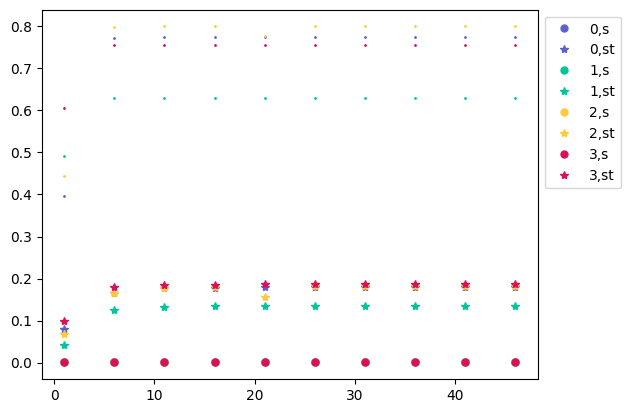

time: 130 ms (started: 2023-08-08 11:05:40 +01:00)


In [110]:
colors = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9']

for clust in range(len(neuron_types)):
    plt.plot(n_comp, expl_var_tot[clust]['s'], 'o', label=f'{clust},s', markersize=5, c=colors[clust])
    plt.plot(n_comp, expl_var_tot[clust]['st'], '*', label=f'{clust},st', c=colors[clust])
    plt.plot(n_comp, expl_var_tot[clust]['t'], '.',  markersize=2, c=colors[clust])
plt.legend(bbox_to_anchor=(1,1))

In [111]:
expl_var_all = np.zeros((len(neuron_types), len(n_comp)+1))

for clust in range(len(neuron_types)):
    for marg in ['s', 't', 'st']:
        expl_var_all[clust,1:] += expl_var_tot[clust][marg]

    

time: 650 µs (started: 2023-08-08 11:05:52 +01:00)


/tmp/ipykernel_3902209/1898737298.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_spikes_new.both_rates[i] = data_spikes_new.both_rates[i][:, neuron_types[j]]
/tmp/ipykernel_3902209/1898737298.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_spikes_new.both_rates[i] = data_spikes_new.both_rates[i][:, neuron_types[j]]
/tmp/ipykernel_3902209/1898737298.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_spikes_ne

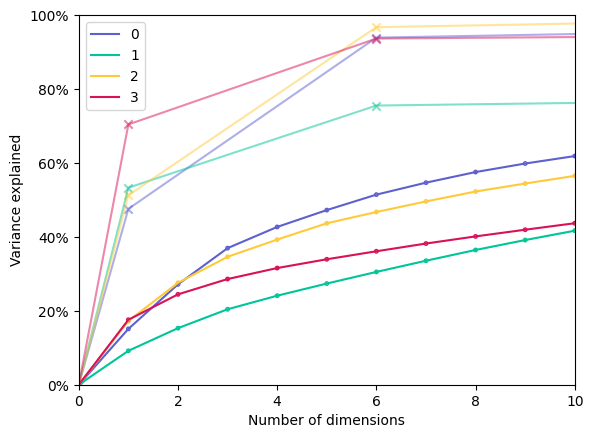

time: 607 ms (started: 2023-08-08 11:06:26 +01:00)


In [116]:
for clust in range(len(neuron_types)):
    plt.plot(np.insert(n_comp,0,0), expl_var_all[clust], c=CUSTOM_PAL_SORT[clust], alpha=0.5)
    plt.scatter(np.insert(n_comp,0,0), expl_var_all[clust],marker='x', c=CUSTOM_PAL_SORT[clust], alpha=0.5)

    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

plt.xlim([0,len(n_comp)])
plt.ylim([0,1])
PCA_variance_explained(td_processed, neuron_types, -10, CUSTOM_PAL_SORT, hline=False)


In [ ]:
#same as part before, only changed order or matrix multiplication

# we want to reshape data according to the following:
# [num of trials in each target, num of neurons, num of targets, time point]
num_trials = td_processed.shape[0]
num_neurons = td_processed.both_rates[0].shape[1]
num_targets = len(tr_per_target)
min_per_target = np.min(tr_per_target)
num_time = td_processed.both_rates[0].shape[0]

neuron_types = neuron_classes(clustering_solution) # neuron in each cluster

Z_all = {clust: [] for clust in range(len(neuron_types)) }
explained_variance_ratio = {clust: [] for clust in range(len(neuron_types)) }

marginalization = {marg: [] for marg in ['s', 't', 'st'] }
expl_var_tot = {clust: copy.deepcopy(marginalization) for clust in range(len(neuron_types)) }

n_comp = np.arange(1, 11, 1)
for comps in n_comp:
    print('---------------------', comps, '---------------------')
    for cluster in range(len(neuron_types)):

        data = np.zeros((min_per_target, len(neuron_types[cluster]), num_targets, num_time))
        tr_per_target_found = [0]*num_targets

        for trial in range(num_trials):
            targetID = td_processed.target_id[trial] # ID of target of this trial
            if tr_per_target_found[targetID] >= min_per_target: continue
            data[tr_per_target_found[targetID], :, targetID, :] = np.transpose(td_processed.both_rates[trial][:,neuron_types[cluster]])
            tr_per_target_found[targetID] += 1 # trials for this target already found

        avg_trial_per_target = np.mean(data, axis=0)

        # apply dPCA 
        dpca = dPCA.dPCA(labels='st',regularizer='auto', n_components=comps)
        dpca.protect = ['t']
        Z_all[cluster] = dpca.fit_transform(avg_trial_per_target, data)
        explained_variance_ratio[cluster] = dpca.explained_variance_ratio_
        
        for marg in ['s', 't', 'st']:
            X = avg_trial_per_target
            D = dpca.D[marg]
            F = dpca.P[marg]
            Xr = X.reshape((X.shape[0],-1))
            FD = np.matmul(D, F.T)
            FDX_ = np.matmul(FD, Xr)
            FDX = FDX_.reshape((dpca.P[marg].shape[0],) + X.shape[1:])

            expl_var_tot[cluster][marg].append((np.linalg.norm(X)**2 - np.linalg.norm(X - FDX)**2)/(np.linalg.norm(X)**2))


            
expl_var_all = np.zeros((len(neuron_types), len(n_comp)+1))

for clust in range(len(neuron_types)):
    for marg in ['s', 't', 'st']:
        expl_var_all[clust,1:] += expl_var_tot[clust][marg]

    
for clust in range(len(neuron_types)):
    plt.plot(np.insert(n_comp,0,0), expl_var_all[clust], c=CUSTOM_PAL_SORT[clust], alpha=0.5)
    plt.scatter(np.insert(n_comp,0,0), expl_var_all[clust],marker='x', c=CUSTOM_PAL_SORT[clust], alpha=0.5)

    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

plt.xlim([0,len(n_comp)])
#plt.ylim([0,1])
PCA_variance_explained(td_processed, neuron_types, -10, CUSTOM_PAL_SORT, hline=False)
  
    

In [117]:
# plot explained variance for each component over all marginalization

explained_var_components = {}

for clust in range(len(neuron_types)):
        explained_var_components[f'{clust}'] = np.zeros(10)

        
for cluster in range(len(neuron_types)):
    bot = np.zeros(10)
    plt.figure(figsize=(5,5))
    for marg in ['s', 'st', 't']:
        # explained_var_components[f'{clust}'] += explained_variance_ratio[f'{cluster}'][marg]

        plt.bar(np.arange(10), explained_variance_ratio[f'{cluster}'][marg], bottom=bot, label=f"'{marg}'")
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
        plt.legend()
        plt.title(f"Variance explained for each component in cluster {cluster}")
        plt.ylabel('Component variance')
        plt.xlabel('Component')
        plt.ylim([0,0.18])
    
        
        bot += explained_variance_ratio[f'{cluster}'][marg]
    plt.show()

KeyError: '0'

<Figure size 500x500 with 0 Axes>

time: 18.2 ms (started: 2023-08-08 11:06:35 +01:00)
